In [1152]:
import re, math
import operator
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from random import randint
# import ipynb.fs.defs.PeopleInfo as peopleInfo
from nltk.corpus import stopwords
from nltk import TweetTokenizer
from nltk import PorterStemmer
import ipynb.fs.defs.FilterMethods as filterMethods
import sys, os
sys.path.append('../2_feature')
import ipynb.fs.defs.GetFeatures as getFeatures
global stop_words
stop_words = stopwords.words('english')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import display, Image
plotly.tools.set_credentials_file(username='Adeline', api_key='Z5eltNtBQXqvI05ZFQtz')
from ipywidgets import IntProgress
from IPython.display import display
import datetime
from matplotlib import dates
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.dates as mdates
from ipywidgets import IntProgress
from IPython.display import display
from collections import Counter
import string
sys.path.append('../English_to_IPA/src/')
import conversion as cv
from sklearn.metrics import precision_recall_curve

In [663]:
class Patient(object):
    totalCount = 0
    diagnosedTimeDict = dict()
    idToNameDict = dict()
#     with open('../0_dataset/diagnosedTweetsPatch2') as open_file:
    with open('../0_dataset/diagnosedTweetsPatch0') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            diagnosedTimeDict[line[0]] = datetime.datetime.strptime(line[3], "%Y-%m-%d %H:%M:%S")
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.name = Patient.idToNameDict[userId]
#         self.df0 = pd.read_csv('../0_dataset/DepressionUsersTweets/Patch2_data/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = pd.read_csv('../0_dataset/DepressionUsersTweets/Patch0_data/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)

        self.diagnosedTime = Patient.diagnosedTimeDict[userId]
        timeDuration1 = self.diagnosedTime - datetime.timedelta(days=90)
        timeDuration2 = self.diagnosedTime - datetime.timedelta(days=180)
        self.df1 = self.df0.loc[str(self.diagnosedTime):str(timeDuration1)]
        # Weird bug...
        if self.df1.empty:
            self.df1 = self.df0.loc[str(timeDuration1):str(self.diagnosedTime)]
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        # Weird bug...
        if self.df2.empty:
            self.df2 = self.df0.loc[str(timeDuration2):str(timeDuration1)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [664]:
class Ordinary(object):
    totalCount = 0
    idToNameDict = dict()
    with open('../0_dataset/ordinaryIDtoName') as open_file:
        for line in open_file.readlines():
            line = line.strip().split('\t')
            idToNameDict[line[0]] = line[1]
       
    def __init__(self, userId):
        self.userId = userId
        self.df0 = pd.read_csv('../0_dataset/OrdinaryUsersTweets/'+userId,sep='\t',header=None,usecols=[2,3],names=['Date','Text'],quoting=3,error_bad_lines=False,encoding='utf-8').dropna(axis=0, how='any')
        self.df0 = self.df0.drop_duplicates(subset='Date', keep='first')
        self.df0 = self.df0.set_index('Date')
        self.df0.index = pd.to_datetime(self.df0.index)
        self.df0 = self.df0.sort_index(ascending=False)
        
        self.newestTime = self.df0.index[0]
        self.name = Ordinary.idToNameDict[userId]
        timeDuration1 = self.newestTime - datetime.timedelta(days=90)
        timeDuration2 = self.newestTime - datetime.timedelta(days=180)
        
        self.df1 = self.df0.loc[str(self.newestTime):str(timeDuration1)]
        # Weird bug...
        if self.df1.empty:
            self.df1 = self.df0.loc[str(timeDuration1):str(self.newestTime)]
        # Weird bug...
        self.df2 = self.df0.loc[str(timeDuration1):str(timeDuration2)]
        if self.df2.empty:
            self.df2 = self.df0.loc[str(timeDuration2):str(timeDuration1)]
        Patient.totalCount += 1 
        
    def displayCount(self):
        print("Total Patients {0}".format(Patient.totalCount))
    
    def displayTweetsCount(self, category=1):
        if category == 0:
            return len(self.df0)
        elif category == 1:
            return len(self.df1)
        elif category == 2:
            return len(self.df2)
        else:
            print('Please indicate category (inRange or all)')
            return False
        
    def getText(self, category=1):
        if category == 0:
            return self.df0['Text'].values
        if category == 1:
            return self.df1['Text'].values
        elif category == 2:
            return self.df2['Text'].values
        else:
            print('Please indicate category (inRange or all)')
            return False

In [4]:
def tokenize(text):
    textList = re.findall('(?u)\\b[a-zA-Z]\\w{0,}\\b', text)
    return textList

def replace_by_symbols(txt):
    txt = re.sub(r"https\S+", '', txt)
    txt = re.sub(r"http\S+", '', txt)
    txt = re.sub(r"pic.twitter.com\S+", '', txt)
    txt = re.sub(r"twitter.com/\S+", '', txt)
    txt = re.sub(r"\S+/\S+", '', txt)
    txt = re.sub(r"@\S+", '', txt)
    txt = re.sub(r"#\S+", '', txt)
    txt = re.sub(r"idk", 'i do not know', txt)   # idk: i don't know
    txt = re.sub(r"tbh", 'to be honest', txt)   # tbh: to be honest
    txt = re.sub(r"tho", 'though', txt)   # tho
    txt = re.sub(r"i\'m", 'i am', txt)
    txt = re.sub(r"you\'re", 'you are', txt)
    txt = re.sub(r"he\'s", 'he is', txt)
    txt = re.sub(r"she\'s", 'she is', txt)
    txt = re.sub(r"it\'s", 'it is', txt)
    txt = re.sub(r"we\'re", 'we are', txt)
    txt = re.sub(r"they\'re", 'they are', txt)
    txt = re.sub(r"isn\'t", 'is not', txt)
    txt = re.sub(r"don\'t", 'do not', txt)
    txt = re.sub(r"doesn\'t", 'does not', txt)
    txt = re.sub(r"didn\'t", 'did not', txt)
    txt = re.sub(r"wasn\'t", 'was not', txt)
    txt = re.sub(r"weren\'t", 'were not', txt)
    txt = re.sub(r"haven\'t", 'have not', txt)
    txt = re.sub(r"can\'t", 'can not', txt)
    txt = re.sub(r"couldn\'t", 'could not', txt)
    txt = re.sub(r"wouldn\'t", 'would not', txt)
    txt = re.sub(r"shouldn\'t", 'should not', txt)
    txt = re.sub(r"&amp", '', txt)
    return txt

In [5]:
def initializeProgressBar(_max, initDescription='(Init)'):
    progress = IntProgress()
    progress.max = _max
    progress.description = initDescription
    display(progress)
    return progress

In [6]:
%%time
patients = dict()
with open('../0_dataset/patch2PatientIDs') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patients[patient] = Patient(patient)
        # break
print('Total patient: {0}'.format(len(patients)))

Total patient: 137
CPU times: user 1.58 s, sys: 36 ms, total: 1.62 s
Wall time: 1.64 s


In [7]:
%%time
ordinarys = dict()
with open('../0_dataset/sampleOrdinaryIDs') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinarys[ordinary] = Ordinary(ordinary)
print('Total ordinary: {0}'.format(len(ordinarys)))

Total ordinary: 150
CPU times: user 1.12 s, sys: 28 ms, total: 1.15 s
Wall time: 1.15 s


In [8]:
groupTextCase1 = []
for patient in patients:
    groupTextCase1.append(replace_by_symbols('\n'.join(patients[patient].getText())))

In [9]:
baseTextCase1 = []
for ordinary in ordinarys:
    baseTextCase1.append(replace_by_symbols('\n'.join(ordinarys[ordinary].getText())))

In [8]:
def randomSelectRows(group, userId, duration=1, rowsPerDay=5):
    
    indices = []
    values = []
    df = pd.DataFrame()
    gp = pd.DataFrame()
    if group == 'Patient':
        df = patients[userId].df1
        if patients[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)

    elif group == 'Ordinary':
        df = ordinarys[userId].df1
        if ordinarys[userId].displayTweetsCount(1) <= 450:
            indices.extend(df.index)
        else:
            gp = df.index.groupby(df.index.day)
    else:
        return False
        
    for key in gp.keys():
        try:
            rowIndex = np.random.choice(gp[key], rowsPerDay, replalce=False)
        except:
            rowIndex = np.random.choice(gp[key], rowsPerDay)
        
        indices.extend(pd.to_datetime(rowIndex))
        indices = list(set(indices))
        i = len(indices)
        while i < 450:
            tmpIndices = pd.to_datetime(np.random.choice(df.index, 1))
#             print('{0}\t{1}'.format(i, tmpIndices))
            if tmpIndices in indices:
#                 print('{0} is already in indcies'.format(tmpIndices))
                continue
            else:
                indices.extend(tmpIndices)
                i += 1
#     print(indices)
    for index in indices:
        if type(df.loc[index]['Text']) != str:
            print(index, df.loc[index]['Text'])
        values.append(df.loc[index]['Text'])
        
    return values

In [9]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
groupTextsCase3 = []
progress = initializeProgressBar(len(patients))

for i, patient in enumerate(patients):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(patients), patient)
    values = randomSelectRows('Patient', patient, 5)
    text = replace_by_symbols('\n'.join(values))
    groupTextsCase3.append(text)
#     break

CPU times: user 13min 12s, sys: 384 ms, total: 13min 12s
Wall time: 13min 13s


In [10]:
%%time
# 每人每天5篇，總共450篇（不滿就全取）
baseTextsCase3 = []
progress = initializeProgressBar(len(ordinarys))

for i, ordinary in enumerate(ordinarys):
    progress.value += 1
    progress.description = 'Task {0}/{1}: {2}'.format(str(i+1), len(ordinarys), ordinary)
    values = randomSelectRows('Ordinary', ordinary, 5)
    text = replace_by_symbols('\n'.join(values))
    baseTextsCase3.append(text)
#     break

CPU times: user 3min 32s, sys: 80 ms, total: 3min 33s
Wall time: 3min 33s


In [91]:
def getAlphabetCounter(inputText):
    progress = initializeProgressBar(len(inputText))
    alphabetCounter = Counter()
    alphabetList = list(string.ascii_lowercase)
    for alphabet in alphabetList:
        alphabetCounter[alphabet] = 0
    wordCounter = 0
    
    for i, person in enumerate(inputText):
        progress.value += 1
        progress.description = 'Task {0}/{1}'.format(i+1, len(inputText))
        for tweet in person.split('\n'):
            for word in tokenize(tweet):
                wordCounter += 1
                alphabetCounter += Counter(word.lower())
    
    
    keys = list(alphabetCounter)
    for key in keys:
        if key not in alphabetList:
            del alphabetCounter[key]
    
    return alphabetCounter, wordCounter

In [92]:
baseAlphabetCounter, baseWordCounter = getAlphabetCounter(baseTextsCase3)

In [93]:
groupAlphabetCounter, groupWordCounter = getAlphabetCounter(groupTextsCase3)

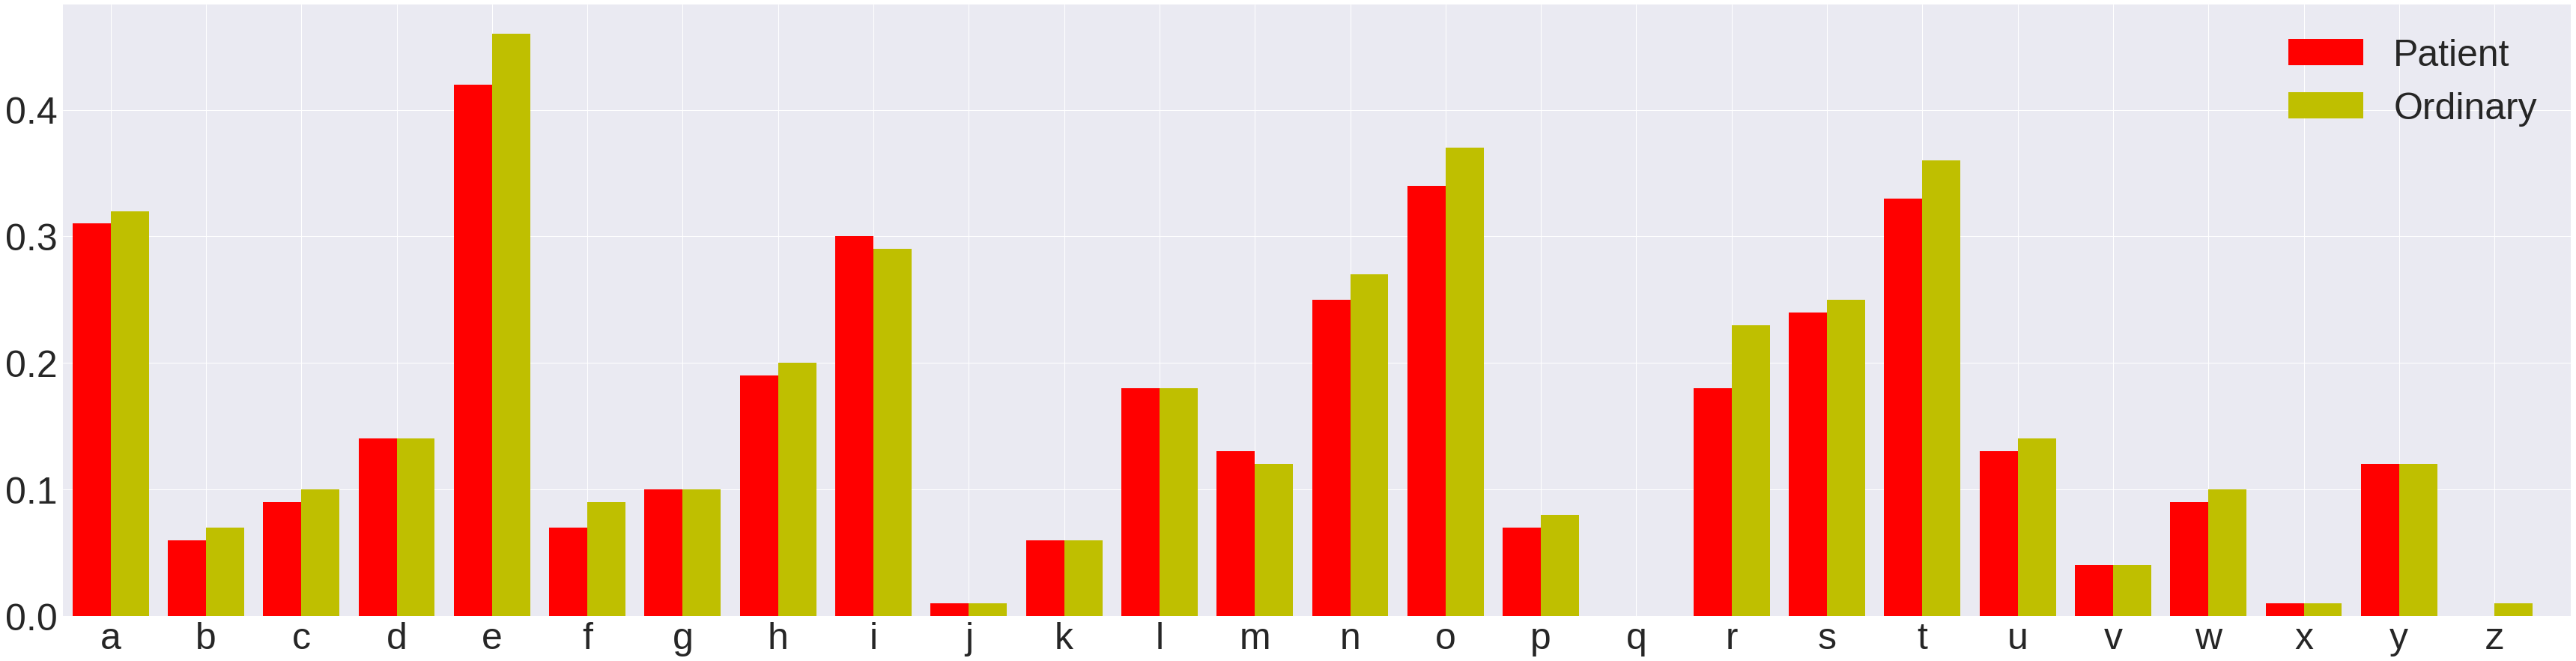

In [113]:
alphabetList = list(string.ascii_lowercase)
baseValues = []
groupValues = []

for alphabet in alphabetList:
    baseValues.append(round(baseAlphabetCounter[alphabet]/baseWordCounter, 2))
    groupValues.append(round(groupAlphabetCounter[alphabet]/groupWordCounter, 2))
      

plt.rcParams["figure.figsize"] = [60,15]
plt.rcParams["legend.fontsize"] = 50

ind = np.arange(len(alphabetList))  # the x locations for the groups
width = 0.4                         # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, groupValues, width, color='r')

rects2 = ax.bar(ind + width, baseValues, width, color='y')

ax.set_xticks(ind + width / 2)

ax.set_xticklabels(alphabetList)
ax.tick_params(axis='x', which='major', labelsize='50')
ax.tick_params(axis='y', which='major', labelsize='50')
ax.set_xlim(-0.3, 26)
ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

# plt.xticks(rotation='vertical')

#     # def autolabel(rects):
#     #     """
#     #     Attach a text label above each bar displaying its height
#     #     """
#     #     for rect in rects:
#     #         height = rect.get_height()
#     #         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#     #                 '%d' % int(height),
#     #                 ha='center', va='bottom')
#     # autolabel(rects1)
#     # autolabel(rects2)

plt.show()
plt.close(fig)

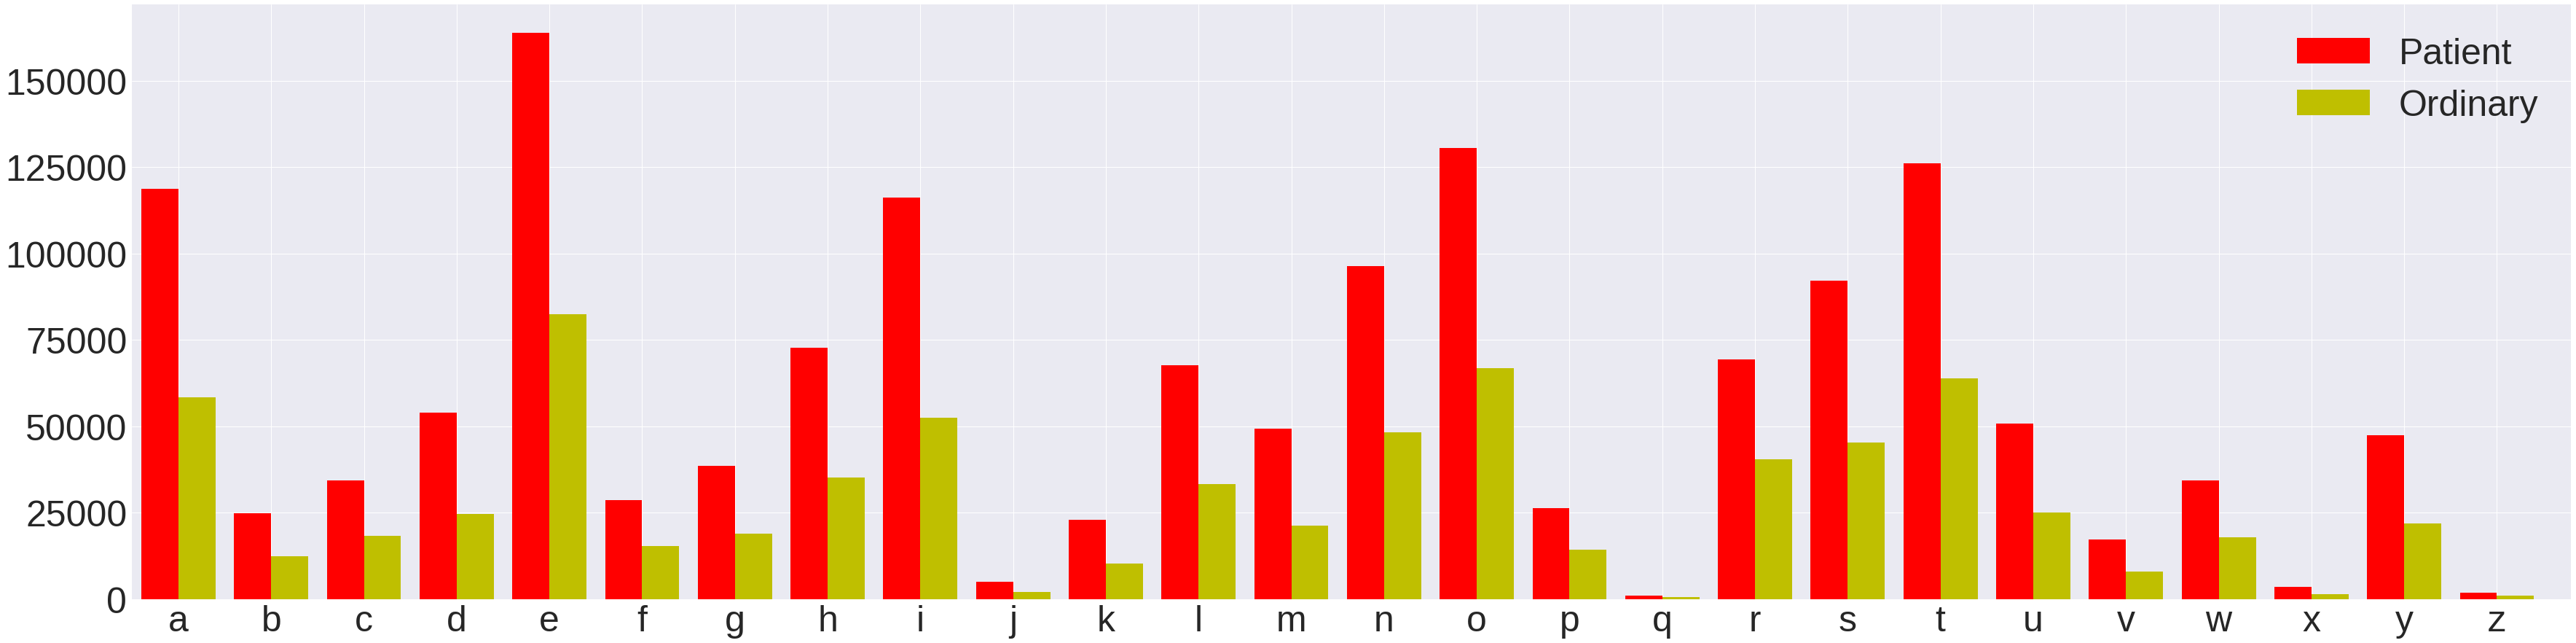

In [114]:
alphabetList = list(string.ascii_lowercase)
baseValues = []
groupValues = []

for alphabet in alphabetList:
    baseValues.append(baseAlphabetCounter[alphabet])
    groupValues.append(groupAlphabetCounter[alphabet])
      

plt.rcParams["figure.figsize"] = [60,15]
plt.rcParams["legend.fontsize"] = 50

ind = np.arange(len(alphabetList))  # the x locations for the groups
width = 0.4                         # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, groupValues, width, color='r')

rects2 = ax.bar(ind + width, baseValues, width, color='y')

ax.set_xticks(ind + width / 2)

ax.set_xticklabels(alphabetList)
ax.tick_params(axis='x', which='major', labelsize='50')
ax.tick_params(axis='y', which='major', labelsize='50')
ax.set_xlim(-0.3, 26)
ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

# plt.xticks(rotation='vertical')

#     # def autolabel(rects):
#     #     """
#     #     Attach a text label above each bar displaying its height
#     #     """
#     #     for rect in rects:
#     #         height = rect.get_height()
#     #         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#     #                 '%d' % int(height),
#     #                 ha='center', va='bottom')
#     # autolabel(rects1)
#     # autolabel(rects2)

plt.show()
plt.close(fig)

In [148]:
def plotAlphabetCounter(groupCorpus, baseCorpus):
    baseAlphabetCounter, baseWordCounter = getAlphabetCounter(baseCorpus)
    groupAlphabetCounter, groupWordCounter = getAlphabetCounter(groupCorpus)
    alphabetList = list(string.ascii_lowercase)
    baseValues = []
    groupValues = []

    for alphabet in alphabetList:
        baseValues.append(round(baseAlphabetCounter[alphabet]/baseWordCounter, 2))
        groupValues.append(round(groupAlphabetCounter[alphabet]/groupWordCounter, 2))


    plt.rcParams["figure.figsize"] = [60,15]
    plt.rcParams["legend.fontsize"] = 50

    ind = np.arange(len(alphabetList))  # the x locations for the groups
    width = 0.4                         # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, groupValues, width, color='r')

    rects2 = ax.bar(ind + width, baseValues, width, color='y')

    ax.set_xticks(ind + width / 2)

    ax.set_xticklabels(alphabetList)
    ax.tick_params(axis='x', which='major', labelsize='50')
    ax.tick_params(axis='y', which='major', labelsize='50')
    ax.set_xlim(-0.3, 26)
    ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

    # plt.xticks(rotation='vertical')

    #     # def autolabel(rects):
    #     #     """
    #     #     Attach a text label above each bar displaying its height
    #     #     """
    #     #     for rect in rects:
    #     #         height = rect.get_height()
    #     #         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
    #     #                 '%d' % int(height),
    #     #                 ha='center', va='bottom')
    #     # autolabel(rects1)
    #     # autolabel(rects2)

    plt.show()
    plt.close(fig)

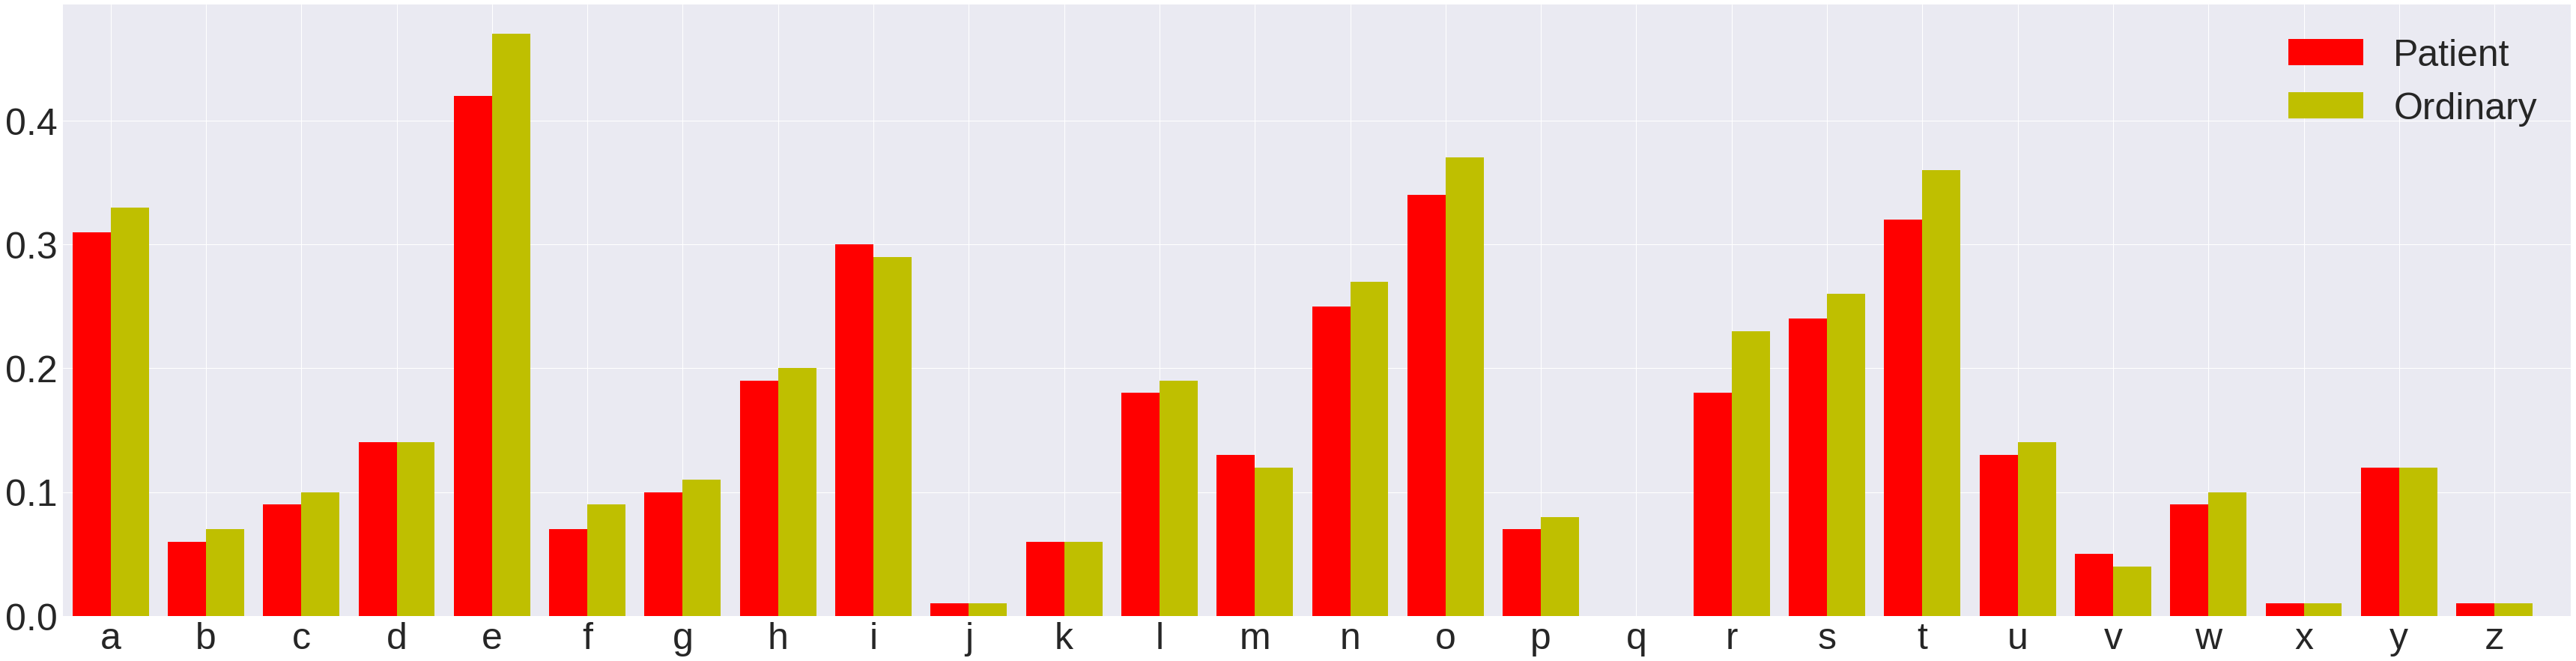

In [149]:
plotAlphabetCounter(groupTextCase1, baseTextCase1)

# Dataset Notes

In [17]:
def tokenize(text):
    text_list = re.findall('(?u)\\b[a-zA-Z]\\w{0,}\\b', text)
    return text_list

In [104]:
def getVowelCount(corpus):
    # symbols = {"ə":0, "eɪ":0, "ɑ":0, "æ":0, "ʌ":0, "ɔ":0, "aʊ":0, "aɪ":0, "ɛ":0, "ɝ":0, "ɪ":0, "oʊ":0, "ɔɪ":0, "ʊ":0, "u":0, "i":0}
    matchSymbols1 = ["eɪ", "aʊ", "aɪ", "oʊ", "ɔɪ"]
    matchSymbols2 = ["ə", "ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɝ", "ɪ", "ʊ", "u", "i"]

    syllableDict = dict()
    syllableWordCountDict = dict()

    progress = initializeProgressBar(len(corpus))
    for i, person in enumerate(corpus):
        progress.value += 1
        progress.description = 'Task {0}/{1}'.format(i+1, len(corpus))
        for tweet in person.split('\n'):
            words = tokenize(tweet)
            for word in words:
                tmpSyms = []
                cmu, ipa = cv.convert(word)
                ipa = ipa.strip(' ')
    #             print(word)
                for syllable in ipa.split(' '):
    #                 print(syllable)
                    symbolFound = False
                    for sym in matchSymbols1:
                        if syllable.find(sym) != -1:
                            tmpSyms.append(sym)
                            symbolFound = True
                            break
                    if not symbolFound:
                        for sym in matchSymbols2:
                            if syllable.find(sym) != -1:
                                tmpSyms.append(sym)
                                symbolFound = True
                                break
                tmpSymsLength = len(tmpSyms)

                try:
                    syllableWordCountDict[tmpSymsLength] += 1
                except KeyError:
                    syllableWordCountDict[tmpSymsLength] = 1

                for i in range(tmpSymsLength):
                    try:
                        syllableDict[tmpSymsLength][tmpSyms[i]] += 1
                    except KeyError:
                        syllableDict[tmpSymsLength] = {"ə":0, "eɪ":0, "ɑ":0, "æ":0, "ʌ":0, "ɔ":0, "aʊ":0, "aɪ":0, "ɛ":0, "ɝ":0, "ɪ":0, "oʊ":0, "ɔɪ":0, "ʊ":0, "u":0, "i":0}
                        syllableDict[tmpSymsLength][tmpSyms[i]] += 1
                        
    return syllableDict, syllableWordCountDict

In [105]:
groupSyllableDict, groupSyllableWordCountDict = getVowelCount(groupTextCase1)

In [107]:
baseSyllableDict, baseSyllableWordCountDict = getVowelCount(baseTextCase1)

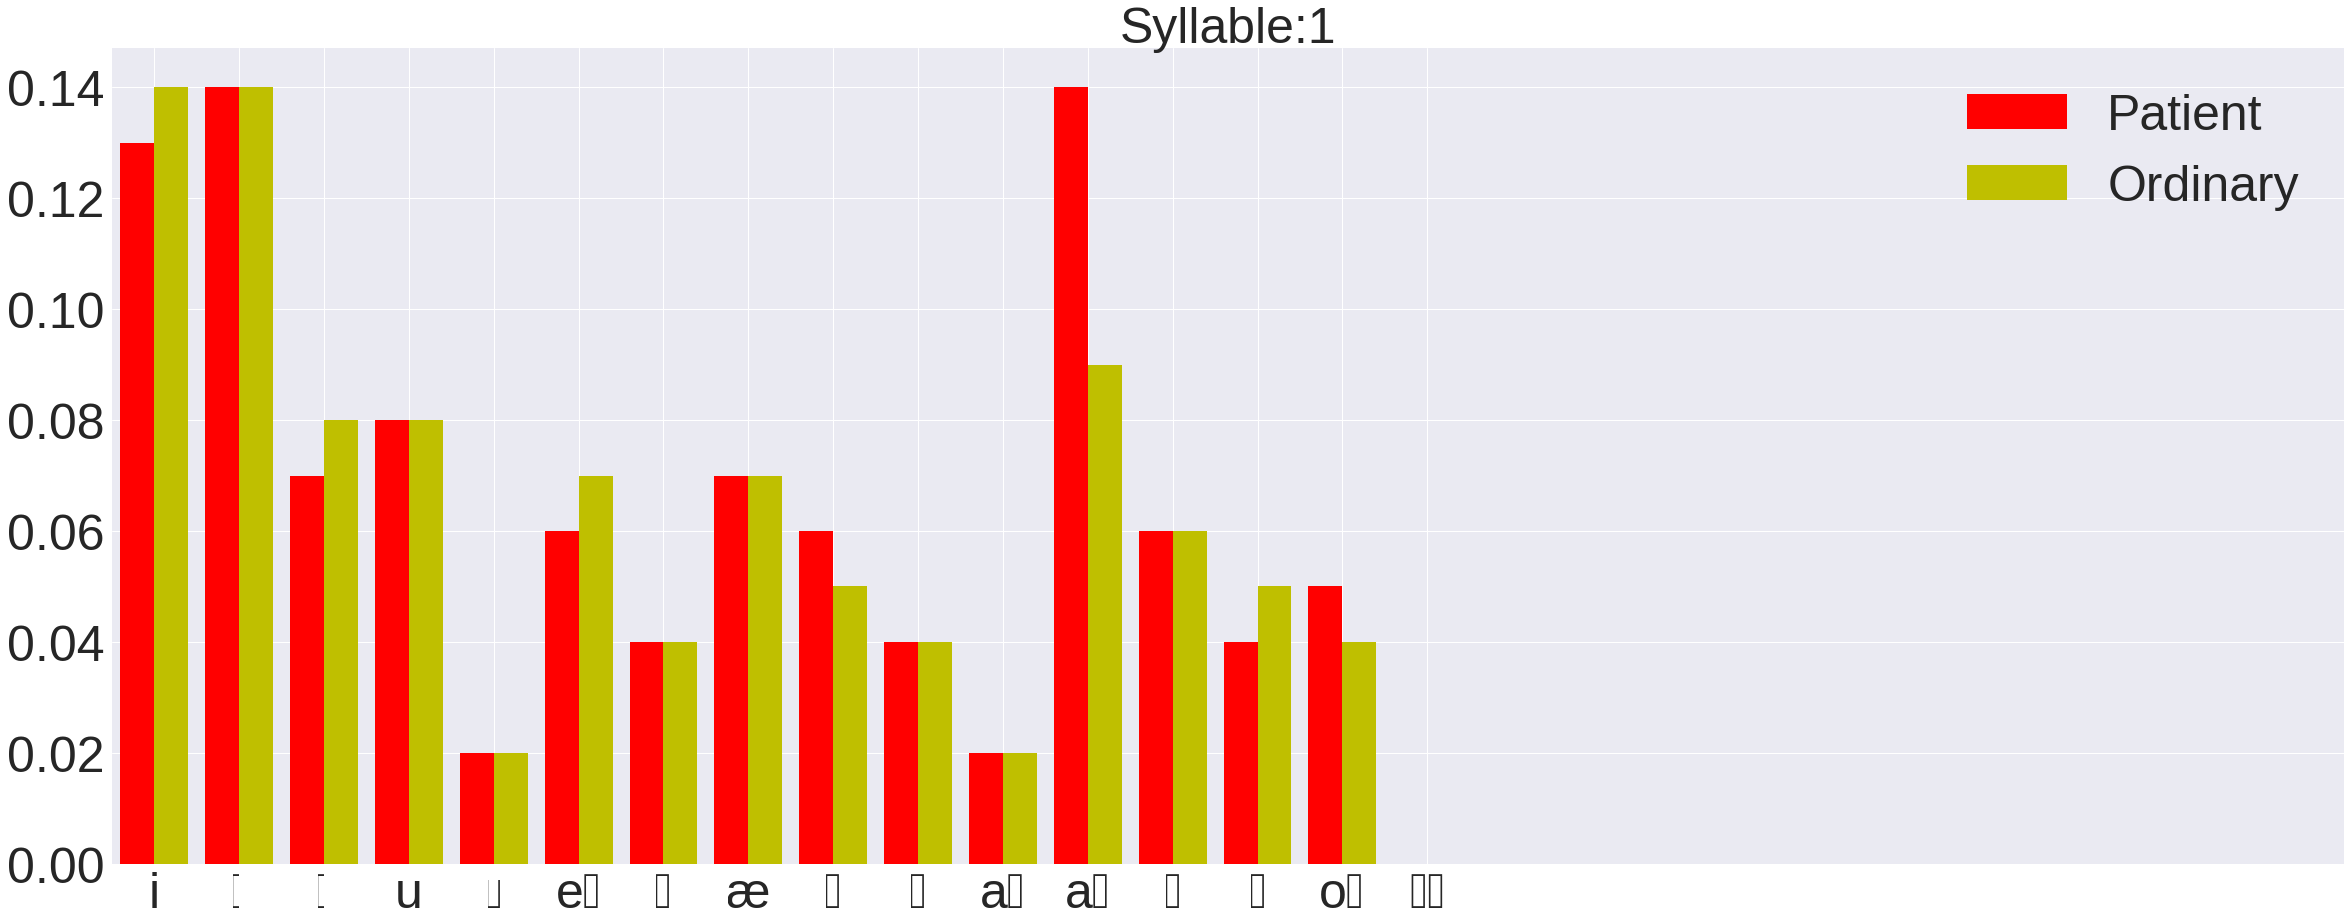

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


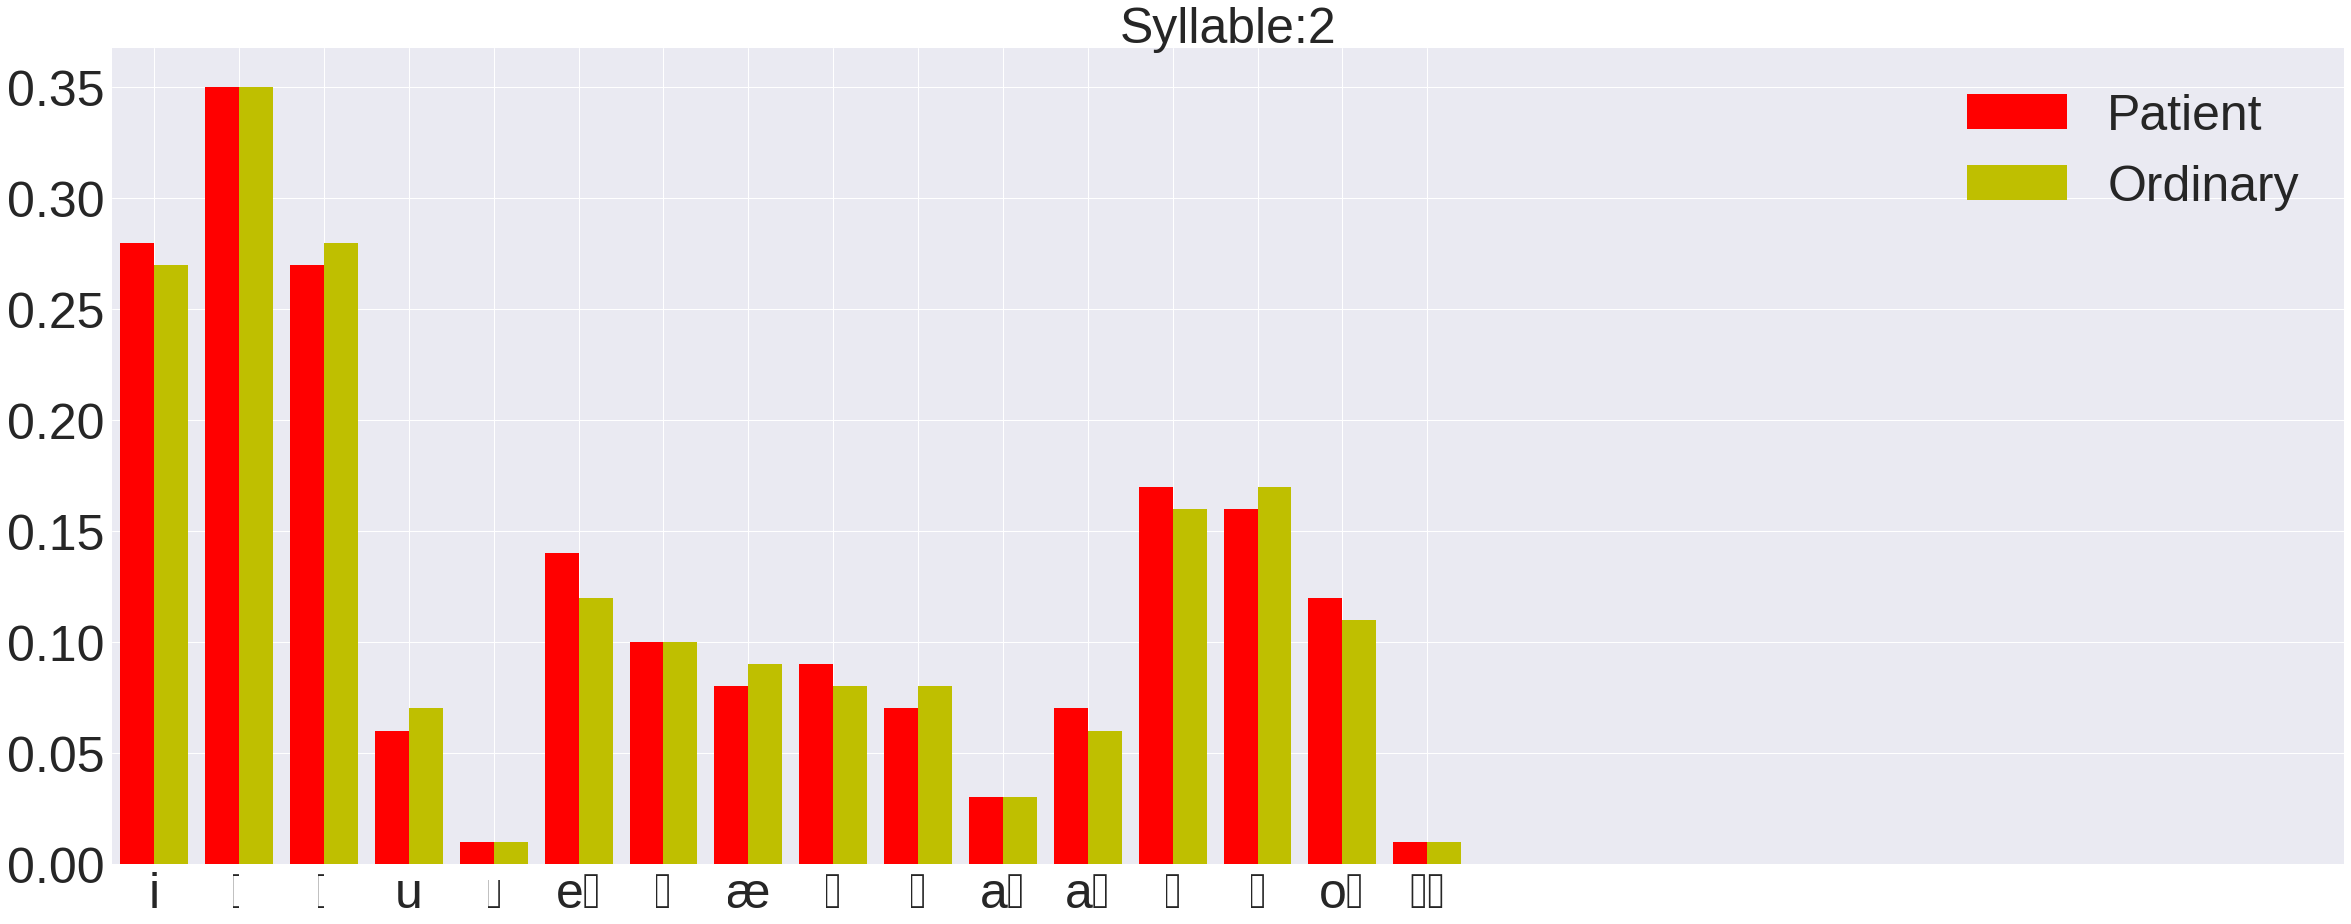

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


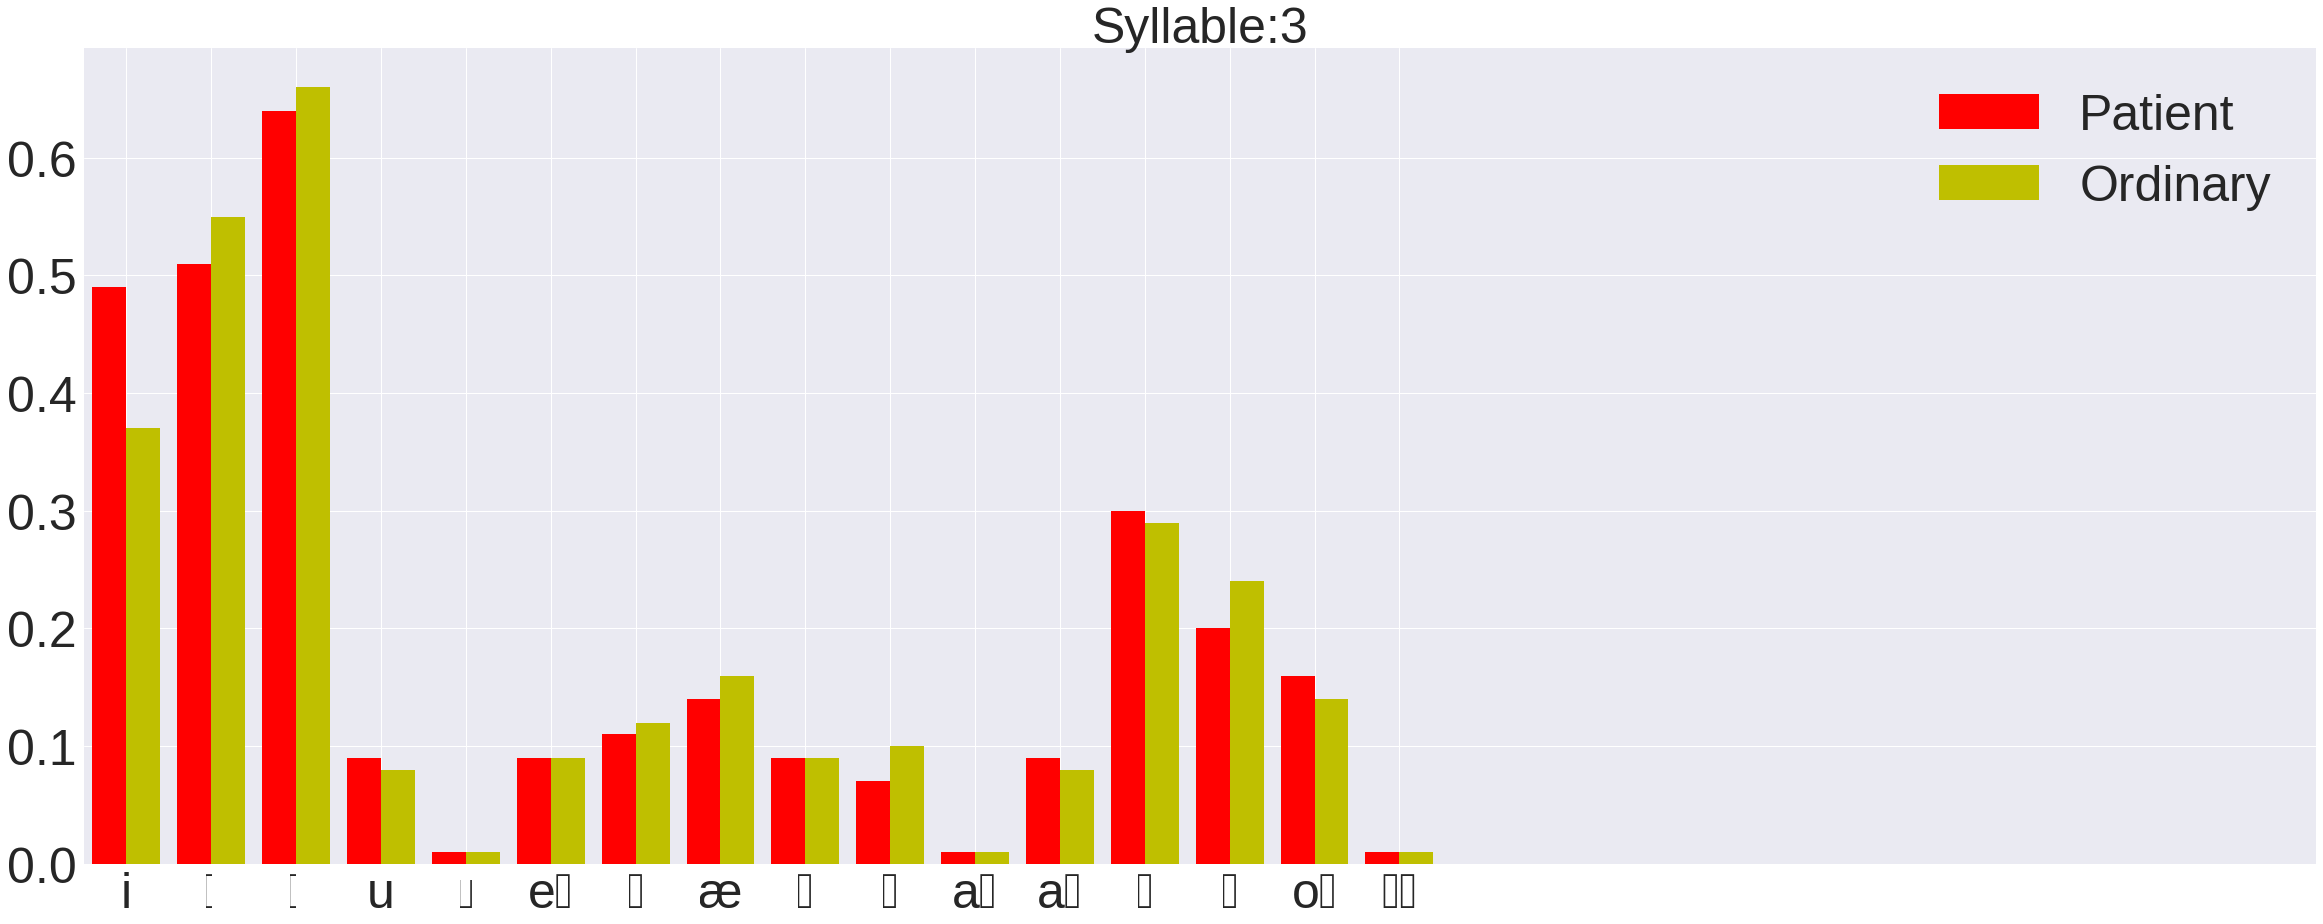

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


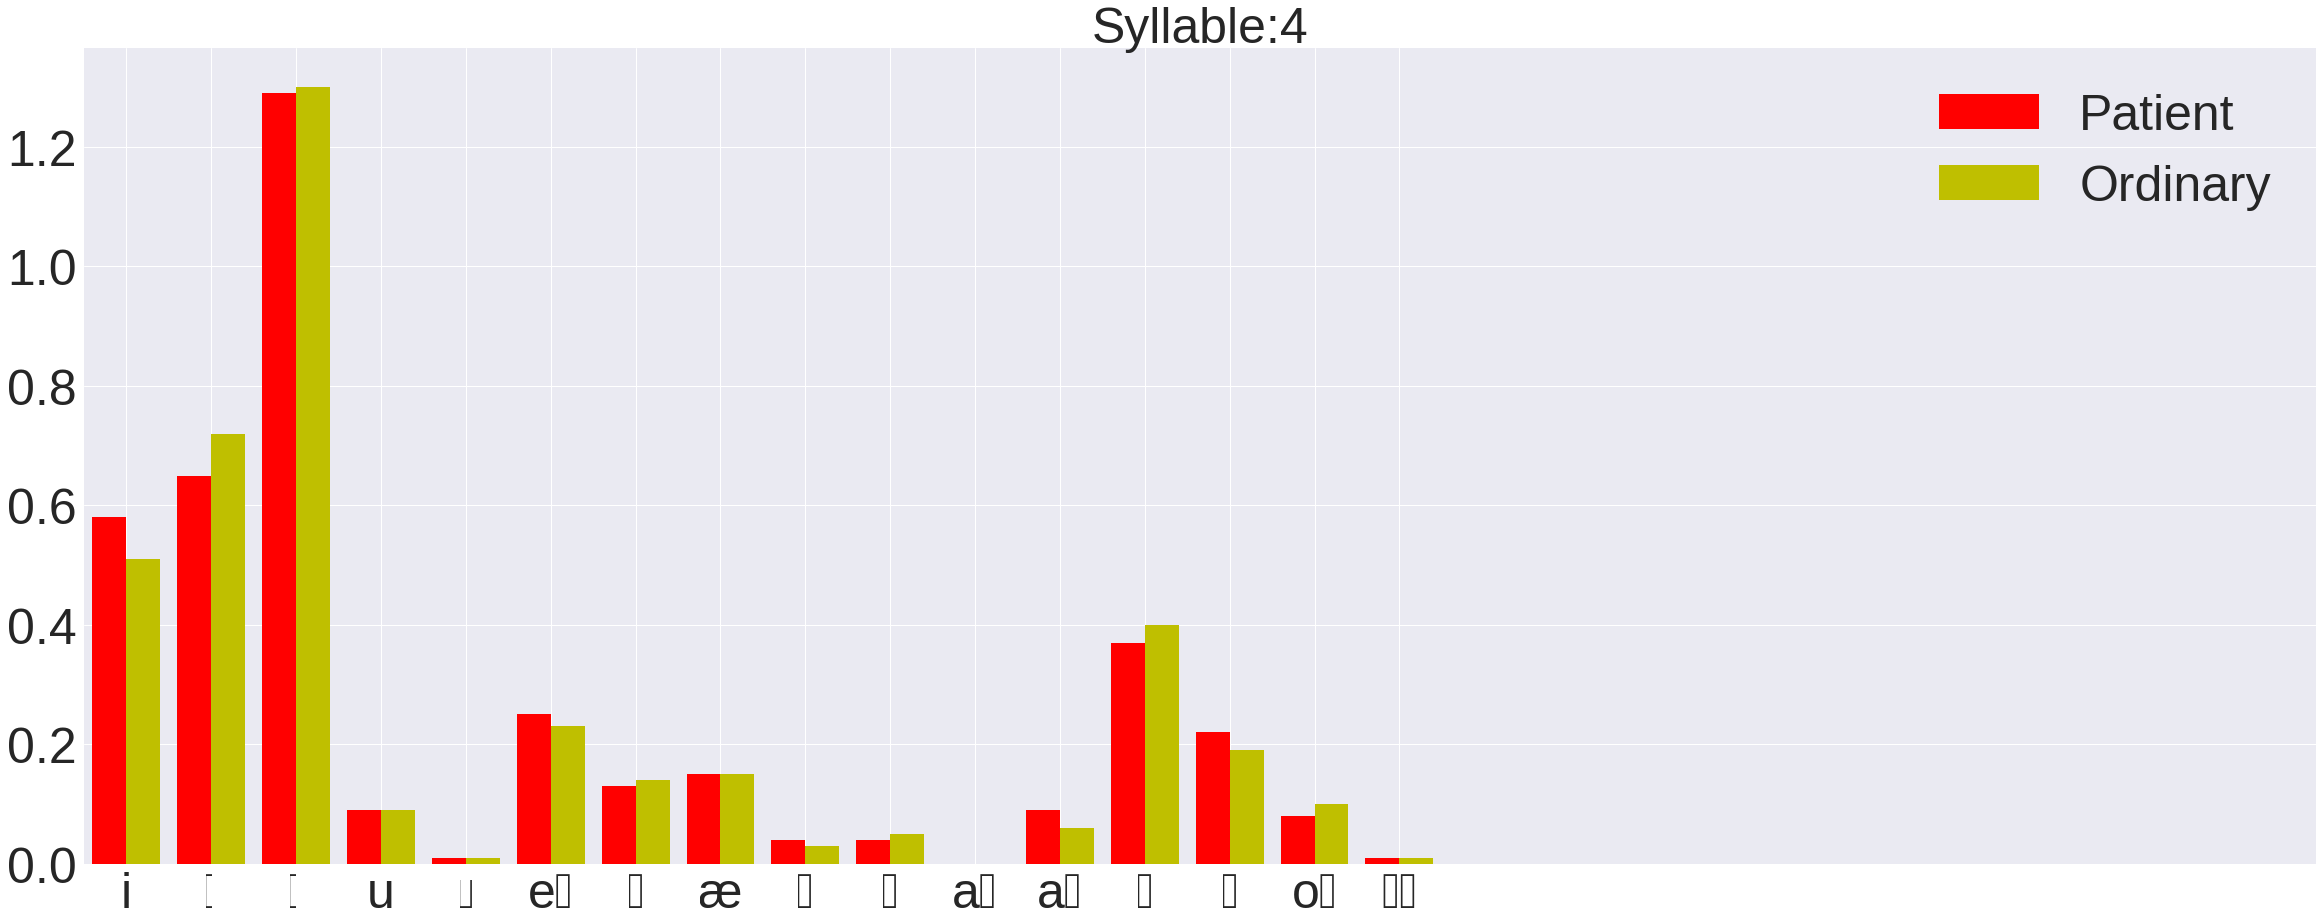

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


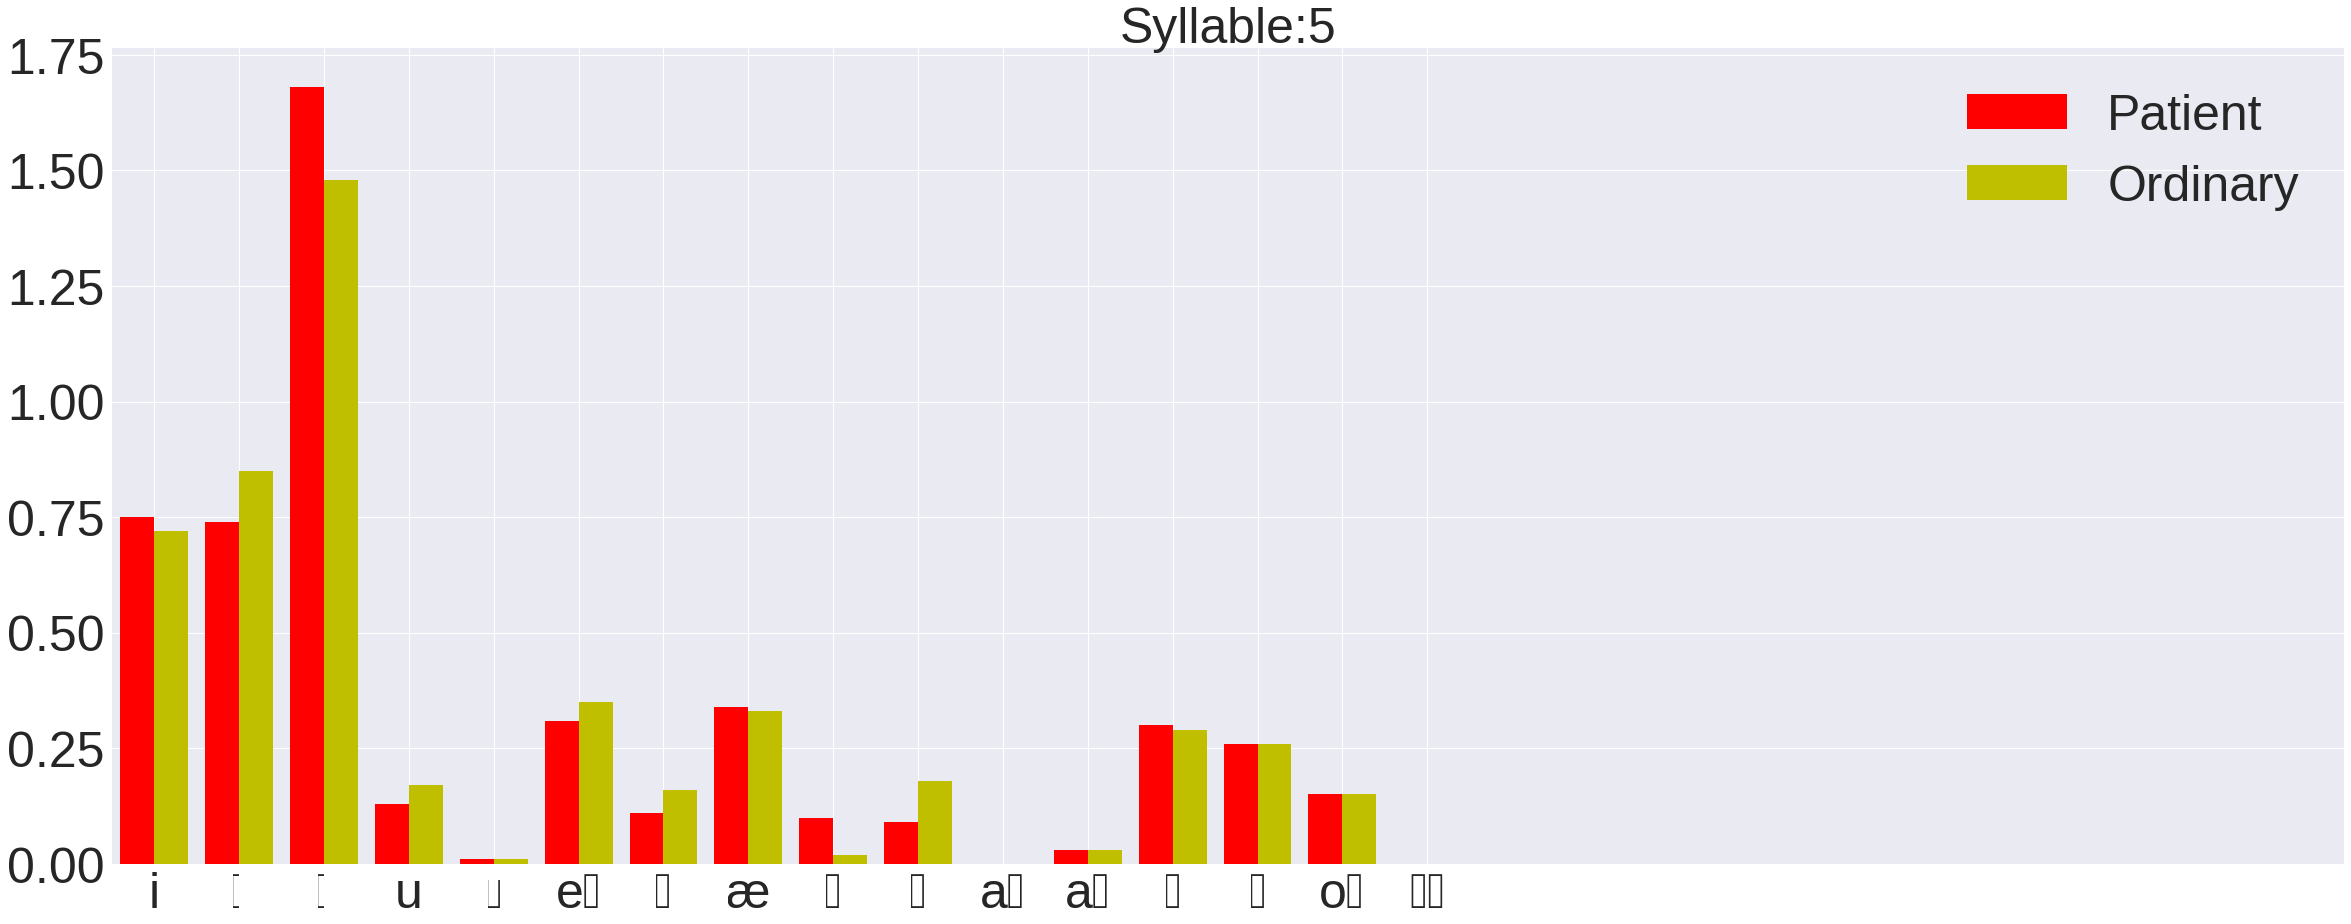

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


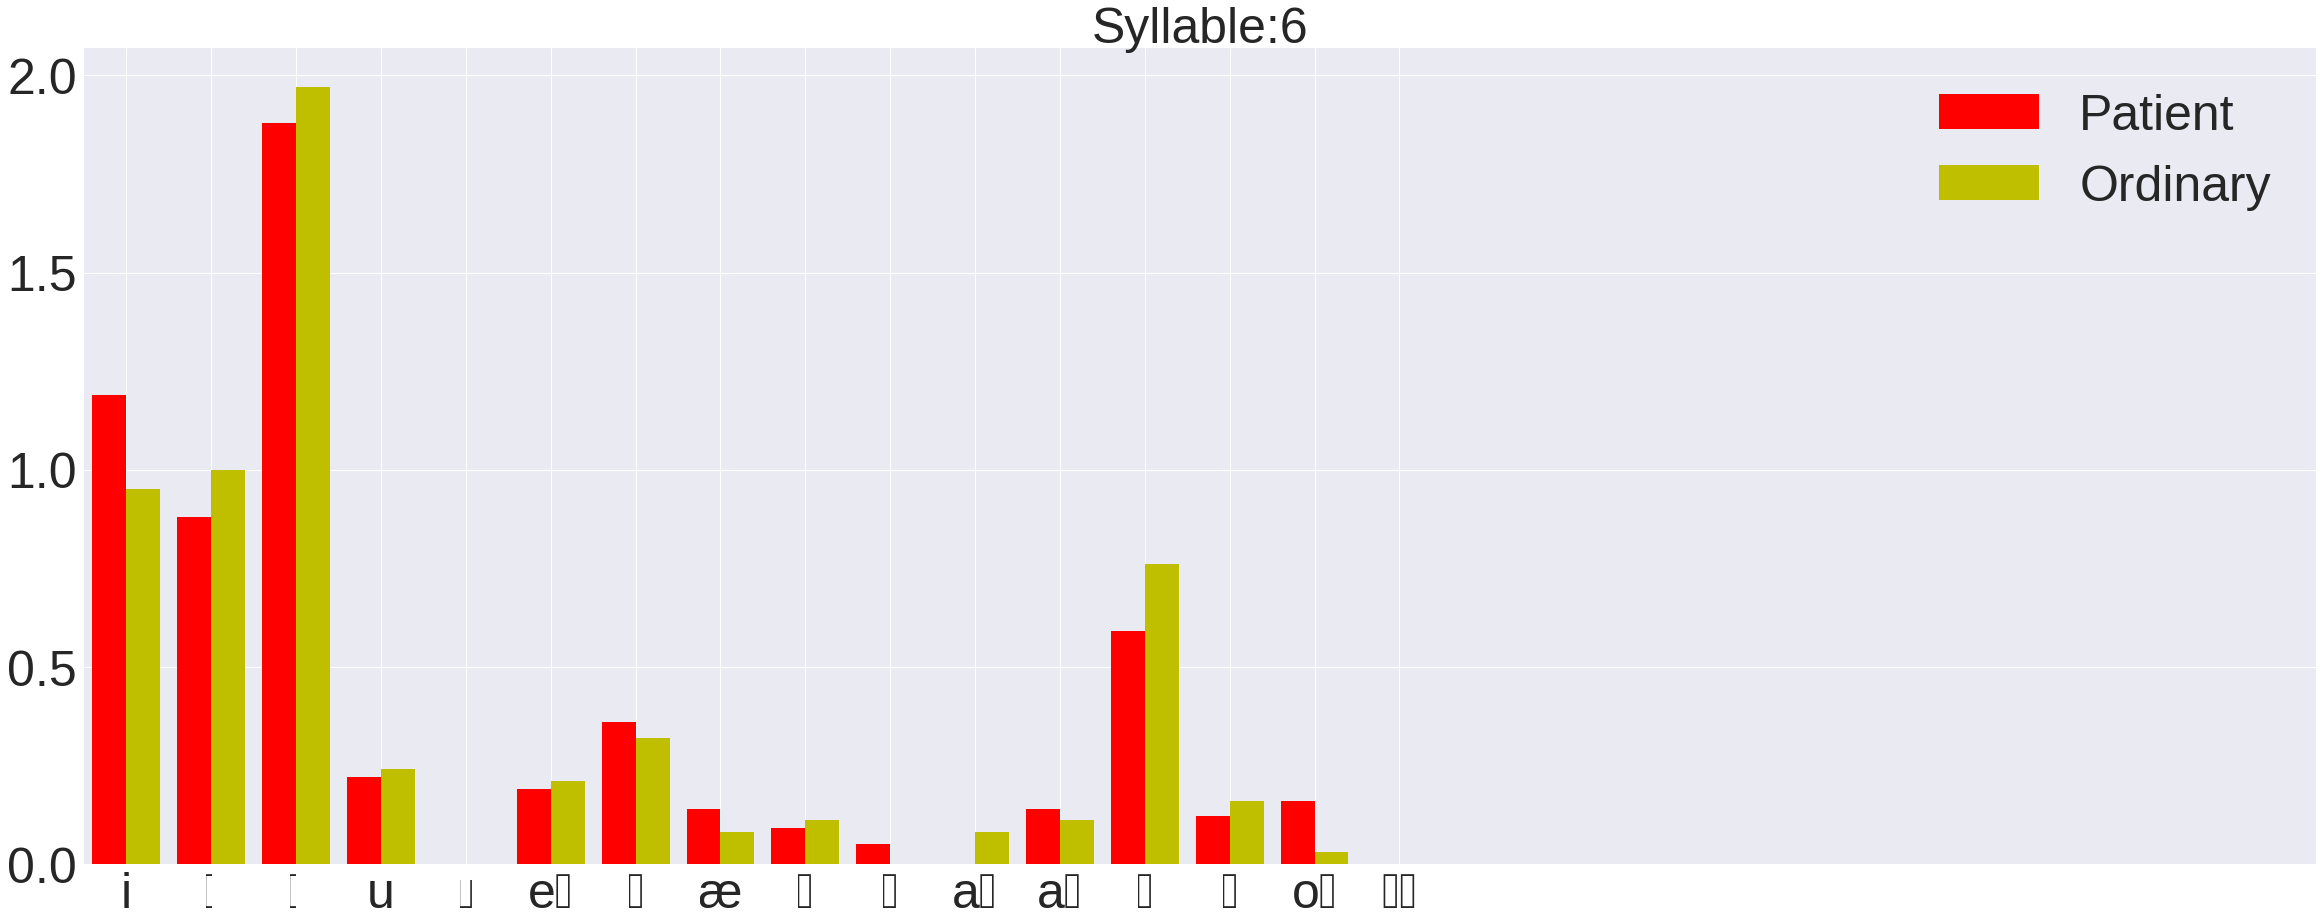

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


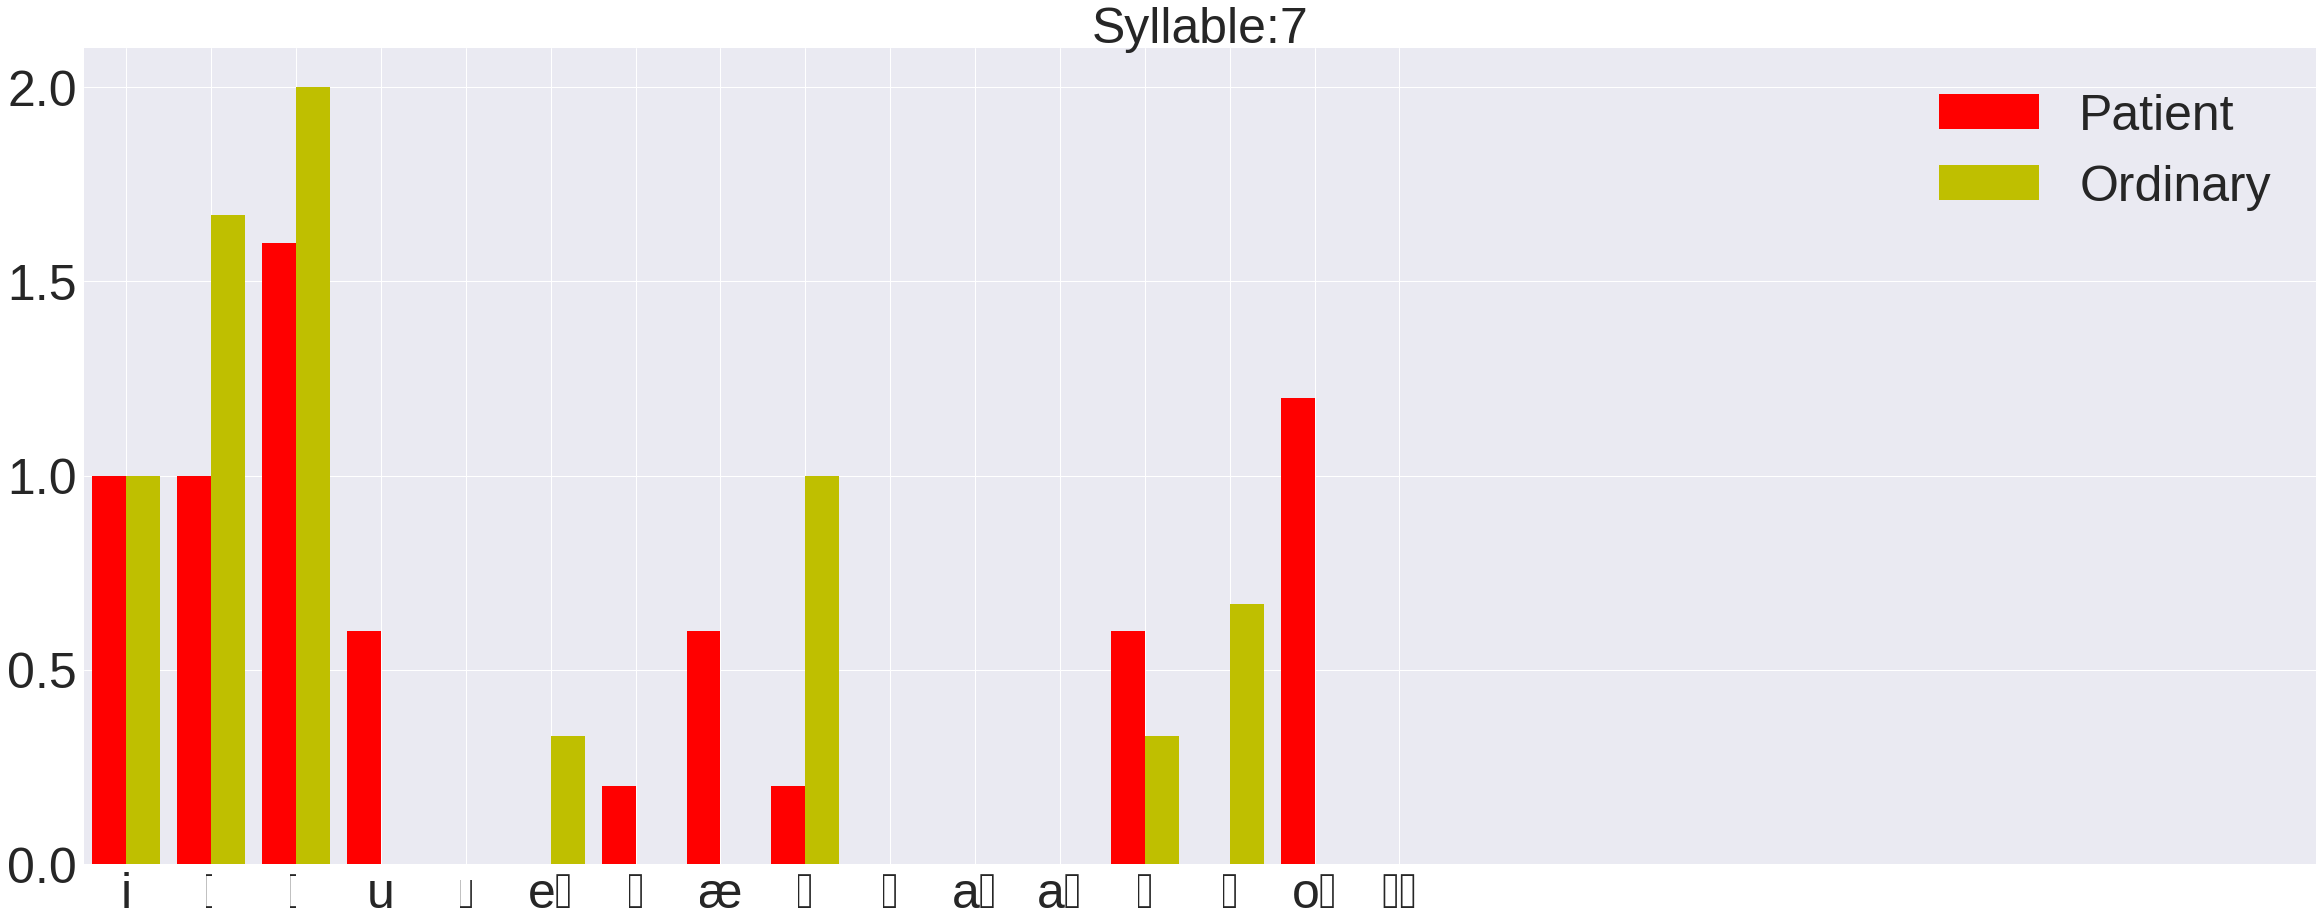

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


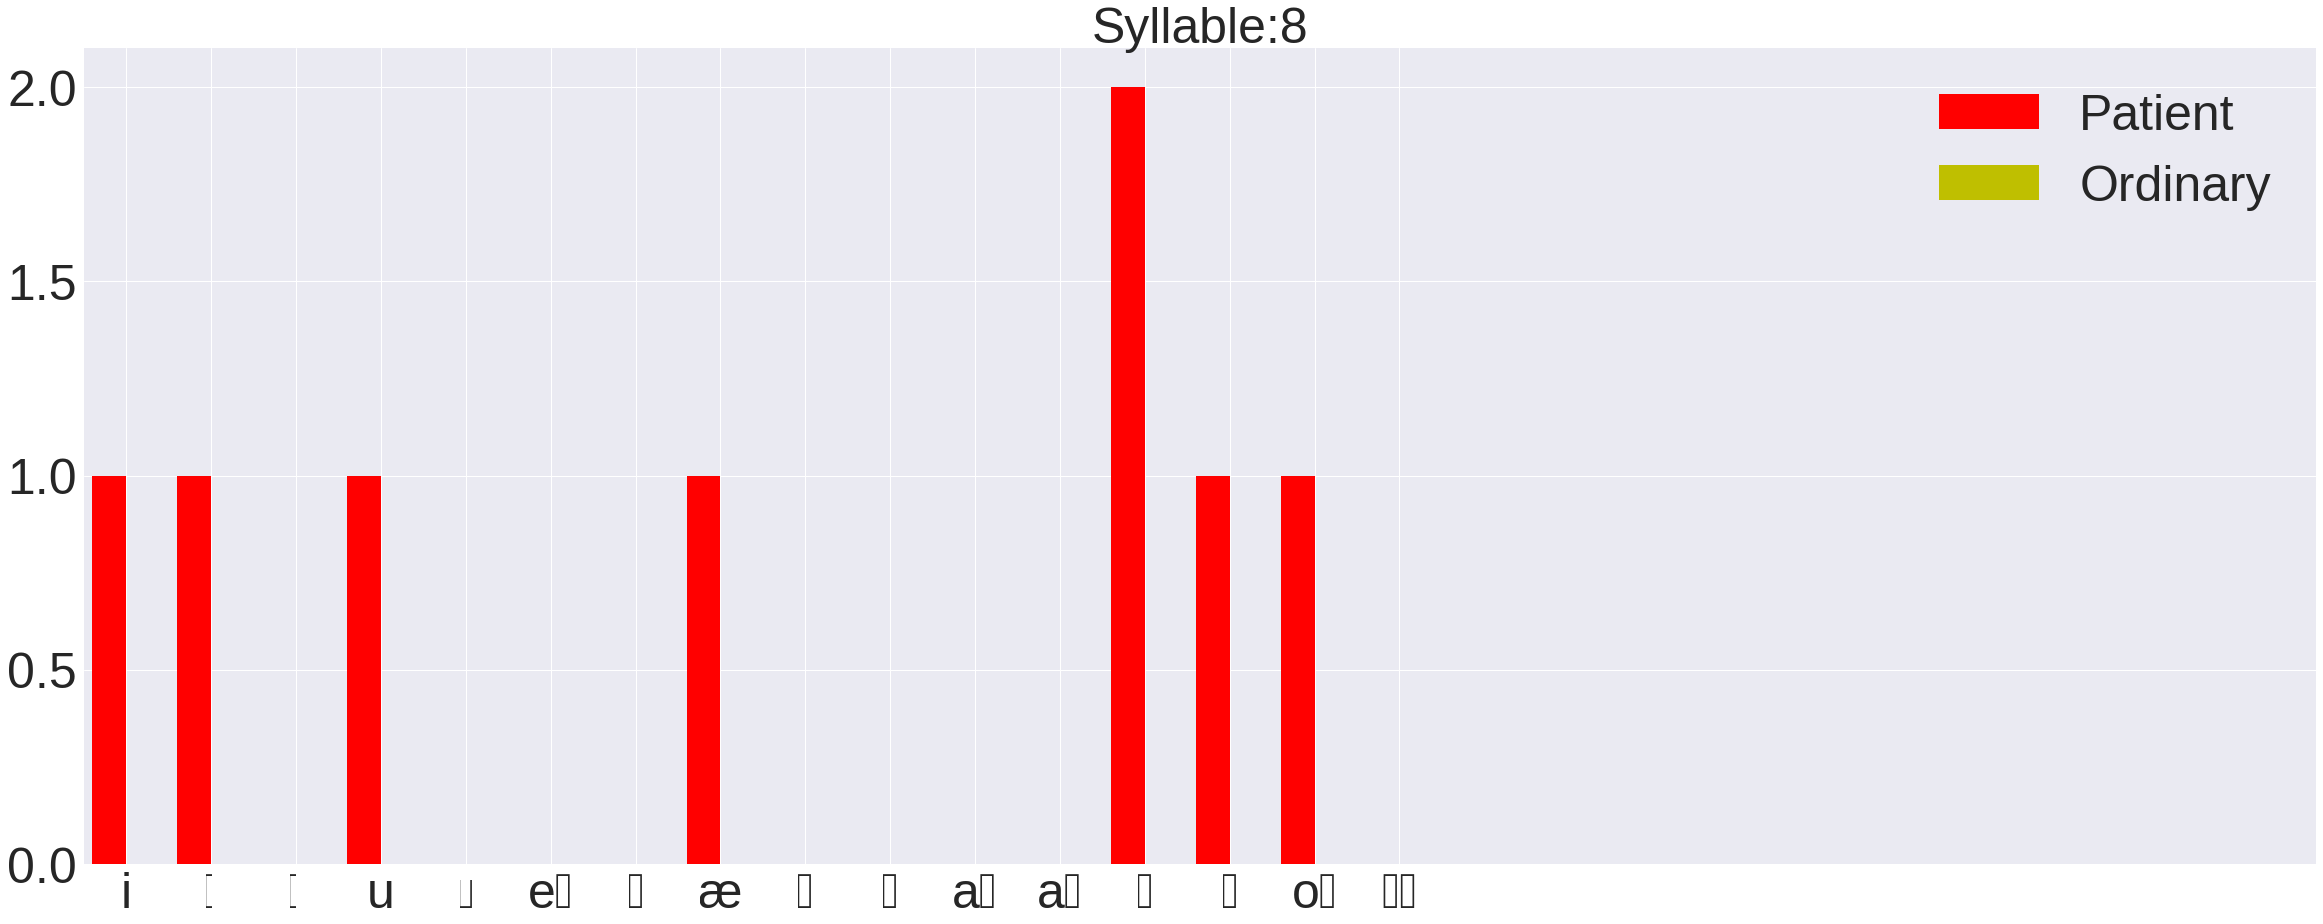

     i  ɪ  ə  u  ʊ  eɪ  ɑ  æ  ʌ  ɔ  aʊ  aɪ  ɛ  ɝ  oʊ  ɔɪ 


In [140]:
# baseAlphabetCounter, baseWordCounter = getAlphabetCounter(baseCorpus)
# groupAlphabetCounter, groupWordCounter = getAlphabetCounter(groupCorpus)
innerKeys = ["i", "ɪ", "ə", "u", "ʊ", "eɪ", "ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "ɝ", "oʊ", "ɔɪ"]



plt.rcParams["figure.figsize"] = [40,15]
plt.rcParams["legend.fontsize"] = 50
_max = max(max(groupSyllableWordCountDict.keys()), max(baseSyllableWordCountDict.keys()))
# _max = 1

for i in range(_max):
    baseValues = []
    groupValues = []
    for innerKey in innerKeys:
        try:
            groupY = round(groupSyllableDict[i+1][innerKey]/groupSyllableWordCountDict[i+1],2)
        except KeyError:
            groupY = 0
        try:
            baseY = round(baseSyllableDict[i+1][innerKey]/baseSyllableWordCountDict[i+1],2)
        except KeyError:
            baseY = 0
            
        groupValues.append(groupY)
        baseValues.append(baseY)
        


        

    ind = np.arange(len(innerKeys))  # the x locations for the groups
    width = 0.4                         # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, groupValues, width, color='r')

    rects2 = ax.bar(ind + width, baseValues, width, color='y')

    ax.set_xticks(ind + width / 2)
    ax.set_title('Syllable:{0}'.format(i+1), fontsize='50')
#     newInnerKyes = [unicode(key) for key in innerKeys]
    ax.set_xticklabels(innerKeys)
    ax.tick_params(axis='x', which='major', labelsize='50')
    ax.tick_params(axis='y', which='major', labelsize='50')
    ax.set_xlim(-0.3, 26)
    ax.legend((rects1[0], rects2[0]), ('Patient', 'Ordinary'))

    plt.savefig('syllable{0}.png'.format(i+1))
    plt.show()
    plt.close(fig)
    print("    ", "i ", "ɪ ", "ə ", "u ", "ʊ ", "eɪ ", "ɑ ", "æ ", "ʌ ", "ɔ ", "aʊ ", "aɪ ", "ɛ ", "ɝ ", "oʊ ", "ɔɪ ")

In [152]:
APPROXIM = 3
BACK = 2
ANTERIOR = 1
###################
LOW = 3
MID = 2
HIGH = 1
###################
STOP = 5
FRICATIVE = 4
LABIAL = 3
CONTINUANT = 1 
###################
RETROFLEX = 3
DENTAL = 2
CORONAL = 1
###################
VELAR = 3
GLOTTAL = 2
NASAL = 1
###################
VOWEL = 1
###################
ROUND = 1
###################
TENSE = 1

In [221]:
eSPEDict = dict()
with open('eSPEPhonologicalTable') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDict[line[0]] = np.array([eval(x) for x in line[1:]])

In [316]:
def getTweetScore(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((19,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDict[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDict[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDict[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [319]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScores = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = np.zeros((20,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScore(tweet)
    groupScores.append(list(score))
#     break

CPU times: user 37.7 s, sys: 532 ms, total: 38.2 s
Wall time: 36.7 s


In [317]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
baseScores = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = np.zeros((20,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScore(tweet)
    baseScores.append(list(score))

CPU times: user 10.3 s, sys: 100 ms, total: 10.4 s
Wall time: 10.2 s


In [324]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifier1 = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScores + groupScores)
Y = np.array([0] * len(baseScores) + [1]*len(groupScores), dtype=int)

precisions = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier1 = classifier1.fit(X_train, Y_train)
    precision = classifier1.score(X_test, Y_test)
    precisions.append(precision)

[ 70  77 271 279 113 195   1 222 156  72   2 154  19 155 278 235 227 208
 183 133 103 121 115  94  45  43 232  48 175 252  46 216 135 274 190   9
  59 259 214  58  66 162 265 111 173 179  32 166 159 176 116  78   7  11
  44  95  91 270 200  15  62 127 104 231  85  87 217  18 258 105 110 189
  83 132 172 240 205 134 261 142 275 165 158  69  35 137 161  29 226  50
 143  71  22  21 136 225  74  90  12 102  37 192  39 256 260 283 157 281
 119  10 203 241  13 138  57  64 147 224 239 171 273 185 145 101  63  56
 264 282 221 213 247 144  52 106 201 284  92 150   6 193 153  41  88  99
 125 234 248  61 277 262 107 167 181 149  34 255 114 223 229  30  42 243
 253  40 188 141 129 108   8 196 178 230  84 187   0 228 268  17  79  60
  54 237  67 177 124 168 254 219 160  25  16  53   3  73 246 197 152  89
 269 194 242 198 285 286  93 191 233   4 215 140  27 251 267 122  28 206
 164  33  23  96 186 257 126  55 263  38 180 146  20 148  47  86 249  65
  82 128  68 139 204 266 123 130  14 163 117 244 10

[138 198  13 153 127  72 191 147 271  78  96 220  98  94 269 263 167 267
 171 177  24 136 146  10  79  14  74 206   2 222 122 158   7 201 242 173
  88 105   3 145   8 200 264 170  28 175 178 268 212  50 179 148 217 196
 108 227 225  44 245 132   0  59  60  71 128  35 285  15 120 187 135 115
  11  92  99  42  85 255  25 280  12  27 281 184 104 188 248  56  21 235
 114 103 273 195 249  46 266 101  83  30 246 134 186 286  84 160  66 156
 137 202  68 172 262  86  22 279 231 182 162  64  29 223 210  40 109 216
 257 283 218 166 237 199 261  49 143 209  70 243  38 185 282  17  51  37
 265  52 107 116  41  19 252 155 239 164  43 284  82 208 253 140 102  81
  63   9  91   5 254 152 247 151 110 251  57 215 112 193 133 180 123 183
  36 213 277 190  95 219 125  77 214 111 276 113  33  34 165 131 150  53
  45  26   4 228  97 174  65 259 272 241 232 129 221 168 117  62 161  89
 256  75 192 250   6 154  76 274 118  16  73  87 100  67 204 240 194 139
 258  69 229 244 126  48 176 238  20  23 130 169 27

In [325]:
precisions

[0.68965517241379315,
 0.7931034482758621,
 0.68965517241379315,
 0.72413793103448276,
 0.58620689655172409,
 0.62068965517241381,
 0.7931034482758621,
 0.62068965517241381,
 0.68965517241379315,
 0.62068965517241381]

In [328]:
sum(precisions)/10

0.6827586206896552

# TEST: 單純用字數

In [329]:
def getWordCountScore(tweet):
    wordCount = 0
    words = tokenize(tweet)
#     score = np.zeros((19,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
    return wordCount

In [338]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScores = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = 0
    for tweet in tweets:
        score += getWordCountScore(tweet)
    groupScores.append([score])

CPU times: user 24.3 s, sys: 56 ms, total: 24.4 s
Wall time: 24.3 s


In [343]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScores = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = 0
    for tweet in tweets:
        score += getWordCountScore(tweet)
    baseScores.append([score])

CPU times: user 7.04 s, sys: 24 ms, total: 7.06 s
Wall time: 7.02 s


In [345]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScores + groupScores)
Y = np.array([0] * len(baseScores) + [1]*len(groupScores), dtype=int)

precisions = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier = classifier.fit(X_train, Y_train)
    precision = classifier.score(X_test, Y_test)
    precisions.append(precision)

[129 267 132 117  88  83  23 214 204 115 229 146 195 126 216 238 164  32
  12  20  53 232  64  19 162 247 137  74 118 131 218 264 169 114 215 172
 100 161  82  67 244  93 259 228  13   1  95 160 178 109  61 282 152 144
  85 274 143  73  68 271 149 243 103 210 177   5 219  55 120 235 167 106
 133 108 191 145   4  76 262 268  40 128  11  63 254  94 277 107 124  41
 192 155 284 225 265  98 119 256   2 190 165 203 251 153 279  56   8  27
  15 105 183 156  71 200 221   0 159 206 212 186 286  25  81 230 139  80
 283 116 147 170  78 187 163  33   3  84 123  36 278 281 197 263  22 231
 202 207 258  77  86 285 174 223  26 185 193 101 104 266 141 198 242 257
   7 140  75 199  46 241 237 184  62  91 272  16 150 157 134  58  52  18
 208   6  66  65 275 261 176  42  72 239 205  90  50 280  10 234 213  47
 127 158  31 269 245 220  17  21  51 250 168 111  70  69  92  37 233  97
  35  43 211 222 209 125 224  44 252  24 135 181 130 173 166 154   9  89
 113 226  49  87 175 142 249  60  14 236 110  57 19

[273  47 177 189 221 182  93 279  71 157  58 191  74 255 125 271 107 251
  57 128 219 208  65 190  44 217 179   9 246 184 239 210 223 113 232 228
 131   5  62 241  48 207 172  10 100 151 253  87  80 158  50  38  99 163
  94 150 121  55 274 101  12 186 269 129 257 268 183   8 285 188 118 197
  69  40 192 230  90 277 263 133 247 215  43   7  75  89  28 102   4 136
 161 211 280 112  84  61 286  46  86  13  66 231 109 206 105 149  77 256
 176 141 175 165   1 220  35 216 195 281 265  53 152 258  59 185 178  14
  30   0 202  39  79 147 201 110 205 159 155 249 108 193 154 227  67 156
 266  22 196 137 240 139 123  33 213 111 160  20 236  25 261 132 218   6
 226 146  63  42 272 167  34 164  81 225 130  83   2 252 238 264 283 254
 148 242  91 181  49  85 214 209 143 174  23  15 259 169 234 119 180 138
 235 284 200 203 262 275  68 244 166 243 103 237  16 204 145 194  88 116
 124  95  27 120 233  72 135 104 267 140  56  70  98   3  37  29 229 199
 170 212  19  32  31  41 222  60 278 117  54 126 14

In [346]:
precisions

[0.55172413793103448,
 0.58620689655172409,
 0.62068965517241381,
 0.55172413793103448,
 0.65517241379310343,
 0.68965517241379315,
 0.65517241379310343,
 0.55172413793103448,
 0.62068965517241381,
 0.72413793103448276]

In [347]:
sum(precisions)/10

0.62068965517241381

# TEST: 單純用發文數

In [348]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScores = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = len(tweets)
    groupScores.append([score])

CPU times: user 192 ms, sys: 12 ms, total: 204 ms
Wall time: 201 ms


In [349]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScores = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = len(tweets)
    baseScores.append([score])

CPU times: user 200 ms, sys: 16 ms, total: 216 ms
Wall time: 215 ms


In [350]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScores + groupScores)
Y = np.array([0] * len(baseScores) + [1]*len(groupScores), dtype=int)

precisions = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier = classifier.fit(X_train, Y_train)
    precision = classifier.score(X_test, Y_test)
    precisions.append(precision)

[128 150 244  39 153 256 223 199 118 165 119  81 110  92 228 191   4 135
  41 225 163 263  17  89 117  91 197 126  40 226 230  77  43 113 202  21
 101   9 129  66 251 270 112 182 154  87  61 141 218 172   7  97  71  31
  79 267 173  64 260 179 167 138  75 250 108 188 139  16  94 220  49 211
  95 274  36 240   6 215 232  85  35  54   2 196 235 264  68  76 282  62
  38  12 130  90 195  59 279 236 187 241 281  78 238 144 283 178 200 152
 227 134  80  23 229  24 198  15   0 242  74 201 100 213 123  69  98 146
 234 259   3 233 265 205 171 275 255 245 164 156 254  58 285  44 249  50
  26 277 159 132  63 169 174 121 148  70 193 272 212  55  72  42 103  32
  34 177 136 107 284 224 239  18  82  25 114  10  28 189 246 219 122 261
 137 162  19   5  30 257 131 222  67  13 221  73  20 160  84 231  27 111
  53  57  37 266 280 181  88 252   8 253 175  48 157  86 243 145  51 186
 258 262  47 247 106  45  22 217 208 125  14 120 127  83 142 185  11 161
 166 286 273 115 102  46 176 203 194 190 151 109  3

[177 272 120 125 137  48  53  67 142 175  92 162  35 245 164 246  19   3
  73  10 146 102 170  50 183 178 150 141  70  93 198  22 201  63  46  62
  49 107 258 235 205 138 123 126 185  72 270 124 159 206 100  20 225 128
  59 111 174 194 152  12  42 267  47 273 168 135  69 280  99  15  27  81
 259  26 248 153  71  68  39  56 166  64 247 251 223 158 190  98  74 136
  83 281 197   0 210   5 189 203 122 234 219 232  61 192 101   6 252  97
 257   1  16  65 237 283 172 228 196 154 204 241 180 127 155 229 269   8
 218 173 148  85 211 230  36 244 240 179 227 151  95  89 112 171 209 286
  77 224  21  32 118  25 132 216  43 191 199 268 217 261 182 233  54  78
 266 119 133  30 285 243  94 254  23 108 276  57  82  17 117  37  34 109
  76  96   4 275  80 143 115 256  87 239 187 114 131 169  24 274  14  79
 250  86 139 215 238 186 156 264 129  51 160 255 202 121 262 236 167 116
 147  91 176 140 157 105 207 165  13 249  58  41 195  11 144  88  29 265
 222 263  75   7 220  28 110 181 213 163 130 200 25

In [351]:
precisions

[0.65517241379310343,
 0.62068965517241381,
 0.62068965517241381,
 0.75862068965517238,
 0.72413793103448276,
 0.72413793103448276,
 0.51724137931034486,
 0.62068965517241381,
 0.65517241379310343,
 0.72413793103448276]

In [352]:
sum(precisions)/10

0.66206896551724137

# 字數+發文數量

In [353]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScores = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    num = len(tweets)
    score = 0
    for tweet in tweets:
        score += getWordCountScore(tweet)
    groupScores.append([score, num])

CPU times: user 24.4 s, sys: 8 ms, total: 24.4 s
Wall time: 24.4 s


In [354]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScores = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    num = len(tweets)
    score = 0
    for tweet in tweets:
        score += getWordCountScore(tweet)
    baseScores.append([score, num])

CPU times: user 6.9 s, sys: 4 ms, total: 6.9 s
Wall time: 6.93 s


In [355]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScores + groupScores)
Y = np.array([0] * len(baseScores) + [1]*len(groupScores), dtype=int)

precisions = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier = classifier.fit(X_train, Y_train)
    precision = classifier.score(X_test, Y_test)
    precisions.append(precision)

[250 184 238  48  14 235   9 199 281  18  89 223 100 163  94 124 151  44
 229 132 121 129 243  93 187  11 102 128 127 150  16 153  17 248 103 164
 208  20 115 130 195  71 270 113 221  32 245  15 257 110  45  75  80  25
 244 249  36  39  19 197 123  98  72  79 156 154 232  61 183 209 126 149
  77  95  34  82 107 181   2 278  23 147 177  66  53 134  78 145 101 173
  24 216 122 233 275  22 138  84  63 185 264 220 186 180  62   1 157 133
 140 188 283  31   4 261  46  76 142 211 176 108 160 125  35  12 276  28
 106 172 254 231  54 120 222 260  55  57  29  56  47 241   3 237 192 262
  37 217 236 280 269 159 148  42 255  81 272 119  67 193 201 111 252 152
 210 146 256   7  92 169 179 226  30 263 161 259 285 141  85 171 218 196
 198 117 155  87 225 137 114 112  73  86 158 284  90 175  40  91 191 215
 170  65 228 277 135 116  99 286  41 242 118  60 265  50 204 178  88 162
 144  58 182  59 136 139  96  13 190   6 174 234 266 202 105 273  69 230
 282 219 279 104 274 253  26   8 239 267 109 251 20

[ 75 193 212 154 182 239  98 258 100 244 262 268  58 139 231 178  18  83
 161  50 278 247  91 267 122 226 195 269   1  35  36 233  51 187  85 248
  65 205 236 270 273 160 230  84 142  71  45  28  49 276 257 155   9  20
 251 173 112  68  39 282 219  60 241 105 215  99  93 121 167  22 138 254
  19 192   7  87 285 202   5 265 188 126 132 177  48 135 134 143 111 223
   6 199 266 165   2 277  86 137  74  52 115  10  82  70  30 102 203  14
  17 180 234 164 227  33 189 150  16  57 103 101 163 104 218 153 198 125
  55 140  32 253 229 280 181  77 213 200 279 242 222 245 170 204 151  11
 148 197 118  88   3 183 243 207 152  31 221  43 274  61 184 209  41 208
  56 171  72  40  80  90   0 176 210 168 174 206 224 119  26 263 162 127
  15 124  53  12 130 191 166 240 186 172 109  47  92 283  63 131  69  25
 159 147 169  62 194 116 106 275 252  59  95 264 250 281  46   8 271 136
 144 141 286 120 235  73 237 256 246 259   4 108 145 117  78 225 185 190
  97  42  29  66 255 123 232 114 128 217 238  13 12

In [356]:
precisions

[0.55172413793103448,
 0.55172413793103448,
 0.51724137931034486,
 0.72413793103448276,
 0.58620689655172409,
 0.7931034482758621,
 0.72413793103448276,
 0.62068965517241381,
 0.75862068965517238,
 0.68965517241379315]

In [357]:
sum(precisions)/10

0.65172413793103456

# 0/1

In [358]:
APPROXIM = 1
BACK = 1
ANTERIOR = 1
###################
LOW = 1
MID = 1
HIGH = 1
###################
STOP = 1
FRICATIVE = 1
LABIAL = 1
CONTINUANT = 1 
###################
RETROFLEX = 1
DENTAL = 1
CORONAL = 1
###################
VELAR = 1
GLOTTAL = 1
NASAL = 1
###################
VOWEL = 1
###################
ROUND = 1
###################
TENSE = 1

In [359]:
eSPEDict01 = dict()
with open('eSPEPhonologicalTable') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDict01[line[0]] = np.array([eval(x) for x in line[1:]])

In [361]:
def getTweetScore01(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((19,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDict01[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDict01[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDict01[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [362]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScores01 = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = np.zeros((20,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScore01(tweet)
    groupScores01.append(list(score))
#     break

CPU times: user 37.9 s, sys: 388 ms, total: 38.3 s
Wall time: 37.1 s


In [363]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
baseScores01 = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = np.zeros((20,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScore01(tweet)
    baseScores01.append(list(score))

CPU times: user 10.5 s, sys: 148 ms, total: 10.6 s
Wall time: 10.3 s


In [365]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifier01 = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScores01 + groupScores01)
Y = np.array([0] * len(baseScores01) + [1]*len(groupScores01), dtype=int)

precisions01 = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifier01 = classifier01.fit(X_train, Y_train)
    precision = classifier01.score(X_test, Y_test)
    precisions01.append(precision)

[ 23 198 124 147 152   6   7  47 148 121 203  22 201  31  14 236 283  39
  16  75 195 277 267 200  59 164 173 286 196  41  60 154 263   0 150 243
 193  61 229 101 274 185  45 132 234 202 128 127  71 111 251 120 162 104
  93 155 165  67 113 279  63  56 260 134 103 285 197 210 192 256 160 116
 248 217  34 157 199 137 247 276  96 140  82 224 240 171 183  91 138  10
  92  32 204 108  84 208  40 222 161 205   5 163 117  73  17 178 237  49
 253  74 131  94 280 284 213  65   1 119  64 254  20  48 187 233 239 242
 275  28 209  33 146  98 255 136  66 272 102 180  55 135 188  13 105 122
 176   3 241   4 181   8  42  69  50 141 189 126 194 245  88  80 139 226
 125  11 258 218 282 228 107  27  72 264  51 281 174 223 246 238 112 133
 118 145 143  53  38 230 153 257 182 144  43  29  46 191   2 227  37 261
 250 179 214  85 235 270  68  83  24 190   9  54 220 123 177  62 225 273
 219  44  78 266 167  30 142 244 106  90 149 159  57 212 156 206  79 232
 168 175 109 114  26 221 262 186  89  95 110  35 21

[ 45 199 153 119 187 266 142 168 150  20 177 178 123 201 155  67  85  41
 279  23  60 110  89 254  30   2 268 247 245 111 211 195 265 102 213  98
 128 271 190 269  77 151  87  11 210 144  91 108 138 117 180 141  58 263
  13  88 103 253 161 285  14 118 115   8 217  46 185 170 216 206 114   3
 203 264 154 131 120 149  22  29 165 194 223 270  38 122  25 236  95  94
  86 146 101 152  83   9 261 136  62 228 148 116 104 198 181 205  57 267
  81 246 255 220 113  65 241 175 284  53 160  61  59  84 218   7 173  55
 100 112  76  33 189  35  15 169 272  56 277 282 226 202 224  52 133  12
  27 200 109 197  18 283  63  16 207  49 209 134 240 158  73 132 260 227
 225 275  51 208  17 278 212 125 105 242  96  79 167 126  71 106 159  40
  34 251 127 257 219 244 176  21 162  48 222 121 193 171 273 124   6 129
  99  31  66   5  68 179 286 137 135 166 231 157   0 172  24 250 281 229
 147 221   1  32 239  93  72  54  64 235 232 252  92  78  75  50 143 256
  82 234 163 237 276 204  26   4 182 230 280 183 25

In [366]:
precisions01

[0.7931034482758621,
 0.65517241379310343,
 0.55172413793103448,
 0.58620689655172409,
 0.75862068965517238,
 0.68965517241379315,
 0.68965517241379315,
 0.65517241379310343,
 0.68965517241379315,
 0.68965517241379315]

In [368]:
sum(precisions01)/10

0.67586206896551748

# eSPEPhonologicla V2

In [379]:
eSPEDictV2 = dict()
with open('eSPEPhonologicalTableV2') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictV2[line[0]] = np.array([eval(x) for x in line[1:]])

In [380]:
def getTweetScoreV2(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDictV2[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV2[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictV2[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [381]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScoresV2 = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreV2(tweet)
    groupScoresV2.append(list(score))
#     break

CPU times: user 37.8 s, sys: 488 ms, total: 38.3 s
Wall time: 36.9 s


In [382]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScoresV2 = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreV2(tweet)
    baseScoresV2.append(list(score))

CPU times: user 10.6 s, sys: 144 ms, total: 10.7 s
Wall time: 10.3 s


In [384]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifierV2 = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScoresV2 + groupScoresV2)
Y = np.array([0] * len(baseScoresV2) + [1]*len(groupScoresV2), dtype=int)

precisionsV2 = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifierV2 = classifierV2.fit(X_train, Y_train)
    precision = classifierV2.score(X_test, Y_test)
    precisionsV2.append(precision)

[147  91  38 176 106 220 125 149 269   1 277 280 238 222  51 153  83 203
  66  34 163 250 159  30 137 195 260  98  32  60  89  82 142  20  35  59
 270 178 215 197  39   2  63 285  55   6 194 211 261  74 150 216 179 154
 140 225 170 108 226 113 268 199 167  92 175 184 254  11 210 236  53  71
 111  70 278 110 117 248  43 257 124 229 240 252 100 192 219 271  64 165
 171 275  94  15  90 107   0   9 227 134 103   4 151 196 145 174 233  41
 160 141 265 190 187 172 101 234 244 213 230 286 105  29 168 231  79  84
 102  12 181 119 259 114  42 206 273 282  57 173 235 144 221  73 188 272
  72  85 126  36 155  62 183 162 274 258 284 193 121  23  99 191 135 214
  26 109 123 186 253  88  68 223 237 122   7  95 120  49 136  17  48 266
  81 112 130  10 132  54  19 228 245 127 131  44  13  14 212 205 267  27
 128  80 218 133 232  78 157  33 241  76  24  56  45  22  67 204 138 202
 182 152 251 201   5 143 177  69  46 180  97 246  16 243 129 247  75   8
  18  47   3 166  86 158 281  50 256 115  87 255 27

[149 182 111 170  10 114 284 217 163  99  39  41 150 121 112  36 153 270
 132  84  12  72  48  91 212 271  62 165 117 267 255  81 116 146 272  16
 122  74 206  97 197 128 103 262 233 107  46 186 260 109  20 106 266  18
  76 152  58 264 227 209  27  57 198 226 228  45  30 199 100   2 189 134
 278 135  19   0 229 231 181 254 136  21 157 240 214  69 174  55  49 140
  43 188 279 105  89 104 273 178  70  83  71 125  31 204 230   9 148 269
  56  13 241 193 210 235  50 130 220  32 191 145  51 168  80  92 187 167
 177 156  79 120 268 211 108 245  87  53 257  61 138 253  85 251  37  52
 274  88  86 224 123 203 131 183 196 221  40 213 208 219 151 239 119 202
  96  59  94  75 172 281  63 200  23 115   7  73   6 236  54 205 192  77
 190 126 158  67 265 280 250 244 238 141   4 232  90 137 155  42  93  29
 276  15  68 161 102  60 175 275 261 118 166 277 194 142  38 243 176 110
 282 124 223   8 249 201  35 127  22 180  65 195 263  44 139 258  11  14
 218 164 144 286  34 159 133 215 225 222 207 169 28

In [385]:
precisionsV2

[0.86206896551724133,
 0.75862068965517238,
 0.7931034482758621,
 0.7931034482758621,
 0.72413793103448276,
 0.75862068965517238,
 0.58620689655172409,
 0.62068965517241381,
 0.55172413793103448,
 0.55172413793103448]

In [386]:
sum(precisionsV2)/10

0.69999999999999996

# eSPEPhonological V3

In [387]:
eSPEDictV3 = dict()
with open('eSPEPhonologicalTableV3') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictV3[line[0]] = np.array([eval(x) for x in line[1:]])

In [391]:
def getTweetScoreV3(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.float)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDictV3[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV3[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictV3[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [392]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScoresV3 = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.float)
    for tweet in tweets:
        score += getTweetScoreV3(tweet)
    groupScoresV3.append(list(score))
#     break

CPU times: user 44.5 s, sys: 4.52 s, total: 49.1 s
Wall time: 44.8 s


In [393]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScoresV3 = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.float)
    for tweet in tweets:
        score += getTweetScoreV3(tweet)
    baseScoresV3.append(list(score))

CPU times: user 11.5 s, sys: 56 ms, total: 11.6 s
Wall time: 11.5 s


In [419]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifierV3 = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScoresV3 + groupScoresV3)
Y = np.array([0] * len(baseScoresV3) + [1]*len(groupScoresV3), dtype=int)

precisionsV3 = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifierV3 = classifierV3.fit(X_train, Y_train)
    precision = classifierV3.score(X_test, Y_test)
    precisionsV3.append(precision)

[ 81 123  95  58 184 107 126 181  12  65  27  75 186 196  94  77 238 116
 213 231 153  10  76  32 200  57 180 158  31  30 167 128 264 136 217 165
 129 284 233  90 236 114  29  50 273  91  18 268 199 270 266 244  79 152
  63 269 204 173 225  53 215 280 119  46  22 271 263 237 163   3  28  38
  41 143 250   9 159 175 193 208 272 109 286   0  11 252 112 192 253  42
 121 206 221 234 283  99 209  80  62  37 177 144 211 258 154 198  72 260
 110 249 245 125  49 239 146 127 210 229 223  96 190 281  14  93 138 256
  52  45 247 255  55 240 227 207 103 232 117 147  51 120 137 285 230  70
   5   2 279  87 169 174  73 185 191 195  43 142 278  44 176  84 182 194
  33 115   6  21 104 139 133  83 100 265  54 148 241 151  35 172 224 170
 219 131   4 101 150 243 214 102  20 155 141 166  39 248 106 130 132 267
 275 160  78  71 122 226 259 282  74 140 157  67  48  24 251  25  64 179
 277 111 164  13  17  98 222  34  92 188 135 118  26  23  47 218 257  66
 205  89  19 134 203 212 254  60 183 276  97 235 24

[ 41 189  44  59 106  76  12 277 225   7  54  26 144  72 149 254  27  95
  15  78 158 151 226  57 211 166 168  67 183  17 163  46 212 218 257  21
  96  53  83 155 231 176 273  66 156 233 159  91 129 121  35 100 246 258
 127 232 130 135  81 174  34 173 237  43   2  38   1  70   3 282  99 215
 209 136 224 109  55 118 178 107 125  42 140 194  58 150  86  56  16 179
  97 247 180 119  61  28 148 266 251 249  79  87 200 286  18 153  23 115
 110  22 250 108  48  24  89  80  20 222  39  77 170 175  64  13 253 210
  47  69 241 139 271 213 208 243  84 138 229 284 145  52 167  40 264 146
 116  30  90 267 117 207 259 228  73 195   6 169 142  33  32  92 219  82
  75 223 160 221 272 165 198 261 234  51 141 242 238 283 274  36 114  60
 230  71 252 190  19 122 269 120 131 162 181 102 235 217   0  98  14  11
  65 206  29 112 171  93 128  25 134 191 193 147 255 220 111 103  85 113
 205 197 186 188 268 199 236 172  10 285 256 275 164 152 280  63  74 123
 239  31 192 177  62 240 245  37 248 196 227 101 21

In [420]:
precisionsV3

[0.65517241379310343,
 0.58620689655172409,
 0.68965517241379315,
 0.7931034482758621,
 0.62068965517241381,
 0.72413793103448276,
 0.75862068965517238,
 0.72413793103448276,
 0.68965517241379315,
 0.65517241379310343]

In [421]:
sum(precisionsV3)/10

0.68965517241379304

# eSPEPhonological V4

In [422]:
eSPEDictV4 = dict()
with open('eSPEPhonologicalTableV4') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictV4[line[0]] = np.array([eval(x) for x in line[1:]])

In [424]:
def getTweetScoreV4(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.float)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDictV4[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV4[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictV4[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [425]:
%%time
progress = initializeProgressBar(len(groupTextCase1))
groupScoresV4 = []
for i, person in enumerate(groupTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.float)
    for tweet in tweets:
        score += getTweetScoreV4(tweet)
    groupScoresV4.append(list(score))
#     break

CPU times: user 44.6 s, sys: 4.49 s, total: 49.1 s
Wall time: 45 s


In [426]:
%%time
progress = initializeProgressBar(len(baseTextCase1))
baseScoresV4 = []
for i, person in enumerate(baseTextCase1):
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseTextCase1))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.float)
    for tweet in tweets:
        score += getTweetScoreV4(tweet)
    baseScoresV4.append(list(score))

CPU times: user 11.5 s, sys: 88 ms, total: 11.6 s
Wall time: 11.5 s


In [454]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifierV4 = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScoresV4 + groupScoresV4)
Y = np.array([0] * len(baseScoresV4) + [1]*len(groupScoresV4), dtype=int)

precisionsV4 = []
for train_index, test_index in sss:
    print(train_index, test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifierV4 = classifierV4.fit(X_train, Y_train)
    precision = classifierV4.score(X_test, Y_test)
    precisionsV4.append(precision)

[125 113 162  63 269 233 204  42  10 126  21 249 176 276 222 151   7 284
 163  25 140 253 187 228 152 278 100 272 168  30 128 239  14 116  26 183
 133 214 243 102 153  20 221  99 177 186  68 217 131 270 206 235 161  66
  27 193 219 220 232 279  52 283 137 142 195 259 148 184 123  45 149 166
 132  98 110 254  71 105  94 112  72  53  39 157 150  29 252  59 178 197
  80  95  87  19  64 227  16  22 208   1  12  49 247  62  32 224  37 268
 188 196 273 274 119 236  88  56 261  33  70 286 275  18 190 170 192  38
 225 267 226 258 106 143 250   9 215 139 179 103 124 201  13   2  57 230
 264  79  84 146 127   4  43  78 159  34 117 171 180  65 212  31 263  35
 194  76 255 129  61 266 107  90 238  96 282 121  28 277 210 260 234 209
 147 114 154  69  81 135 185 108 285 158 256 115   3 111 118 141 251 271
 257  73 229 189  89 244  11 130 182  91 231  55 203  92 145 246  77  82
  58 164 172  74 205 165  50 122  24 174 198  40  48 202 156   5   0 134
 237  46  36  51  75 191 207 265  44 200 213  83 10

[112 227  24 119 280 193 128 110 143  69 138  15  80 222 118 259 233   6
 261 202 106 187 192   3 285 126 254 159 197 174 225 269 164 265 123 282
 133 216 210   8 195  47 248 131 175 140 147 181 232 111  72 182 191 100
 228  67  13 117 217  37 180  14 189  23  89  43  49  97  33 156  95 213
 220 178  54 260 162 120 208 114 153 249 274  44 166 221  26 250 283 167
 104 190 203  70 215  16  35 173 139  21 242  96  40  39  77 201  83 151
  85 116 115   5   2   9  34 109 196 212 251  45 271 165 235  75 223 108
  42   4  98 185  74  61  99 121 214 281 263 199  59 234  64 127  57  68
 129 158 277  25  66  91 226 253 177 246 268 148 247  51 160 170  94  58
  79 219 267 155  18   7 152 149 266  65 125 279 236 245  22 204  30 211
 278 194 276  50 145  86 141 102  27  46 284  10 230 157  31 186 231 286
 122 198 161 142 134  84  82  29 262  90  78  48 243  52 154  62  53 146
  81 168 150 218   1  36 113  73 169 244  28  92 184  63 132 238  55  87
  88 239  60 172 237 205 200 229 136  93  41 209  2

In [455]:
precisionsV4

[0.51724137931034486,
 0.68965517241379315,
 0.65517241379310343,
 0.62068965517241381,
 0.68965517241379315,
 0.58620689655172409,
 0.72413793103448276,
 0.68965517241379315,
 0.65517241379310343,
 0.68965517241379315]

In [456]:
sum(precisionsV4)/10

0.65172413793103456

# V2 Check

In [463]:
classifierV2.feature_importances_

array([ 0.09952383,  0.16895917,  0.09277708,  0.10204707,  0.11618918,
        0.10178598,  0.0970347 ,  0.09610748,  0.12557553])

In [471]:
classifierV2.decision_path(X)

(<287x11796 sparse matrix of type '<class 'numpy.int64'>'
 	with 289209 stored elements in Compressed Sparse Row format>,
 array([    0,    83,   190,   299,   394,   495,   588,   683,   766,
          851,   942,  1031,  1128,  1219,  1308,  1407,  1512,  1605,
         1710,  1797,  1898,  1969,  2070,  2149,  2242,  2325,  2430,
         2525,  2606,  2695,  2788,  2867,  2950,  3049,  3142,  3217,
         3304,  3383,  3466,  3559,  3644,  3739,  3842,  3939,  4014,
         4107,  4196,  4283,  4378,  4471,  4570,  4673,  4770,  4871,
         4968,  5061,  5156,  5261,  5360,  5449,  5536,  5621,  5722,
         5827,  5906,  5995,  6086,  6173,  6264,  6361,  6448,  6551,
         6658,  6757,  6856,  6949,  7050,  7145,  7236,  7321,  7418,
         7513,  7612,  7691,  7782,  7887,  7984,  8085,  8176,  8267,
         8366,  8459,  8556,  8645,  8736,  8831,  8912,  8995,  9078,
         9177,  9270,  9359,  9440,  9537,  9622,  9713,  9808,  9897,
         9992, 10081, 1018

In [467]:
classifierV2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Tree Interpreter

In [472]:
from treeinterpreter import treeinterpreter as ti

In [483]:
XV2 = np.array(baseScoresV2 + groupScoresV2)
YV2 = np.array([0] * len(baseScoresV2) + [1]*len(groupScoresV2), dtype=int)

In [495]:
featureNameV2 = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [505]:
print(classifierV2.predict_proba([XV2[0]]))
print(classifierV2.predict_proba([XV2[-1]]))

[[ 0.640625  0.359375]]
[[ 0.25  0.75]]


In [491]:
%%time
prediction, bias, contributions = ti.predict(classifierV2, XV2)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.15 s


In [496]:
for i in range(len(XV2)):
    print("Person {0}".format(i))
    print("Bias (trainset mean) {0}".format(bias[i]))
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], featureNameV2), key=lambda x: -abs(x[0])):
        print("{0}\t{1}".format(feature, round(c, 2)))
    print("-"*20)

Person 0
Bias (trainset mean) [ 0.52707122  0.47292878]
Feature contributions:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [522]:
print(contributions[0])
print(contributions[286])

[[ 0.0391396  -0.0391396 ]
 [ 0.11278645 -0.11278645]
 [-0.02119752  0.02119752]
 [-0.07523481  0.07523481]
 [ 0.00014005 -0.00014005]
 [ 0.0386165  -0.0386165 ]
 [-0.00274232  0.00274232]
 [-0.00359957  0.00359957]
 [ 0.02564539 -0.02564539]]
[[-0.01148921  0.01148921]
 [-0.10275429  0.10275429]
 [-0.01877842  0.01877842]
 [-0.01029215  0.01029215]
 [-0.00742249  0.00742249]
 [-0.01451975  0.01451975]
 [-0.00714471  0.00714471]
 [-0.0361523   0.0361523 ]
 [-0.06851791  0.06851791]]


In [511]:
print("Prediction {0}".format(prediction))
print("Bias (trainset prior) {0}".format(bias))
print("Feature contributions:")
for i in range(len(XV2)):
    for c, feature in zip(contributions[i], featureNameV2):
        print(feature, c)

Prediction [[ 0.640625   0.359375 ]
 [ 0.96875    0.03125  ]
 [ 0.921875   0.078125 ]
 [ 1.         0.       ]
 [ 0.65625    0.34375  ]
 [ 0.9921875  0.0078125]
 [ 0.453125   0.546875 ]
 [ 0.7109375  0.2890625]
 [ 0.7109375  0.2890625]
 [ 0.2109375  0.7890625]
 [ 0.140625   0.859375 ]
 [ 0.765625   0.234375 ]
 [ 0.65625    0.34375  ]
 [ 0.921875   0.078125 ]
 [ 0.84375    0.15625  ]
 [ 0.8828125  0.1171875]
 [ 0.8984375  0.1015625]
 [ 0.9140625  0.0859375]
 [ 0.9140625  0.0859375]
 [ 0.8359375  0.1640625]
 [ 0.7578125  0.2421875]
 [ 0.8984375  0.1015625]
 [ 0.8515625  0.1484375]
 [ 0.953125   0.046875 ]
 [ 0.7890625  0.2109375]
 [ 0.703125   0.296875 ]
 [ 0.7890625  0.2109375]
 [ 0.65625    0.34375  ]
 [ 0.9921875  0.0078125]
 [ 0.96875    0.03125  ]
 [ 0.859375   0.140625 ]
 [ 0.8984375  0.1015625]
 [ 1.         0.       ]
 [ 0.53125    0.46875  ]
 [ 0.953125   0.046875 ]
 [ 0.875      0.125    ]
 [ 0.171875   0.828125 ]
 [ 0.9375     0.0625   ]
 [ 0.8984375  0.1015625]
 [ 0.9140625  

G [ 0.05339379 -0.05339379]
H [ 0.03442237 -0.03442237]
I [ 0.01388165 -0.01388165]
A [ 0.04068971 -0.04068971]
B [ 0.1013201 -0.1013201]
C [ 0.03962217 -0.03962217]
D [ 0.02194411 -0.02194411]
E [ 0.0576635 -0.0576635]
F [ 0.05923625 -0.05923625]
G [ 0.04094836 -0.04094836]
H [ 0.04277955 -0.04277955]
I [ 0.06872502 -0.06872502]
A [ 0.03616098 -0.03616098]
B [ 0.10209316 -0.10209316]
C [-0.01583191  0.01583191]
D [-0.02375215  0.02375215]
E [ 0.01776686 -0.01776686]
F [ 0.03953473 -0.03953473]
G [-0.16985301  0.16985301]
H [-0.02104454  0.02104454]
I [ 0.03910466 -0.03910466]
A [ 0.01107435 -0.01107435]
B [ 0.07884873 -0.07884873]
C [ 0.06086974 -0.06086974]
D [ 0.04564108 -0.04564108]
E [ 0.06418449 -0.06418449]
F [ 0.04710386 -0.04710386]
G [ 0.0009255 -0.0009255]
H [ 0.0540767 -0.0540767]
I [ 0.06332931 -0.06332931]
A [ 0.04539248 -0.04539248]
B [ 0.07482585 -0.07482585]
C [ 0.034003 -0.034003]
D [-0.02051138  0.02051138]
E [ 0.07894422 -0.07894422]
F [ 0.04626352 -0.04626352]
G [ 

A [ 0.05560604 -0.05560604]
B [ 0.05005191 -0.05005191]
C [ 0.01448918 -0.01448918]
D [ 0.02885433 -0.02885433]
E [ 0.02523755 -0.02523755]
F [ 0.00603293 -0.00603293]
G [ 0.03349028 -0.03349028]
H [ 0.06676225 -0.06676225]
I [ 0.05177931 -0.05177931]
A [ 0.03667815 -0.03667815]
B [ 0.11475631 -0.11475631]
C [ 0.04071195 -0.04071195]
D [ 0.038811 -0.038811]
E [ 0.05897088 -0.05897088]
F [ 0.04776753 -0.04776753]
G [ 0.03343827 -0.03343827]
H [ 0.0379894 -0.0379894]
I [ 0.0559928 -0.0559928]
A [ 0.06492799 -0.06492799]
B [ 0.13464898 -0.13464898]
C [ 0.03341291 -0.03341291]
D [ 0.00272162 -0.00272162]
E [ 0.01942357 -0.01942357]
F [ 0.00556085 -0.00556085]
G [ 0.04041338 -0.04041338]
H [ 0.01108651 -0.01108651]
I [ 0.04354547 -0.04354547]
A [ 0.02249082 -0.02249082]
B [ 0.11591967 -0.11591967]
C [ 0.04122968 -0.04122968]
D [ 0.02321177 -0.02321177]
E [ 0.06740748 -0.06740748]
F [ 0.05397685 -0.05397685]
G [ 0.0297728 -0.0297728]
H [ 0.03115632 -0.03115632]
I [ 0.05651339 -0.05651339]
A 

E [-0.0461593  0.0461593]
F [-0.03410167  0.03410167]
G [-0.03124452  0.03124452]
H [-0.05594219  0.05594219]
I [-0.05436866  0.05436866]
A [-0.04691296  0.04691296]
B [-0.13449351  0.13449351]
C [-0.04093688  0.04093688]
D [-0.02248811  0.02248811]
E [-0.09535034  0.09535034]
F [-0.05303423  0.05303423]
G [-0.01921703  0.01921703]
H [-0.03869474  0.03869474]
I [-0.07594343  0.07594343]
A [-0.02990338  0.02990338]
B [-0.13229868  0.13229868]
C [-0.03021378  0.03021378]
D [-0.00783112  0.00783112]
E [-0.04760304  0.04760304]
F [-0.03575295  0.03575295]
G [ 0.08786477 -0.08786477]
H [-0.06489101  0.06489101]
I [-0.03987953  0.03987953]
A [-0.04001635  0.04001635]
B [-0.13678023  0.13678023]
C [-0.02426501  0.02426501]
D [ 0.00104051 -0.00104051]
E [ 0.02942227 -0.02942227]
F [-0.06492944  0.06492944]
G [-0.07916529  0.07916529]
H [-0.04398596  0.04398596]
I [-0.12932923  0.12932923]
A [-0.0517613  0.0517613]
B [ 0.00961265 -0.00961265]
C [-0.04279249  0.04279249]
D [-0.08245022  0.082450

# TEST 洗掉 RadomForest Classifier

In [604]:
class ClassfierInfo(object):
    classifierCounter = 0
    
    def __init__(self, name, cl, X, Y):
        self.name = name
        self.trainIndex = list()
        self.testIndex = list()
        self.precision = 0
        self.X = X
        self.Y = Y
        self.classifier = cl
        self.prediction, self.bias, self.contributions = ti.predict(cl, X)
        ClassfierInfo.classifierCounter += 1
        
    def displayClassifierCount(self):
        print("Total {0} classifiers".format(ClassfierInfo.classifierCounter))
        

In [618]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
# classifierV2Test = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScoresV2 + groupScoresV2)
Y = np.array([0] * len(baseScoresV2) + [1]*len(groupScoresV2), dtype=int)

In [619]:
%%time
clV2Test = [None]*(sss.n_iter)
i = 0
for train_index, test_index in sss:
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    classifierV2Test = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifierV2Test.fit(X_train, Y_train)
    precision = classifierV2Test.score(X_test, Y_test)
    
    clV2Test[i] = ClassfierInfo("V2TEST"+str(i), classifierV2Test, X, Y)
    clV2Test[i].train_index = train_index
    clV2Test[i].test_index = test_index
    clV2Test[i].precision = precision
    i += 1

CPU times: user 14.2 s, sys: 96 ms, total: 14.3 s
Wall time: 15.1 s


In [620]:
for cl in clV2Test:
    print(cl.precision)

0.655172413793
0.655172413793
0.51724137931
0.689655172414
0.689655172414
0.793103448276
0.655172413793
0.586206896552
0.620689655172
0.620689655172


In [621]:
clV2Test[0].classifier.feature_importances_

array([ 0.10496305,  0.14061721,  0.10011914,  0.10533685,  0.10751087,
        0.10499582,  0.1120038 ,  0.09337304,  0.13108022])

In [622]:
clV2Test[1].classifier.feature_importances_

array([ 0.09708835,  0.15048544,  0.101626  ,  0.11298781,  0.11568864,
        0.10310622,  0.11139598,  0.09104501,  0.11657654])

In [623]:
clV2Test[2].classifier.feature_importances_

array([ 0.10798063,  0.1444786 ,  0.08752611,  0.11162368,  0.1129849 ,
        0.11087586,  0.09283858,  0.08275699,  0.14893464])

In [624]:
clV2Test[3].classifier.feature_importances_

array([ 0.10822   ,  0.15332749,  0.08376255,  0.11515289,  0.10987153,
        0.10529313,  0.1118371 ,  0.08991307,  0.12262222])

In [625]:
clV2Test[4].classifier.feature_importances_

array([ 0.09648904,  0.14612733,  0.09337125,  0.11667482,  0.13102384,
        0.09983804,  0.10086354,  0.08851489,  0.12709727])

In [626]:
clV2Test[5].classifier.feature_importances_

array([ 0.10413173,  0.16343729,  0.09468259,  0.10590278,  0.10727566,
        0.09673613,  0.1179114 ,  0.08403755,  0.12588488])

In [627]:
clV2Test[6].classifier.feature_importances_

array([ 0.09404932,  0.14904756,  0.10179141,  0.10576976,  0.12400862,
        0.09677748,  0.09866757,  0.09665157,  0.13323671])

In [628]:
clV2Test[7].classifier.feature_importances_

array([ 0.10847061,  0.14074585,  0.10718397,  0.10869476,  0.10251533,
        0.10104014,  0.10101959,  0.07900729,  0.15132245])

In [629]:
clV2Test[8].classifier.feature_importances_

array([ 0.11065744,  0.1462294 ,  0.09900108,  0.10304411,  0.1006673 ,
        0.1189271 ,  0.09637598,  0.10149233,  0.12360527])

In [630]:
clV2Test[9].classifier.feature_importances_

array([ 0.09767098,  0.15452391,  0.09869265,  0.10357505,  0.12051059,
        0.10297356,  0.10950466,  0.081222  ,  0.1313266 ])

# TEST 沒有洗掉 RandomForest Classifier

In [631]:
sss = StratifiedShuffleSplit(Y, 10, random_state=randint(0,65536))
classifierV2Test = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
X = np.array(baseScoresV2 + groupScoresV2)
Y = np.array([0] * len(baseScoresV2) + [1]*len(groupScoresV2), dtype=int)

In [632]:
%%time
clV2Test2 = [None]*(sss.n_iter)
i = 0
for train_index, test_index in sss:
    
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     classifierV2Test = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    classifierV2Test.fit(X_train, Y_train)
    precision = classifierV2Test.score(X_test, Y_test)
    
    clV2Test2[i] = ClassfierInfo("V2TEST2"+str(i), classifierV2Test, X, Y)
    clV2Test2[i].train_index = train_index
    clV2Test2[i].test_index = test_index
    clV2Test2[i].precision = precision
    i += 1

CPU times: user 14.1 s, sys: 112 ms, total: 14.2 s
Wall time: 15.1 s


In [633]:
for cl in clV2Test2:
    print(cl.precision)

0.551724137931
0.586206896552
0.620689655172
0.51724137931
0.620689655172
0.620689655172
0.689655172414
0.758620689655
0.448275862069
0.586206896552


In [634]:
clV2Test2[0].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [635]:
clV2Test2[1].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [636]:
clV2Test2[2].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [637]:
clV2Test2[3].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [638]:
clV2Test2[4].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [639]:
clV2Test2[5].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [640]:
clV2Test2[6].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [641]:
clV2Test2[7].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [642]:
clV2Test2[8].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

In [643]:
clV2Test2[9].classifier.feature_importances_

array([ 0.09715033,  0.12621017,  0.09660049,  0.10054251,  0.13626828,
        0.11393512,  0.10966983,  0.09265973,  0.12696355])

# YC說換一些dataset，然後重跑

In [950]:
def getTotalTweetScoreV2(textList):
    length = len(textList)
    progress = initializeProgressBar(length)
    datasetScores = []
    
    for i, person in enumerate(textList):
        progress.value += 1
        progress.description = 'Task {0}/{1}'.format(i+1, length)
        tweets = person.split('\n')
        score = np.zeros((9,), dtype=np.int)
        for tweet in tweets:
            score += getTweetScoreV2(tweet)
        datasetScores.append(list(score))
    
    return datasetScores

In [907]:
def getRandomForestPrecision(baseFeatures, groupFeatures, storageName, fold=10):
    X = np.array(baseFeatures + groupFeatures)
    Y = np.array([0] * len(baseFeatures) + [1]*len(groupFeatures), dtype=int)
    sss = StratifiedShuffleSplit(Y, fold, random_state=randint(0,65536))
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

    classifierStorage = [None]*(sss.n_iter)
    i = 0
    for train_index, test_index in sss:

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X_train, Y_train)
        precision = classifier.score(X_test, Y_test)

        classifierStorage[i] = ClassfierInfo(storageName+"-"+str(i), classifier, X, Y)
        classifierStorage[i].train_index = train_index
        classifierStorage[i].test_index = test_index
        classifierStorage[i].precision = precision
        i += 1

    avgPrecision = 0
    print("Precision of {0}".format(storageName))
    print("-"*30)
    for i, cl in enumerate(classifierStorage):
        print("{0}\t{1}".format(i, cl.precision))
        avgPrecision += cl.precision
    print("-"*30)    
    print("Avg. precision: {0}".format(avgPrecision/fold))
    
    
    return classifierStorage

In [978]:
def showMaxAndMinFeatureComparison(cl):
    precisions = [i.precision for i in cl]
    sortedIndex = np.argsort(precisions)
    print(cl[sortedIndex[0]].precision, cl[sortedIndex[-1]].precision)
    print("A\tB\tC\tD\tE\tF\tG\tH\tI")
    print(cl[sortedIndex[0]].classifier.feature_importances_)
    print("-"*40)
    print(cl[sortedIndex[-1]].classifier.feature_importances_)

# patientD1, ordinaryD1

In [665]:
%%time
patientD1 = dict()
with open('../0_dataset/patientDataset1') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patient = patient.split('\t')[0]
        try:
            patientD1[patient] = Patient(patient)
        except FileNotFoundError:
            print(patient)
        # break
print('Total patient: {0}'.format(len(patientD1)))

Total patient: 150
CPU times: user 1.8 s, sys: 32 ms, total: 1.83 s
Wall time: 1.85 s


In [666]:
%%time
ordinaryD1 = dict()
with open('../0_dataset/ordinaryDataset1') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinary = ordinary.split('\t')[0]
        try:
            ordinaryD1[ordinary] = Ordinary(ordinary)
        except FileNotFoundError:
            print(ordinary)
print('Total ordinary: {0}'.format(len(ordinaryD1)))

Total ordinary: 150
CPU times: user 1.18 s, sys: 20 ms, total: 1.2 s
Wall time: 1.2 s


In [676]:
groupD1Text = []
for patient in patientD1:
    groupD1Text.append(replace_by_symbols('\n'.join(patientD1[patient].getText())))

In [677]:
baseD1Text = []
for ordinary in ordinaryD1:
    baseD1Text.append(replace_by_symbols('\n'.join(ordinaryD1[ordinary].getText())))

In [951]:
groupD1Scores = getTotalTweetScoreV2(groupD1Text)
baseD1Scores = getTotalTweetScoreV2(baseD1Text)

In [960]:
%%time
classifierD1 = getRandomForestPrecision(baseD1Scores, groupD1Scores, 'D1', fold=10)

Precision of D1
------------------------------
0	0.7666666666666667
1	0.8666666666666667
2	0.7
3	0.6666666666666666
4	0.7333333333333333
5	0.7333333333333333
6	0.7666666666666667
7	0.6333333333333333
8	0.8333333333333334
9	0.8333333333333334
------------------------------
Avg. precision: 0.7533333333333332
CPU times: user 14.4 s, sys: 156 ms, total: 14.5 s
Wall time: 15.4 s


In [979]:
showMaxAndMinFeatureComparison(classifierD1)

0.633333333333 0.866666666667
A	B	C	D	E	F	G	H	I
[ 0.09908378  0.17215816  0.09697955  0.105188    0.11438466  0.0804283
  0.086755    0.11390465  0.1311179 ]
----------------------------------------
[ 0.10183791  0.13894826  0.09197954  0.11528778  0.13082226  0.07774631
  0.10147275  0.09904999  0.1428552 ]


# patientD2, ordinaryD2

In [701]:
%%time
patientD2 = dict()
with open('../0_dataset/patientDataset2') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patient = patient.split('\t')[0]
        try:
            patientD2[patient] = Patient(patient)
        except:
            print(patient)
        # break
print('Total patient: {0}'.format(len(patientD2)))

Total patient: 150
CPU times: user 2.1 s, sys: 28 ms, total: 2.13 s
Wall time: 2.14 s


In [706]:
%%time
ordinaryD2 = dict()
with open('../0_dataset/ordinaryDataset2') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinary = ordinary.split('\t')[0]
        try:
            ordinaryD2[ordinary] = Ordinary(ordinary)
        except:
            print(ordinary)
print('Total ordinary: {0}'.format(len(ordinaryD2)))

Total ordinary: 150
CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.11 s


In [707]:
groupD2Text = []
for patient in patientD2:
    groupD2Text.append(replace_by_symbols('\n'.join(patientD2[patient].getText())))
baseD2Text = []
for ordinary in ordinaryD2:
    baseD2Text.append(replace_by_symbols('\n'.join(ordinaryD2[ordinary].getText())))

In [982]:
groupD2Scores = getTotalTweetScoreV2(groupD2Text)
baseD2Scores = getTotalTweetScoreV2(baseD2Text)
classifierD2 = getRandomForestPrecision(baseD2Scores, groupD2Scores, 'D2', fold=10)
showMaxAndMinFeatureComparison(classifierD2)

Precision of D2
------------------------------
0	0.6
1	0.8
2	0.6333333333333333
3	0.6333333333333333
4	0.7666666666666667
5	0.7333333333333333
6	0.7333333333333333
7	0.8
8	0.6333333333333333
9	0.7
------------------------------
Avg. precision: 0.7033333333333333
0.6 0.8
A	B	C	D	E	F	G	H	I
[ 0.09766157  0.14824333  0.10561249  0.08567859  0.11518577  0.08988268
  0.09595453  0.1226076   0.13917344]
----------------------------------------
[ 0.0941038   0.1506355   0.10038079  0.09488991  0.12235261  0.10771147
  0.09438205  0.09410486  0.14143901]


# patientD3, ordinaryD3

In [719]:
%%time
patientD3 = dict()
with open('../0_dataset/patientDataset3') as openFile:
    for patient in openFile.readlines():
        patient = patient.strip()
        patient = patient.split('\t')[0]
        try:
            patientD3[patient] = Patient(patient)
        except:
            print(patient)
        # break
print('Total patient: {0}'.format(len(patientD3)))

Total patient: 150
CPU times: user 2.44 s, sys: 36 ms, total: 2.47 s
Wall time: 2.48 s


In [727]:
%%time
ordinaryD3 = dict()
with open('../0_dataset/ordinaryDataset3') as openFile:
    for ordinary in openFile.readlines():
        ordinary = ordinary.strip()
        ordinary = ordinary.split('\t')[0]
        try:
            ordinaryD3[ordinary] = Ordinary(ordinary)
        except:
            print(ordinary)
print('Total ordinary: {0}'.format(len(ordinaryD3)))

Total ordinary: 150
CPU times: user 1.14 s, sys: 12 ms, total: 1.15 s
Wall time: 1.18 s


In [983]:
groupD3Text = []
for patient in patientD3:
    groupD3Text.append(replace_by_symbols('\n'.join(patientD3[patient].getText())))

In [984]:
baseD3Text = []
for ordinary in ordinaryD3:
    baseD3Text.append(replace_by_symbols('\n'.join(ordinaryD3[ordinary].getText())))

In [985]:
groupD3Scores = getTotalTweetScoreV2(groupD3Text)
baseD3Scores = getTotalTweetScoreV2(baseD3Text)
classifierD3 = getRandomForestPrecision(baseD3Scores, groupD3Scores, 'D3', fold=10)
showMaxAndMinFeatureComparison(classifierD3)

Precision of D3
------------------------------
0	0.8
1	0.7666666666666667
2	0.8333333333333334
3	0.7666666666666667
4	0.6333333333333333
5	0.7666666666666667
6	0.8666666666666667
7	0.5666666666666667
8	0.7666666666666667
9	0.9
------------------------------
Avg. precision: 0.7666666666666667
0.566666666667 0.9
A	B	C	D	E	F	G	H	I
[ 0.09395103  0.19390523  0.06575481  0.08079639  0.13266181  0.11953309
  0.08608089  0.06754964  0.15976711]
----------------------------------------
[ 0.09677085  0.16308686  0.08311402  0.08655467  0.12718109  0.08958607
  0.09426369  0.07973262  0.17971013]


In [758]:
patientLenD1 = 0
for patient in patientD1:
    patientLenD1 += len(patientD1[patient].df1)
    
patientLenD2 = 0
for patient in patientD2:
    patientLenD2 += len(patientD2[patient].df1)
    
patientLenD3 = 0
for patient in patientD3:
    patientLenD3 += len(patientD3[patient].df1)

In [759]:
ordinaryLenD1 = 0
for ordinary in ordinaryD1:
    ordinaryLenD1 += len(ordinaryD1[ordinary].df1)
    
ordinaryLenD2 = 0
for ordinary in ordinaryD2:
    ordinaryLenD2 += len(ordinaryD2[ordinary].df1)
    
ordinaryLenD3 = 0
for ordinary in ordinaryD3:
    ordinaryLenD3 += len(ordinaryD3[ordinary].df1)

In [766]:
print("Total {0} tweets in patientD1".format(patientLenD1))
print("Total {0} tweets in patientD2".format(patientLenD2))
print("Total {0} tweets in patientD3".format(patientLenD3))
print("Total {0} tweets in ordinaryD1".format(ordinaryLenD1))
print("Total {0} tweets in ordinaryD2".format(ordinaryLenD2))
print("Total {0} tweets in ordinaryD3".format(ordinaryLenD3))

Total 143853 tweets in patientD1
Total 149358 tweets in patientD2
Total 183819 tweets in patientD3
Total 22763 tweets in ordinaryD1
Total 16171 tweets in ordinaryD2
Total 20095 tweets in ordinaryD3


# 用字數+發文數

In [935]:
def getTotalBasicCountScore(textList, category=0):
    ''' 計算所有使用者的字數 
        Parameter (textList): 該群使用者發文 List
        Parameter (category): 0表示字數+發文數、1表示字數、2表示發文數
        Return: 字數 List
    '''
    
    length = len(textList)
    progress = initializeProgressBar(length)
    wordScoreList = []
    tweetLenScoreList = []
    resultList = []
    
    for i, person in enumerate(textList):
        progress.value += 1
        progress.description = 'Task {0}/{1}'.format(i+1, length)
        tweets = person.split('\n')
        tweetLenScoreList.append([len(tweets)])
        score = 0
        for tweet in tweets:
            score += getWordCountScore(tweet)
        wordScoreList.append([score])
    
    if category == 0:
        resultList = [[i[0][0],i[1][0]] for i in zip(wordScoreList, tweetLenScoreList)]
    elif category == 1:
        resultList = wordScoreList
    elif category == 2:
        resultList = tweetLenScoreList
    else:
        print("Wrong category in getTotalBasicCountScore!")
    
    return resultList

In [986]:
groupBasicScoresD1 = getTotalBasicCountScore(groupD1Text)

In [987]:
baseBasicScoresD1 = getTotalBasicCountScore(baseD1Text)

In [988]:
classifierBasicD1 = getRandomForestPrecision(baseBasicScoresD1, groupBasicScoresD1, 'Basic-D1', fold=10)

Precision of Basic-D1
------------------------------
0	0.7
1	0.7
2	0.6666666666666666
3	0.6333333333333333
4	0.8333333333333334
5	0.7333333333333333
6	0.6
7	0.6333333333333333
8	0.6333333333333333
9	0.6666666666666666
------------------------------
Avg. precision: 0.6799999999999999


In [989]:
groupBasicScoresD2 = getTotalBasicCountScore(groupD2Text)
baseBasicScoresD2 = getTotalBasicCountScore(baseD2Text)
classifierBasicD2 = getRandomForestPrecision(baseBasicScoresD2, groupBasicScoresD2, 'Basic-D2', fold=10)

Precision of Basic-D2
------------------------------
0	0.6666666666666666
1	0.6
2	0.6666666666666666
3	0.8
4	0.6666666666666666
5	0.7
6	0.7666666666666667
7	0.6666666666666666
8	0.6333333333333333
9	0.7333333333333333
------------------------------
Avg. precision: 0.69


In [997]:
groupBasicScoresD3 = getTotalBasicCountScore(groupD3Text)
baseBasicScoresD3 = getTotalBasicCountScore(baseD3Text)
classifierBasicD3 = getRandomForestPrecision(baseBasicScoresD3, groupBasicScoresD3, 'Basic-D3', fold=10)

Precision of Basic-D3
------------------------------
0	0.7
1	0.6333333333333333
2	0.7
3	0.6666666666666666
4	0.6333333333333333
5	0.8333333333333334
6	0.6333333333333333
7	0.7333333333333333
8	0.6666666666666666
9	0.7333333333333333
------------------------------
Avg. precision: 0.6933333333333332


# 用字數

In [998]:
baseTmp = [[ele[0]] for ele in baseBasicScoresD1]
groupTmp = [[ele[0]] for ele in groupBasicScoresD1]
classifierBasicWordD1 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Word-D1', fold=10)

Precision of Basic-Word-D1
------------------------------
0	0.6
1	0.6333333333333333
2	0.6
3	0.7333333333333333
4	0.6
5	0.6333333333333333
6	0.5
7	0.8
8	0.7333333333333333
9	0.6
------------------------------
Avg. precision: 0.6433333333333333


In [999]:
baseTmp = [[ele[0]] for ele in baseBasicScoresD2]
groupTmp = [[ele[0]] for ele in groupBasicScoresD2]
classifierBasicWordD2 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Word-D2', fold=10)

Precision of Basic-Word-D2
------------------------------
0	0.7
1	0.6666666666666666
2	0.6333333333333333
3	0.5666666666666667
4	0.5333333333333333
5	0.6666666666666666
6	0.6333333333333333
7	0.4666666666666667
8	0.7
9	0.6
------------------------------
Avg. precision: 0.6166666666666666


In [1000]:
baseTmp = [[ele[0]] for ele in baseBasicScoresD3]
groupTmp = [[ele[0]] for ele in groupBasicScoresD3]
classifierBasicWordD3 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Word-D3', fold=10)

Precision of Basic-Word-D3
------------------------------
0	0.6
1	0.6666666666666666
2	0.7
3	0.5666666666666667
4	0.6666666666666666
5	0.6
6	0.5666666666666667
7	0.7333333333333333
8	0.6333333333333333
9	0.6
------------------------------
Avg. precision: 0.6333333333333332


# 用發文數

In [1001]:
baseTmp = [[ele[1]] for ele in baseBasicScoresD1]
groupTmp = [[ele[1]] for ele in groupBasicScoresD1]
classifierBasicLenD1 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Len-D1', fold=10)

Precision of Basic-Len-D1
------------------------------
0	0.6333333333333333
1	0.7333333333333333
2	0.6333333333333333
3	0.8
4	0.7333333333333333
5	0.8
6	0.6666666666666666
7	0.7
8	0.6666666666666666
9	0.6
------------------------------
Avg. precision: 0.6966666666666667


In [1002]:
baseTmp = [[ele[1]] for ele in baseBasicScoresD2]
groupTmp = [[ele[1]] for ele in groupBasicScoresD2]
classifierBasicLenD1 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Len-D2', fold=10)

Precision of Basic-Len-D2
------------------------------
0	0.6
1	0.4666666666666667
2	0.7
3	0.7666666666666667
4	0.7333333333333333
5	0.6666666666666666
6	0.8
7	0.7333333333333333
8	0.6333333333333333
9	0.5666666666666667
------------------------------
Avg. precision: 0.6666666666666666


In [1004]:
baseTmp = [[ele[1]] for ele in baseBasicScoresD3]
groupTmp = [[ele[1]] for ele in groupBasicScoresD3]
classifierBasicLenD1 = getRandomForestPrecision(baseTmp, groupTmp, 'Basic-Len-D3', fold=10)

Precision of Basic-Len-D3
------------------------------
0	0.7
1	0.6333333333333333
2	0.6333333333333333
3	0.7666666666666667
4	0.5
5	0.6
6	0.7333333333333333
7	0.7333333333333333
8	0.8
9	0.7666666666666667
------------------------------
Avg. precision: 0.6866666666666666


# 調整特徵

In [1060]:
def standardizeFeatures(featuresList):
    ''' 調整原始特徵數（以probability取代quntity）
        Parameter (textList): 該群使用者的特徵 List
        Return: 調整過後的 List
    '''
    
    total = []
    
    for features in featuresList:
        standardizedFeatures = []
        length = len(features)
        for i, ele in enumerate(features):
            if i != (length-1):
                if features[-1] == 0:
                    standardizedFeatures.append(0)
                else:
                    standardizedFeatures.append(round(ele/features[-1],2))
            else:
                if features[-1] == 0:
                    standardizedFeatures.append(0)
                else:
                    standardizedFeatures.append(features[-1])
        total.append(standardizedFeatures)
    return total

In [1005]:
standardGroupD1Scores = standardizeFeatures(groupD1Scores)
standardBaseD1Scores = standardizeFeatures(baseD1Scores)

In [1009]:
classifierStandardD1 = getRandomForestPrecision(standardBaseD1Scores, standardGroupD1Scores, 'Standard-D1')

Precision of Standard-D1
------------------------------
0	0.6333333333333333
1	0.8333333333333334
2	0.8333333333333334
3	0.8
4	0.7333333333333333
5	0.8333333333333334
6	0.8333333333333334
7	0.8
8	0.8333333333333334
9	0.9
------------------------------
Avg. precision: 0.8033333333333333


In [1014]:
standardGroupD2Scores = standardizeFeatures(groupD2Scores)
standardBaseD2Scores = standardizeFeatures(baseD2Scores)
classifierStandardD2 = getRandomForestPrecision(standardBaseD2Scores, standardGroupD2Scores, 'Standard-D2')

Precision of Standard-D2
------------------------------
0	0.8
1	0.9
2	0.7333333333333333
3	0.7333333333333333
4	0.7666666666666667
5	0.6333333333333333
6	0.7666666666666667
7	0.8333333333333334
8	0.7666666666666667
9	0.7333333333333333
------------------------------
Avg. precision: 0.7666666666666666


In [1015]:
standardGroupD3Scores = standardizeFeatures(groupD3Scores)
standardBaseD3Scores = standardizeFeatures(baseD3Scores)
classifierStandardD3 = getRandomForestPrecision(standardBaseD3Scores, standardGroupD3Scores, 'Standard-D3')

Precision of Standard-D3
------------------------------
0	0.8333333333333334
1	0.7
2	0.9
3	0.8333333333333334
4	0.8
5	0.6666666666666666
6	0.8666666666666667
7	0.7666666666666667
8	0.7666666666666667
9	0.8
------------------------------
Avg. precision: 0.7933333333333332


# 只有聲音、沒有字數

In [ ]:
onlyVoiceGroupD1Scores = [ele[0:-1] for ele in standardGroupD1Scores]
onlyVoiceBaseD1Scores = [ele[0:-1] for ele in standardBaseD1Scores]

In [1043]:
classifierOnlyVoiceD1 = getRandomForestPrecision(onlyVoiceBaseD1Scores, onlyVoiceGroupD1Scores, 'OnlyVoice-D1')

Precision of OnlyVoice-D1
------------------------------
0	0.8666666666666667
1	0.8
2	0.8666666666666667
3	0.8333333333333334
4	0.7
5	0.7666666666666667
6	0.7333333333333333
7	0.8333333333333334
8	0.8
9	0.8
------------------------------
Avg. precision: 0.7999999999999999


In [1044]:
onlyVoiceGroupD2Scores = [ele[0:-1] for ele in standardGroupD2Scores]
onlyVoiceBaseD2Scores = [ele[0:-1] for ele in standardBaseD2Scores]
classifierOnlyVoiceD2 = getRandomForestPrecision(onlyVoiceBaseD2Scores, onlyVoiceGroupD2Scores, 'OnlyVoice-D2')

Precision of OnlyVoice-D2
------------------------------
0	0.7666666666666667
1	0.6333333333333333
2	0.8666666666666667
3	0.8
4	0.7666666666666667
5	0.7666666666666667
6	0.8666666666666667
7	0.8333333333333334
8	0.7
9	0.8333333333333334
------------------------------
Avg. precision: 0.7833333333333333


In [1046]:
onlyVoiceGroupD3Scores = [ele[0:-1] for ele in standardGroupD3Scores]
onlyVoiceBaseD3Scores = [ele[0:-1] for ele in standardBaseD3Scores]
classifierOnlyVoiceD3 = getRandomForestPrecision(onlyVoiceBaseD3Scores, onlyVoiceGroupD3Scores, 'OnlyVoice-D3')

Precision of OnlyVoice-D3
------------------------------
0	0.7
1	0.6666666666666666
2	0.8333333333333334
3	0.8333333333333334
4	0.7333333333333333
5	0.8
6	0.8333333333333334
7	0.8666666666666667
8	0.6666666666666666
9	0.7333333333333333
------------------------------
Avg. precision: 0.7666666666666668


# Debug 標準化字數錯誤（聲音+字數）

In [1065]:
debugStandardGroupD1Scores = standardizeFeatures(groupD1Scores)
debugStandardBaseD1Scores = standardizeFeatures(baseD1Scores)
classifierDebugStandardD1 = getRandomForestPrecision(debugStandardBaseD1Scores, debugStandardGroupD1Scores, 'DebugStandard-D1')

Precision of DebugStandard-D1
------------------------------
0	0.7
1	0.6666666666666666
2	0.8
3	0.8333333333333334
4	0.9666666666666667
5	0.7333333333333333
6	0.6666666666666666
7	0.8
8	0.7666666666666667
9	0.8666666666666667
------------------------------
Avg. precision: 0.78


In [1069]:
debugStandardGroupD2Scores = standardizeFeatures(groupD2Scores)
debugStandardBaseD2Scores = standardizeFeatures(baseD2Scores)
classifierDebugStandardD2 = getRandomForestPrecision(debugStandardBaseD2Scores, debugStandardGroupD2Scores, 'DebugStandard-D2')

Precision of DebugStandard-D2
------------------------------
0	0.8
1	0.8333333333333334
2	0.7666666666666667
3	0.7333333333333333
4	0.9
5	0.8
6	0.8
7	0.8
8	0.6333333333333333
9	0.9333333333333333
------------------------------
Avg. precision: 0.8


In [1066]:
debugStandardGroupD3Scores = standardizeFeatures(groupD3Scores)
debugStandardBaseD3Scores = standardizeFeatures(baseD3Scores)
classifierDebugStandardD3 = getRandomForestPrecision(debugStandardBaseD3Scores, debugStandardGroupD3Scores, 'DebugStandard-D3')

Precision of DebugStandard-D3
------------------------------
0	0.7333333333333333
1	0.7666666666666667
2	0.7333333333333333
3	0.7
4	0.9666666666666667
5	0.8333333333333334
6	0.8
7	0.8
8	0.7333333333333333
9	0.8333333333333334
------------------------------
Avg. precision: 0.7899999999999999


# Find energy scores

In [1107]:
def findEnergyScores(clf, baseScoresList, groupScoresList):
    border = 150
    testSet = clf.test_index
    print(testSet)
    realResults = []
    predictResults = []
    feature0s = []
    feature1s = []
    feature2s = []
    feature3s = []
    feature4s = []
    feature5s = []
    feature6s = []
    feature7s = []
        
        
    for initIndex in testSet:
        if initIndex >= border:
            realResult = 1
            realIndex = initIndex - border
            xxx = groupScoresList[realIndex]
        else:
            realResult = 0
            realIndex = initIndex
            xxx = baseScoresList[realIndex]

        predictResult = clf.classifier.predict([xxx])
        predictResults.append(predictResult[0])
        realResults.append(realResult)
        feature0s.append(xxx[0])
        feature1s.append(xxx[1])
        feature2s.append(xxx[2])
        feature3s.append(xxx[3])
        feature4s.append(xxx[4])
        feature5s.append(xxx[5])
        feature6s.append(xxx[6])
        feature7s.append(xxx[7])
    
    resultsDict = {'real':realResults,'predict':predictResults,'0':feature0s,'1':feature1s,'2':feature2s,'3':feature3s,'4':feature4s,'5':feature5s,'6':feature6s,'7':feature7s}
    
    return resultsDict

In [1136]:
resultsDictD1 = findEnergyScores(classifierOnlyVoiceD1[0], onlyVoiceBaseD1Scores, onlyVoiceGroupD1Scores)

[ 79 240  21 235  54  95 144 215 155 282  37   9 261 231  11  73 274   0
 252 114 136  78 276 225 169  68  81 297 247 193]


In [1135]:
def plotScoresScatter(resultsDict):
    for i in range(8):
        plot0 = []
        plot1 = []
        for j, ele in enumerate(resultsDict['predict']):
            if ele == 0:
                plot0.append(resultsDict[str(i)][j])
            else:
                plot1.append(resultsDict[str(i)][j])


        plt.rcParams["figure.figsize"] = [10,10]
        plt.rcParams["legend.fontsize"] = 50


        fig, ax = plt.subplots()
        ax.scatter(plot0, plot0, c='y', alpha=0.4, s=1000, label='Ordinary')
        ax.scatter(plot1, plot1, c='b', alpha=0.4, s=1000, label='Patient')
        # ax.scatter(np.random.rand(10), np.random.rand(10), s=1000, c='b', label='Ordinary')
        # ax.scatter(np.random.rand(10), np.random.rand(10), s=1000, c='r', label='Patient')
        # plt.savefig('syllable{0}.png'.format(i+1))
        plt.show()
        plt.close(fig)

In [1133]:
classifierOnlyVoiceD1[0].classifier.feature_importances_

array([ 0.13609359,  0.10263875,  0.16719039,  0.17351115,  0.0952866 ,
        0.09839374,  0.11974141,  0.10714437])

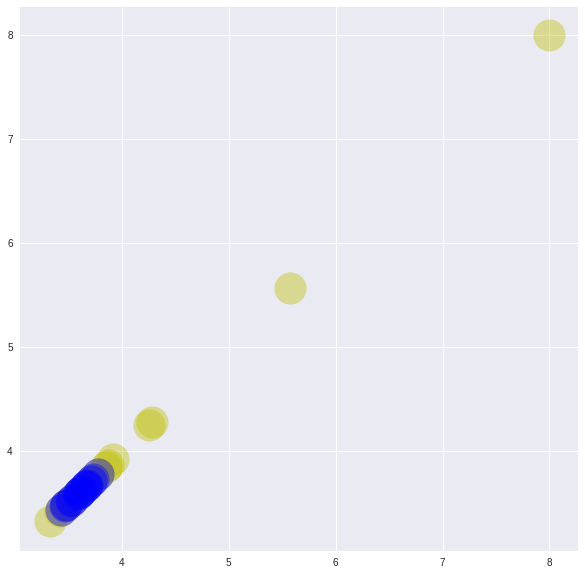

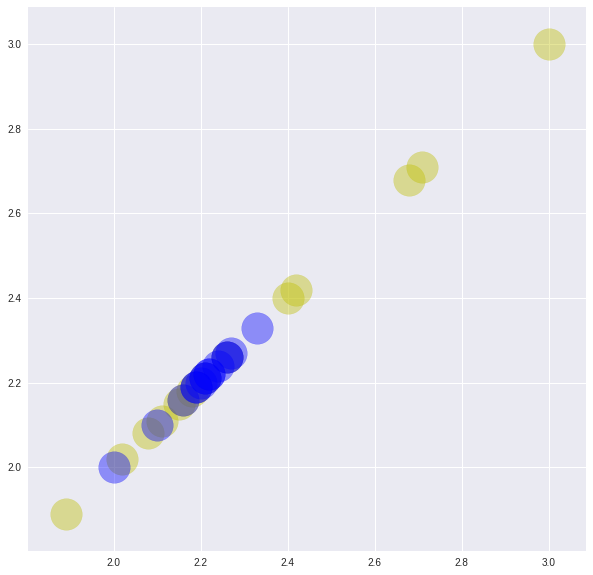

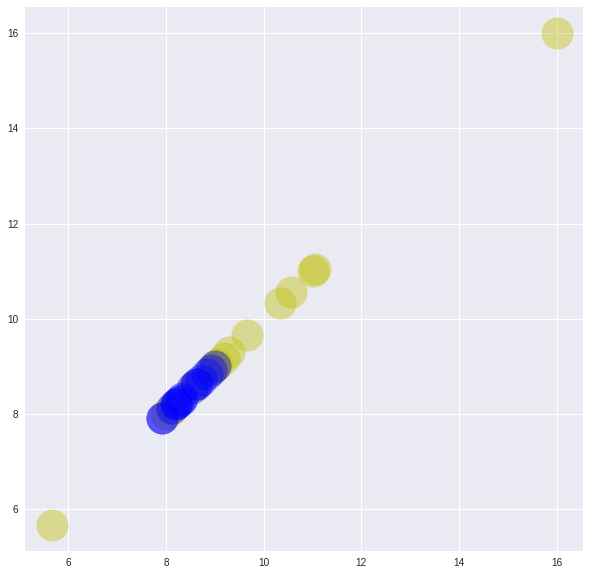

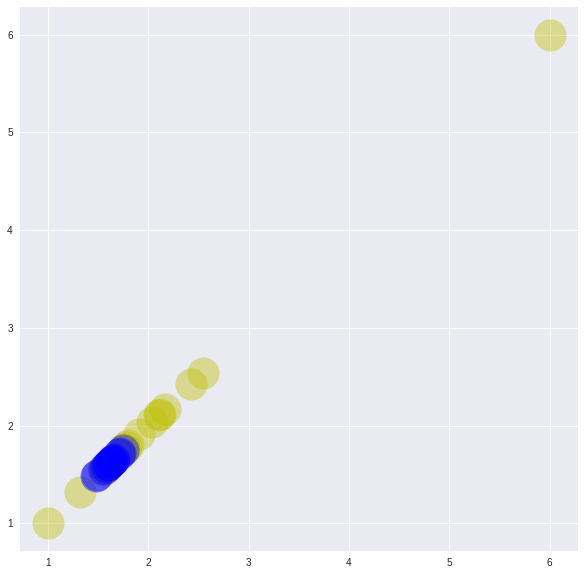

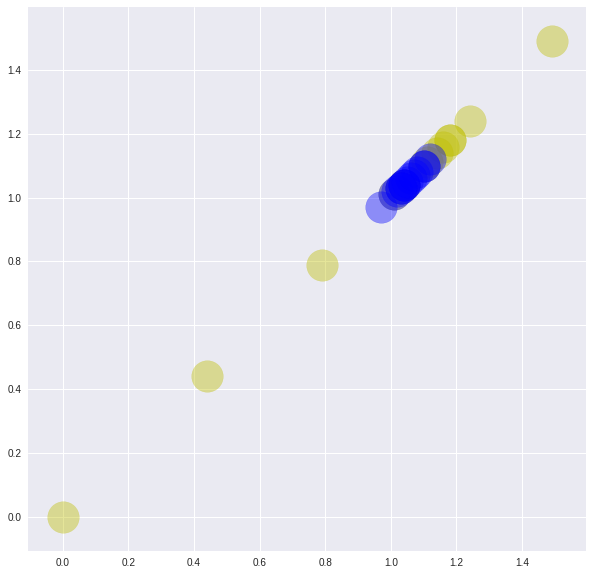

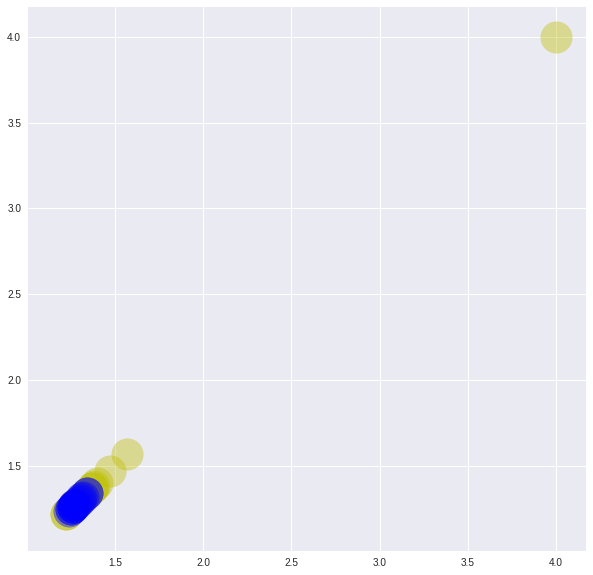

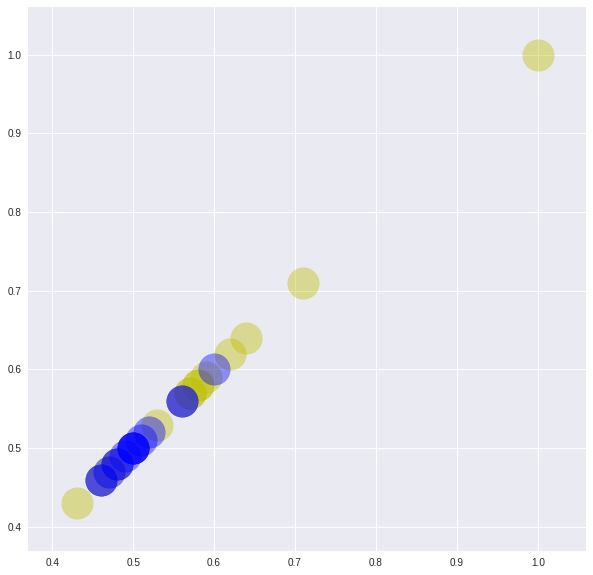

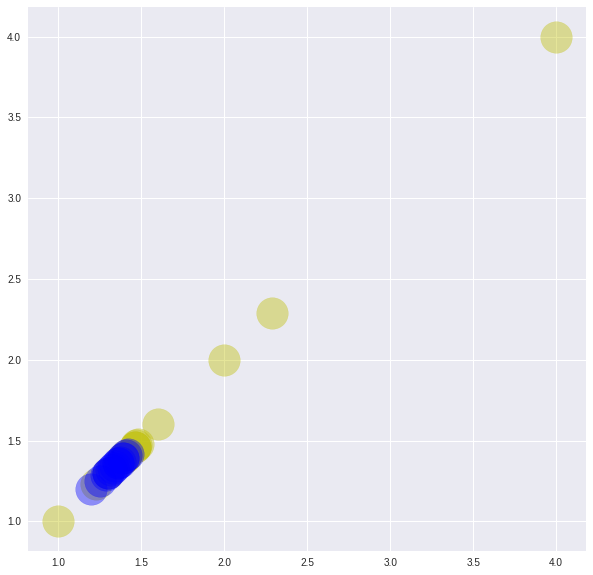

In [1137]:
plotScoresScatter(resultsDictD1)

In [1134]:
resultsDictD2 = findEnergyScores(classifierOnlyVoiceD2[2], onlyVoiceBaseD2Scores, onlyVoiceGroupD2Scores)

[  1 157 160 264 132 146 134 199 158  88 215 125 287 156 143  32 256  85
 214  13 203  54 187 147   8 250 189 115 137 243]


In [1138]:
classifierOnlyVoiceD2[2].classifier.feature_importances_

array([ 0.14915215,  0.11350768,  0.13685273,  0.16889194,  0.09411298,
        0.08260927,  0.15007531,  0.10479795])

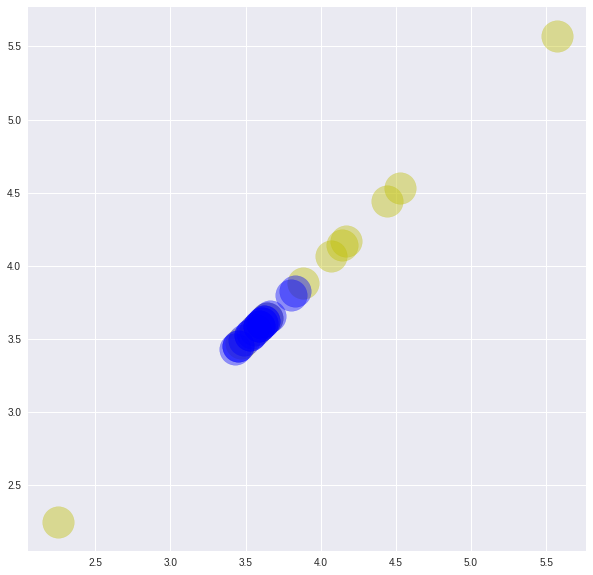

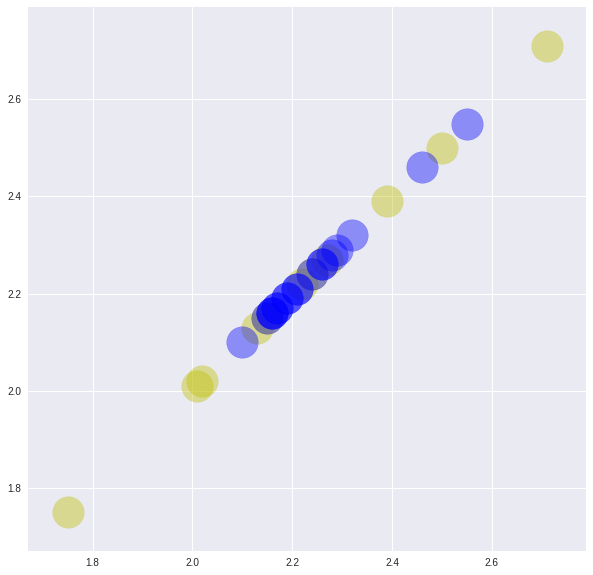

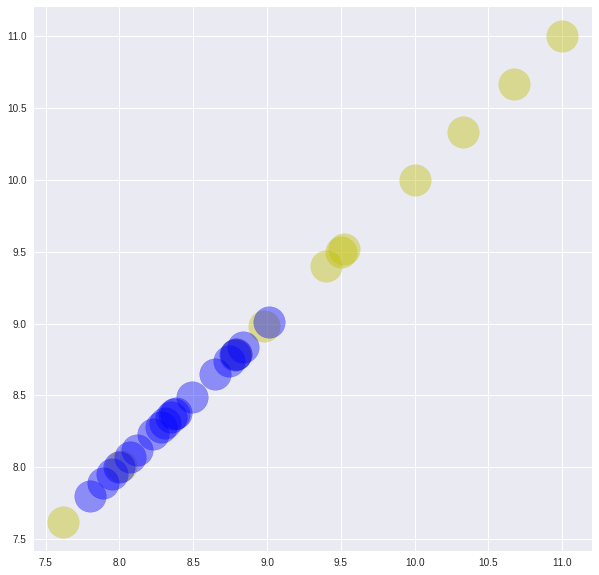

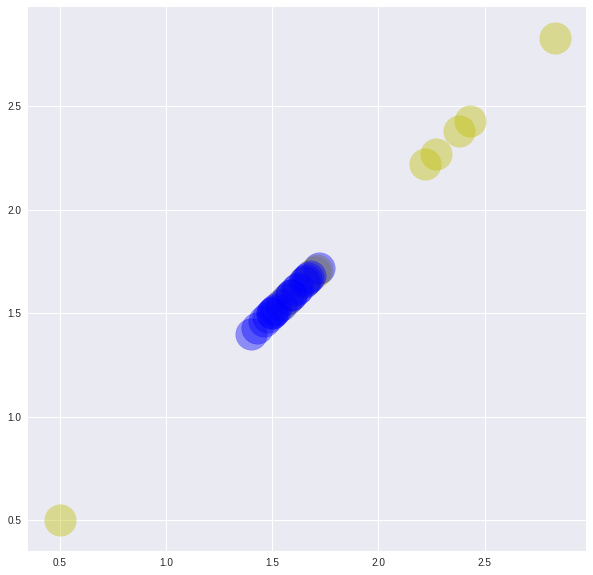

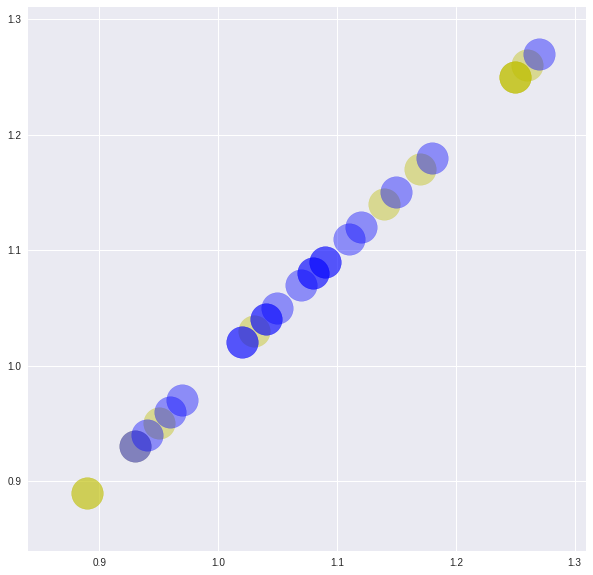

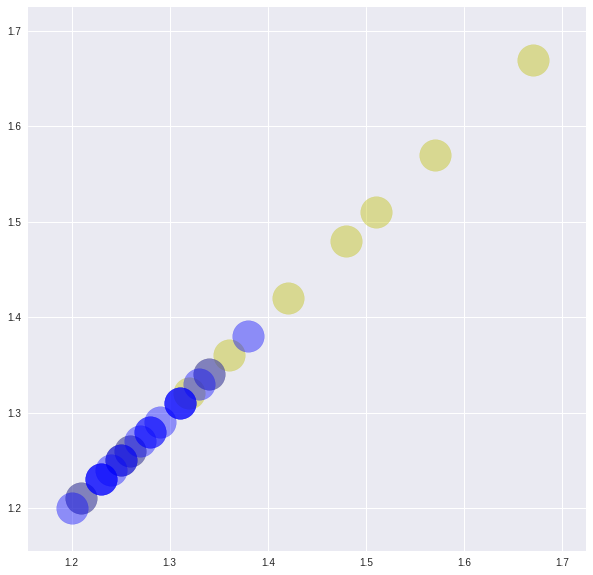

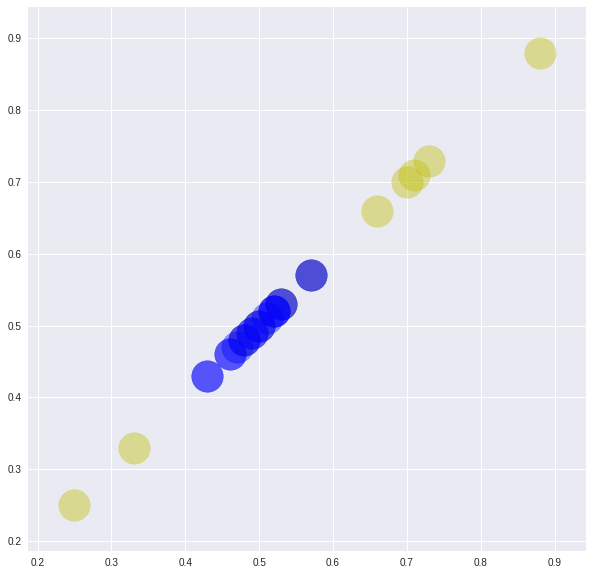

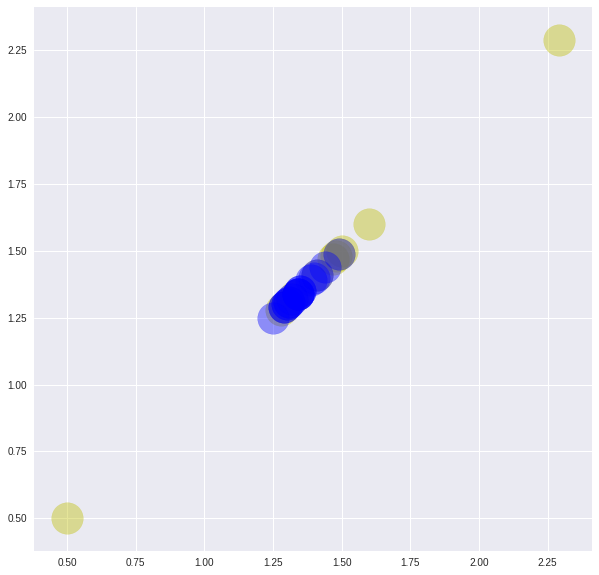

In [1139]:
plotScoresScatter(resultsDictD2)

In [1140]:
resultsDictD3 = findEnergyScores(classifierOnlyVoiceD3[2], onlyVoiceBaseD3Scores, onlyVoiceGroupD3Scores)

[220 129 261 144   1 246 136 146  41 266  15 260 121 267 215 192 290  42
  92  68 221 250   4 206 223  47  48 139 155 218]


In [1141]:
classifierOnlyVoiceD3[2].classifier.feature_importances_

array([ 0.13045265,  0.13312019,  0.13888712,  0.15802857,  0.10972315,
        0.09205546,  0.13007534,  0.10765752])

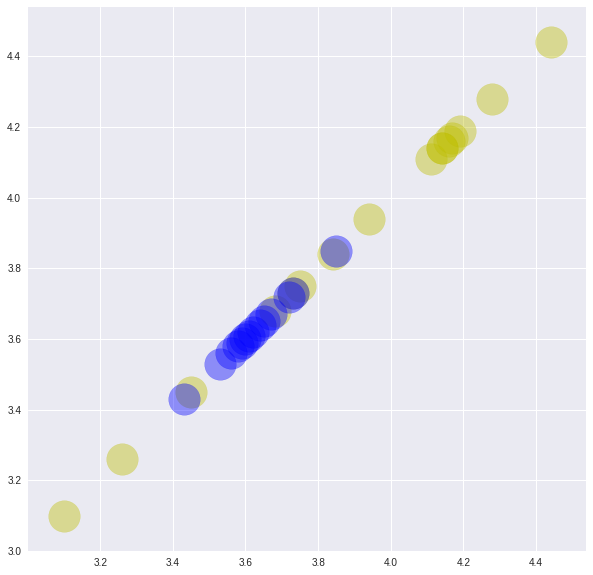

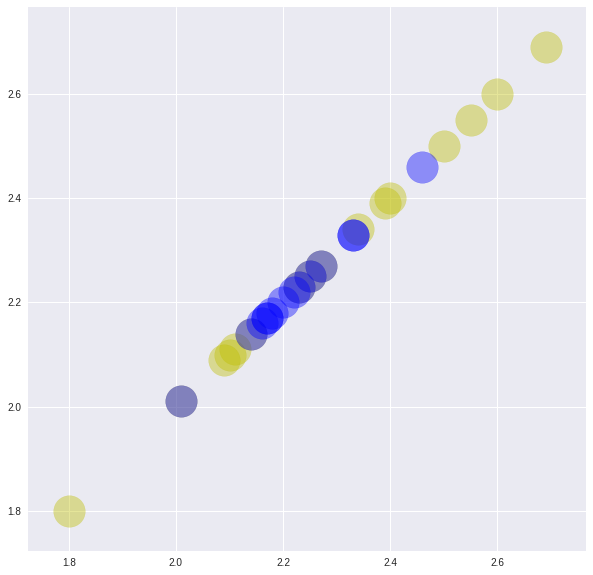

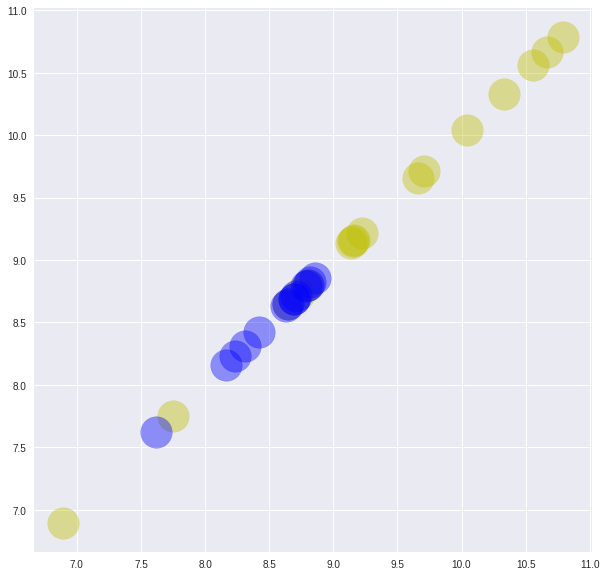

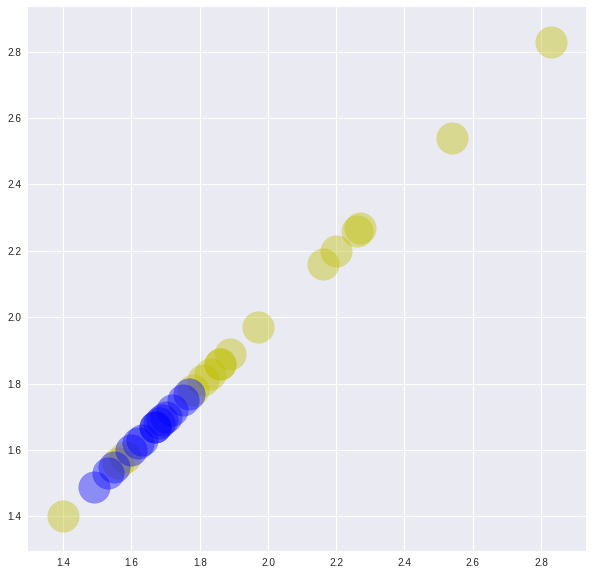

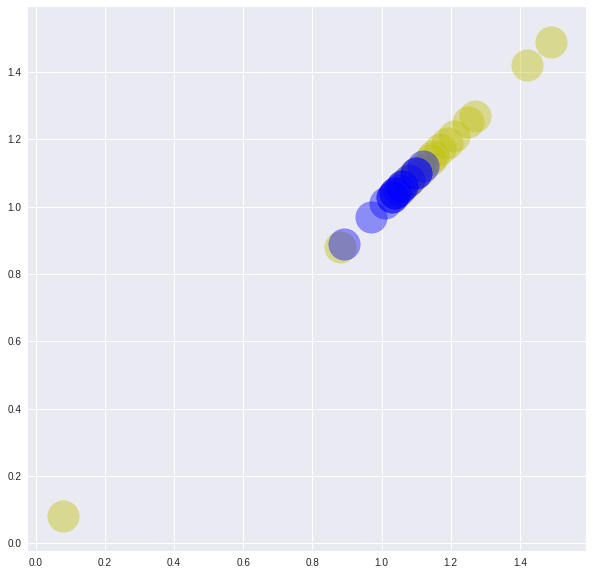

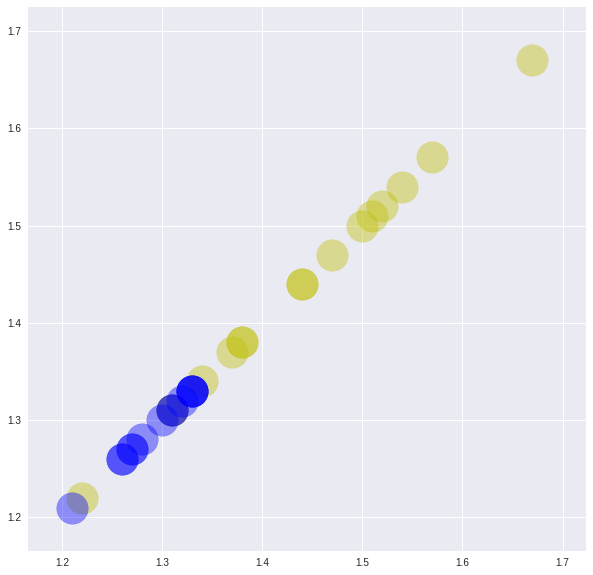

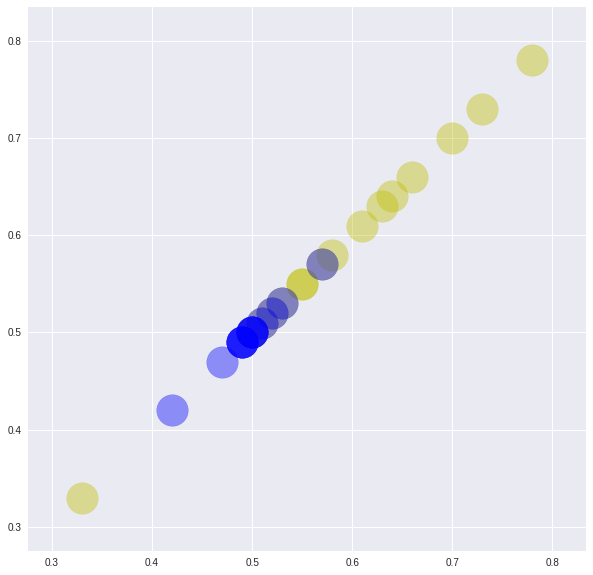

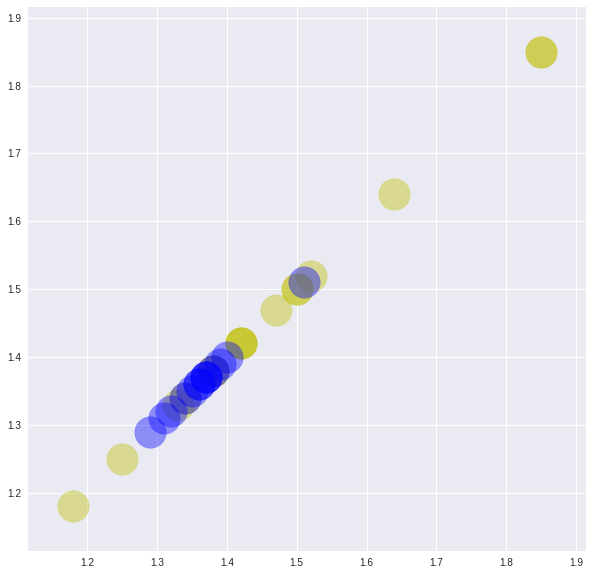

In [1142]:
plotScoresScatter(resultsDictD3)

# Recall

In [ ]:
y_true = []
y_scores = []
recall_clf = classifierDebugStandardD1[4].classifier
for i in classifierDebugStandardD1[4].test_index:
    
    if i < 150:
        y_true.append(0)
        y_scores.append(recall_clf.predict([debugStandardBaseD1Scores[i]]))
    else:
        y_true.append(1)
        y_scores.append(recall_clf.predict([debugStandardGroupD1Scores[150-i]]))

In [1158]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# eSPEPhonological (Extreme scores)

In [1162]:
eSPEDictVES = dict()
with open('eSPEPhonologicalTableVES') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictVES[line[0]] = np.array([eval(x) for x in line[1:]])

In [1164]:
def getTweetScoreVES(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                score += eSPEDictVES[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictVES[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictVES[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

# Extreme Score D1

In [ ]:
# Patient
progress = initializeProgressBar(len(groupD1Text))
groupD1VESScores = []
for i, person in enumerate(groupD1Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupD1Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    groupD1VESScores.append(list(score))

In [1168]:
groupD1VESScores = standardizeFeatures(groupD1VESScores)

In [1167]:
### Ordinary
progress = initializeProgressBar(len(baseD1Text))
baseD1VESScores = []
for i, person in enumerate(baseD1Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseD1Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    baseD1VESScores.append(list(score))

In [1170]:
baseD1VESScores = standardizeFeatures(baseD1VESScores)

In [1172]:
classifierD1VSE = getRandomForestPrecision(baseD1VESScores, groupD1VESScores, 'VSE-D1')

Precision of VSE-D1
------------------------------
0	0.8333333333333334
1	0.7666666666666667
2	0.7
3	0.8666666666666667
4	0.8
5	0.7333333333333333
6	0.8
7	0.8
8	0.7666666666666667
9	0.8333333333333334
------------------------------
Avg. precision: 0.7899999999999999


In [1174]:
groupOnlyVoiceD1VESScores = [ele[0:-1] for ele in groupD1VESScores]
baseOnlyVoiceD1VESScores = [ele[0:-1] for ele in baseD1VESScores]

In [1177]:
classifierOnlyVoiceD1VSE = getRandomForestPrecision(baseOnlyVoiceD1VESScores, groupOnlyVoiceD1VESScores, 'OnlyVoice-VSE-D1')

Precision of OnlyVoice-VSE-D1
------------------------------
0	0.6666666666666666
1	0.7666666666666667
2	0.9333333333333333
3	0.8
4	0.8333333333333334
5	0.7666666666666667
6	0.8333333333333334
7	0.8
8	0.7333333333333333
9	0.8333333333333334
------------------------------
Avg. precision: 0.7966666666666666


In [1184]:
resultsDictOnlyVoiceD1VSE = findEnergyScores(classifierOnlyVoiceD1VSE[2], baseOnlyVoiceD1VESScores, groupOnlyVoiceD1VESScores)

[ 24  48   1 147  63 231 218  56  67 285 141  35 181  58  33 143 241 130
 242 206 175 197 264   3 104 291 195 273 297 150]


In [1206]:
classifierOnlyVoiceD1VSE[2].classifier.feature_importances_

array([ 0.1254719 ,  0.12721017,  0.14833927,  0.18404886,  0.10615074,
        0.09872654,  0.10312597,  0.10692655])

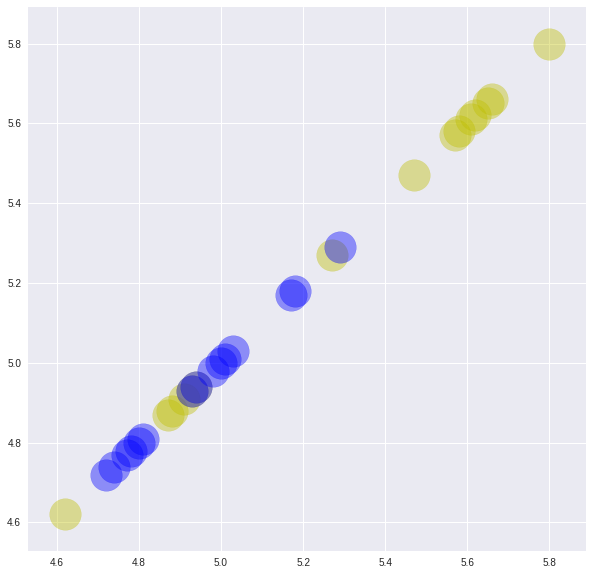

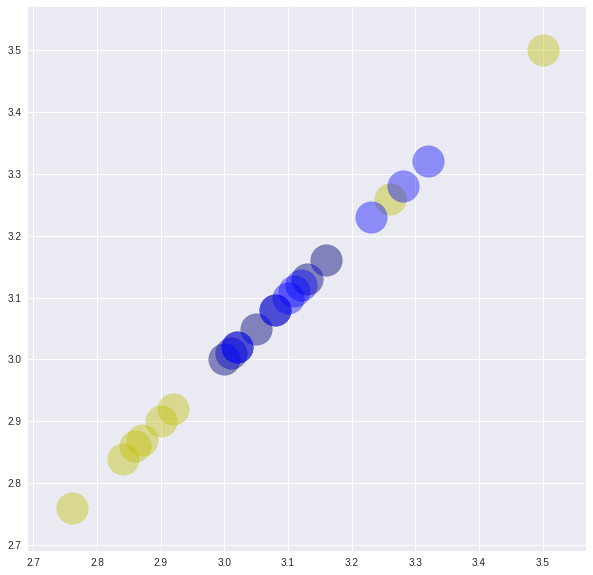

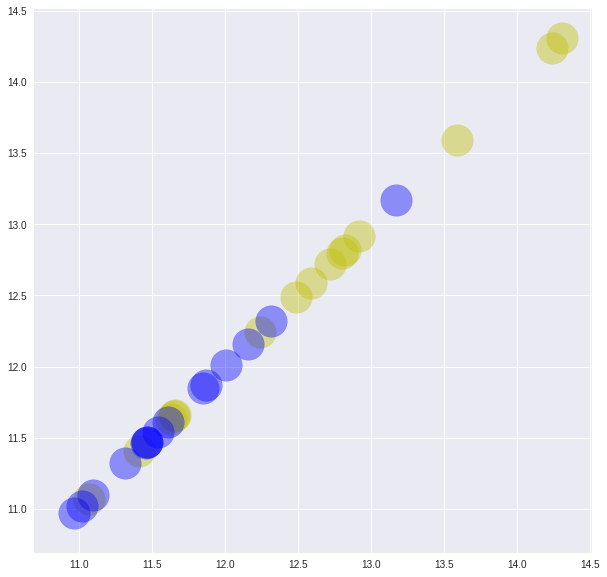

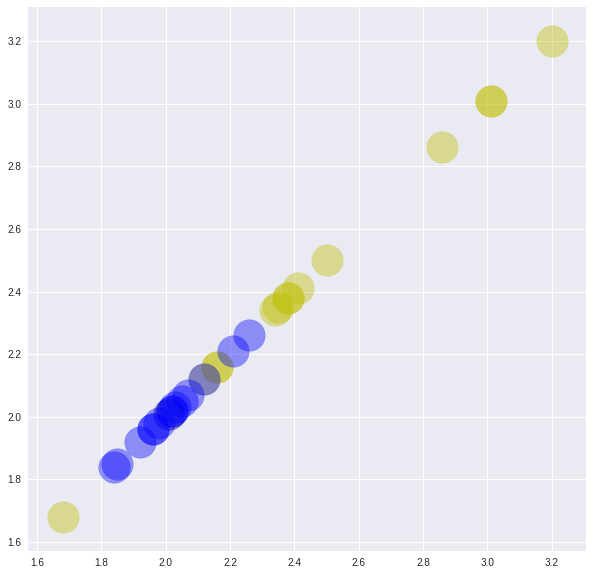

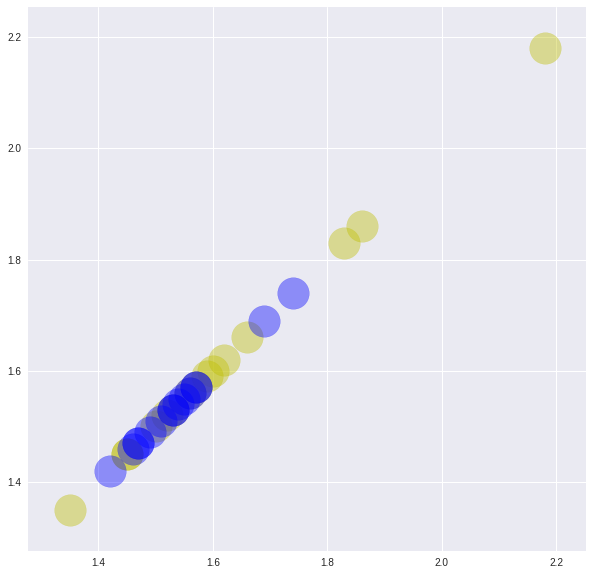

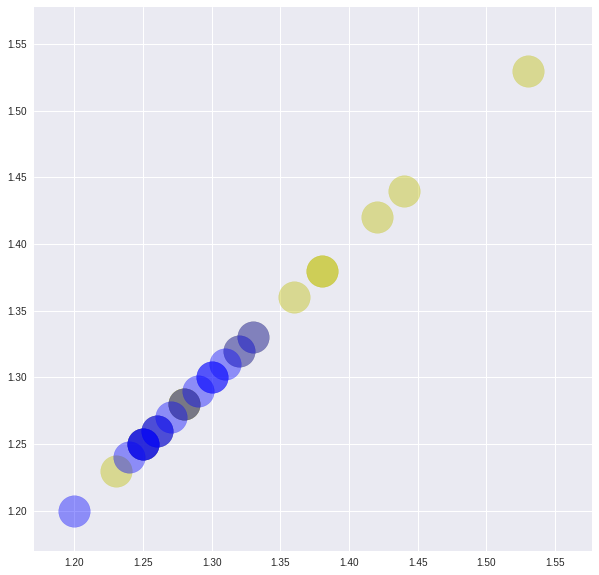

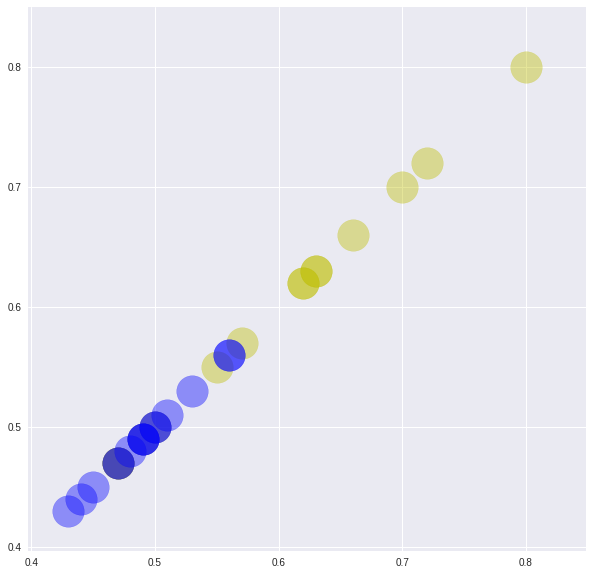

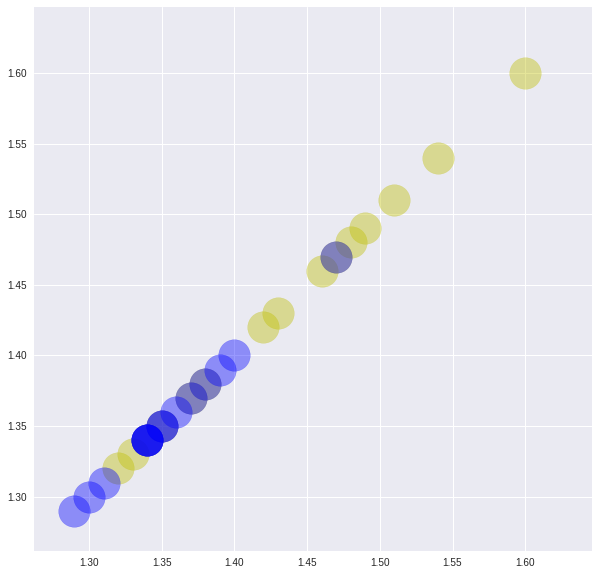

In [1185]:
plotScoresScatter(resultsDictOnlyVoiceD1VSE)

# Extreme Score D2

In [1188]:
### Patient
progress = initializeProgressBar(len(groupD2Text))
groupD2VESScores = []
for i, person in enumerate(groupD2Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupD2Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    groupD2VESScores.append(list(score))

groupD2VESScores = standardizeFeatures(groupD2VESScores)

In [1189]:
### Ordinary
progress = initializeProgressBar(len(baseD2Text))
baseD2VESScores = []
for i, person in enumerate(baseD2Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseD2Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    baseD2VESScores.append(list(score))

baseD2VESScores = standardizeFeatures(baseD2VESScores)

In [1190]:
classifierD2VSE = getRandomForestPrecision(baseD2VESScores, groupD2VESScores, 'VSE-D2')

Precision of VSE-D2
------------------------------
0	0.7666666666666667
1	0.7333333333333333
2	0.7666666666666667
3	0.6666666666666666
4	0.7666666666666667
5	0.8
6	0.8333333333333334
7	0.8333333333333334
8	0.8
9	0.7666666666666667
------------------------------
Avg. precision: 0.7733333333333332


In [1191]:
groupOnlyVoiceD2VESScores = [ele[0:-1] for ele in groupD2VESScores]
baseOnlyVoiceD2VESScores = [ele[0:-1] for ele in baseD2VESScores]

In [1195]:
classifierOnlyVoiceD2VSE = getRandomForestPrecision(baseOnlyVoiceD2VESScores, groupOnlyVoiceD2VESScores, 'OnlyVoice-VSE-D2')

Precision of OnlyVoice-VSE-D2
------------------------------
0	0.7666666666666667
1	0.7333333333333333
2	0.7333333333333333
3	0.7666666666666667
4	0.9
5	0.8
6	0.7333333333333333
7	0.8
8	0.9333333333333333
9	0.6666666666666666
------------------------------
Avg. precision: 0.7833333333333334


In [1203]:
resultsDictOnlyVoiceD2VSE = findEnergyScores(classifierOnlyVoiceD2VSE[8], baseOnlyVoiceD2VESScores, groupOnlyVoiceD2VESScores)

[117 160  90  11  60  21 155 258 244 272 193 252 292 265 113 163  80 128
 120  47 208 119  91 181 159  38 126 179 240  96]


In [1207]:
classifierOnlyVoiceD2VSE[8].classifier.feature_importances_

array([ 0.15712494,  0.15603757,  0.13722199,  0.15081457,  0.09756585,
        0.08072414,  0.1293774 ,  0.09113354])

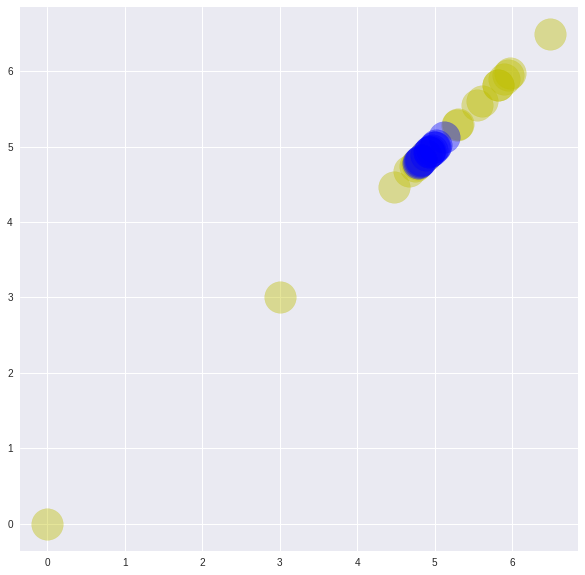

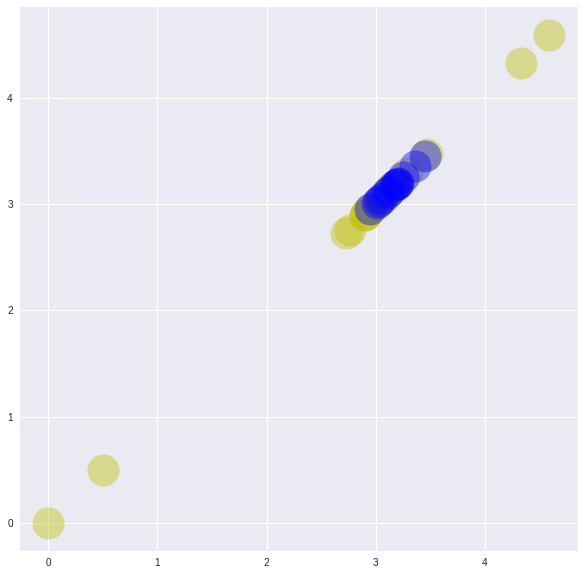

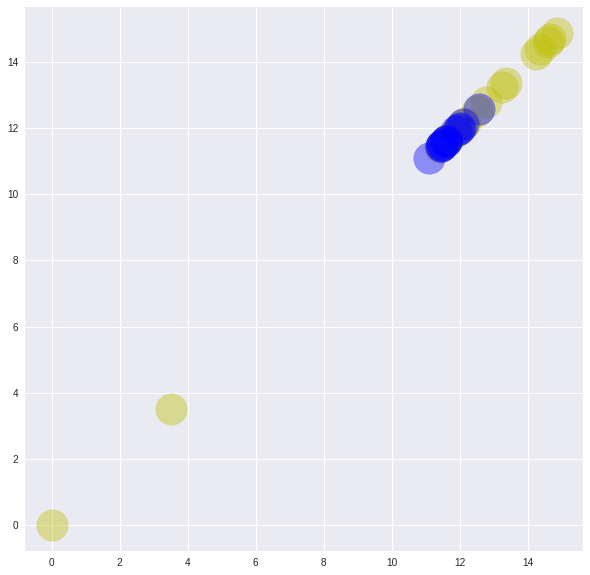

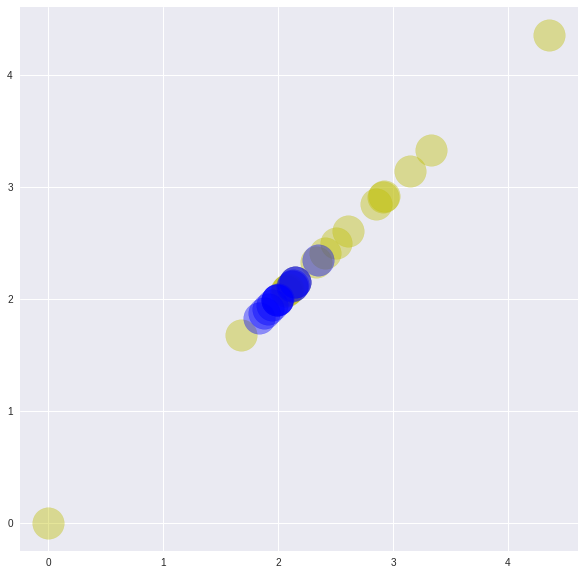

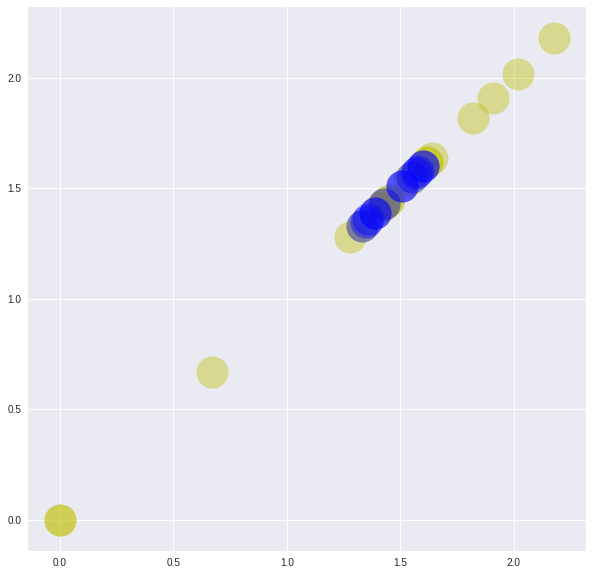

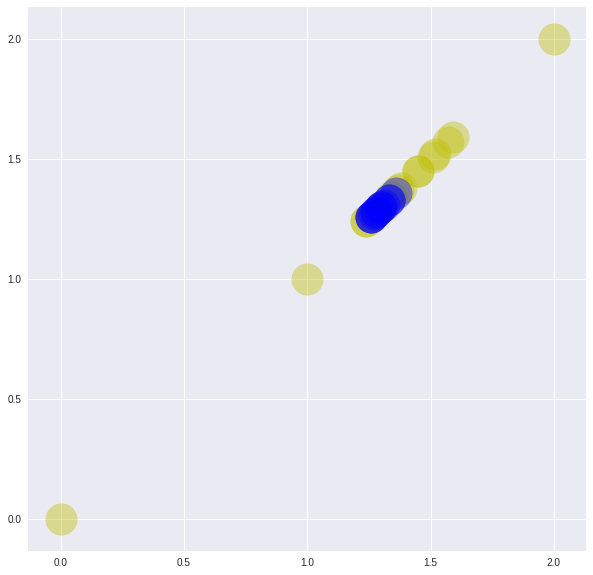

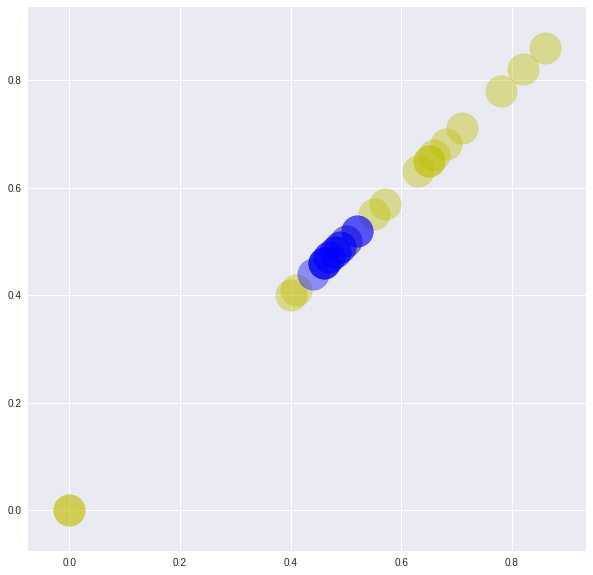

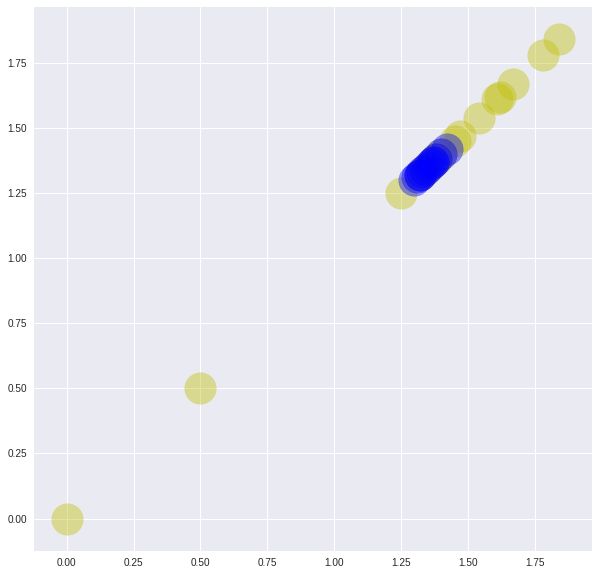

In [1204]:
plotScoresScatter(resultsDictOnlyVoiceD2VSE)

# Extreme Score D3

In [1198]:
### Patient
progress = initializeProgressBar(len(groupD3Text))
groupD3VESScores = []
for i, person in enumerate(groupD3Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(groupD3Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    groupD3VESScores.append(list(score))

groupD3VESScores = standardizeFeatures(groupD3VESScores)

In [1199]:
### Ordinary
progress = initializeProgressBar(len(baseD3Text))
baseD3VESScores = []
for i, person in enumerate(baseD3Text):    # Type of groupTextCase1: List
    progress.value += 1
    progress.description = 'Task {0}/{1}'.format(i+1, len(baseD3Text))
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreVES(tweet)
    baseD3VESScores.append(list(score))

baseD3VESScores = standardizeFeatures(baseD3VESScores)

In [1200]:
classifierD3VSE = getRandomForestPrecision(baseD3VESScores, groupD3VESScores, 'VSE-D3')

Precision of VSE-D3
------------------------------
0	0.8666666666666667
1	0.8333333333333334
2	0.7333333333333333
3	0.8
4	0.8666666666666667
5	0.6333333333333333
6	0.7
7	0.8666666666666667
8	0.7
9	0.9
------------------------------
Avg. precision: 0.7899999999999999


In [1202]:
groupOnlyVoiceD3VESScores = [ele[0:-1] for ele in groupD3VESScores]
baseOnlyVoiceD3VESScores = [ele[0:-1] for ele in baseD3VESScores]
classifierOnlyVoiceD3VSE = getRandomForestPrecision(baseOnlyVoiceD3VESScores, groupOnlyVoiceD3VESScores, 'OnlyVoice-VSE-D3')

Precision of OnlyVoice-VSE-D3
------------------------------
0	0.7666666666666667
1	0.8333333333333334
2	0.7666666666666667
3	0.7666666666666667
4	0.8333333333333334
5	0.8
6	0.9
7	0.7666666666666667
8	0.8666666666666667
9	0.7666666666666667
------------------------------
Avg. precision: 0.8066666666666669


In [1208]:
classifierOnlyVoiceD3VSE[6].classifier.feature_importances_

array([ 0.12932321,  0.1473679 ,  0.13477922,  0.15546796,  0.10143421,
        0.09634508,  0.12684253,  0.10843989])

[247   4  12 106  93 290 203 127 145 277  96 110  45  67  17 263 116 270
 298 213  78  66 222  75 272 161 231 167 194 291]


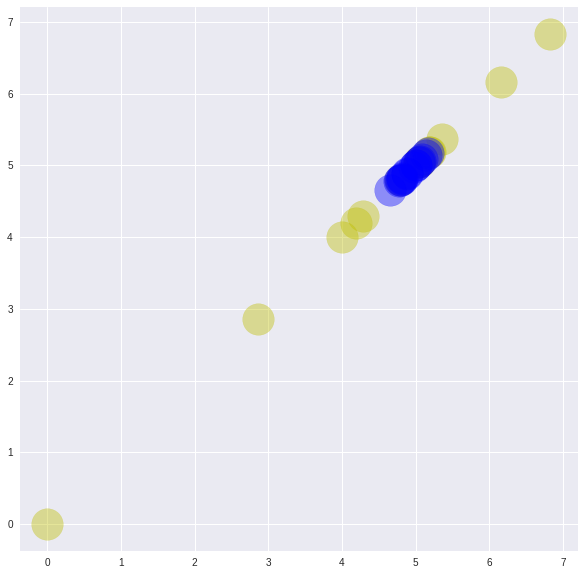

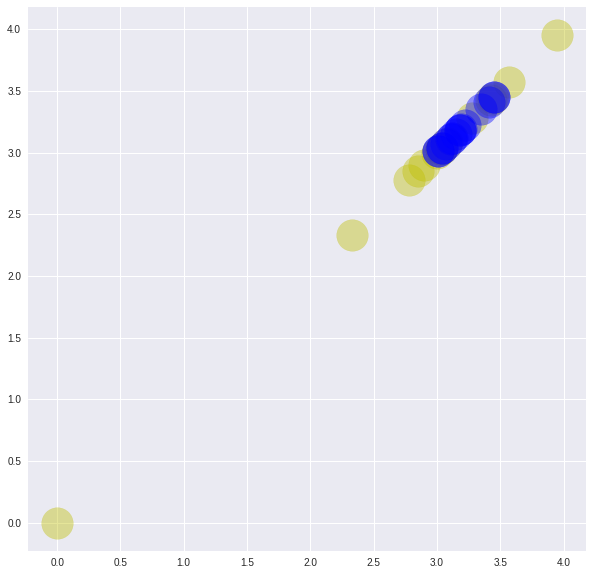

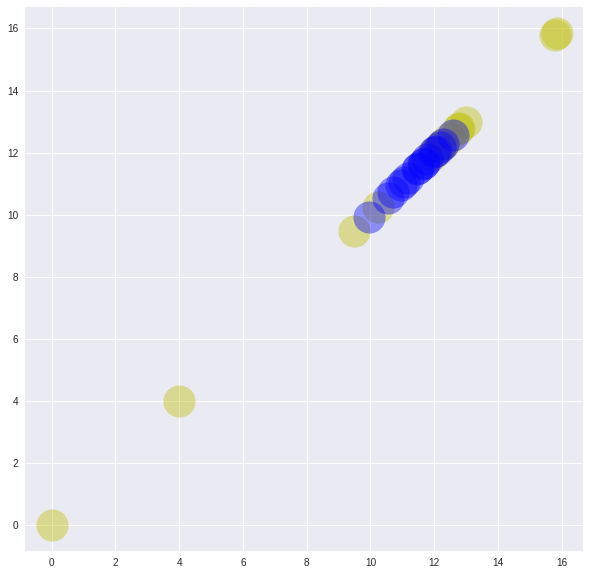

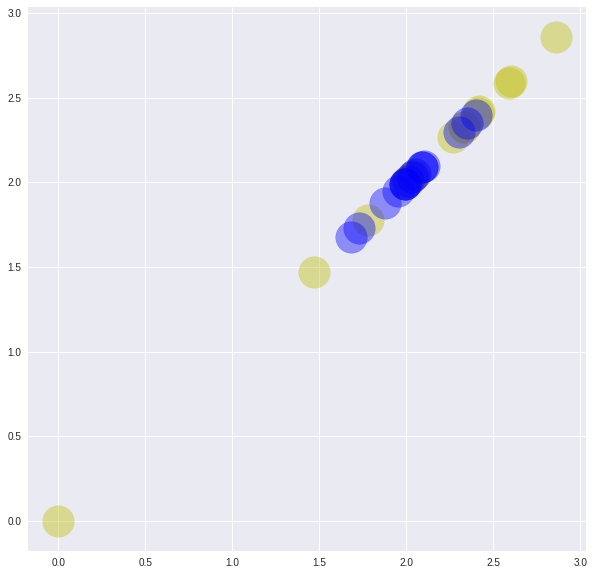

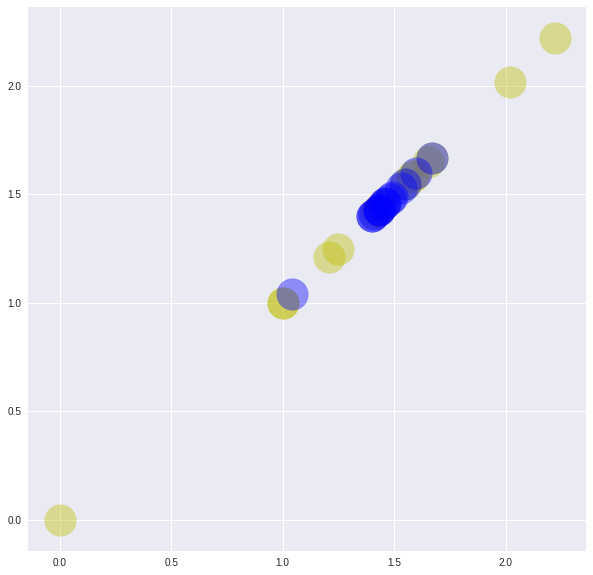

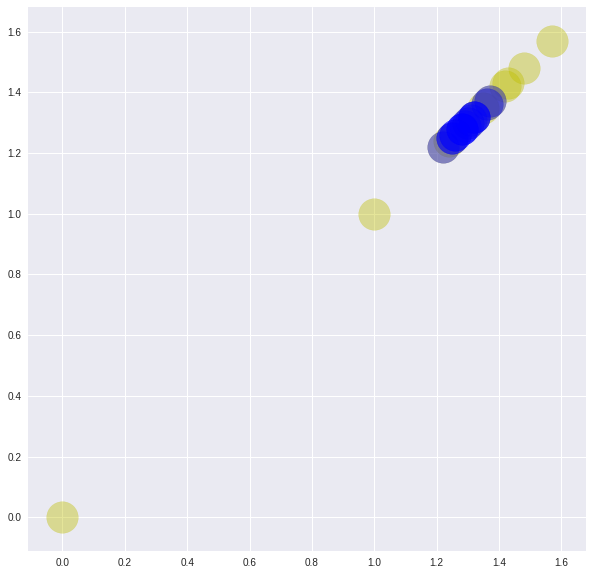

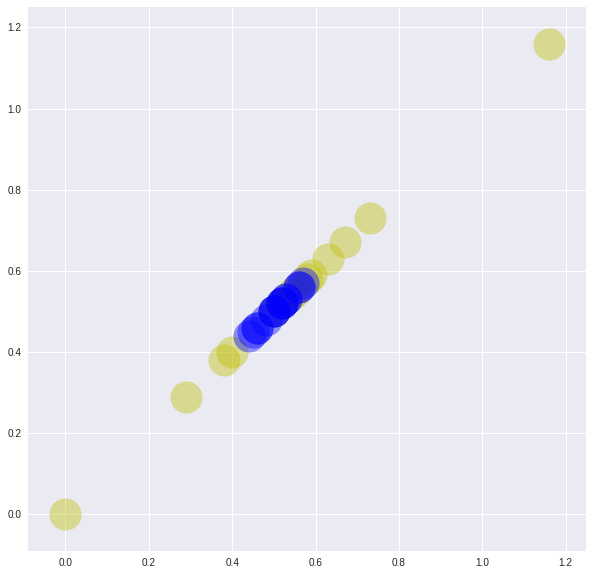

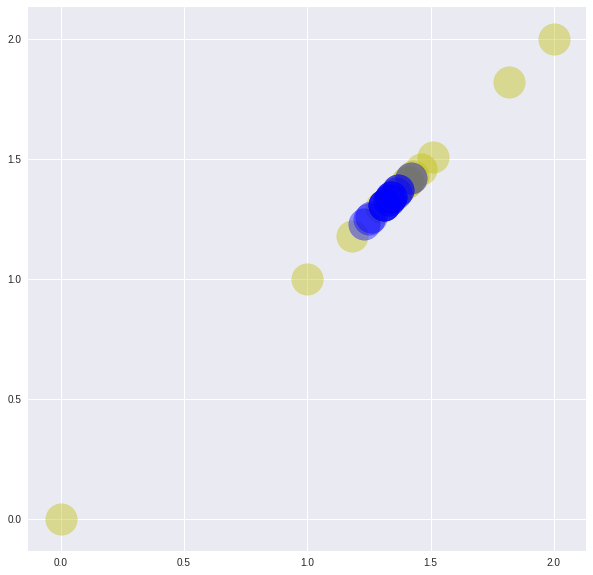

In [1205]:
resultsDictOnlyVoiceD3VSE = findEnergyScores(classifierOnlyVoiceD3VSE[6], baseOnlyVoiceD3VESScores, groupOnlyVoiceD3VESScores)
plotScoresScatter(resultsDictOnlyVoiceD3VSE)

In [1347]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def plotScoresLine(resultsDict, name):
    
    for i in range(8):
#         print(resultsDict['predict'][i])
        _min = math.floor(min(resultsDict[str(i)]))
        _max = math.ceil(max(resultsDict[str(i)]))
#         print(_min, _max)
        rangeList = np.arange(_min, _max, 0.5)
        plot0 = {i: 0 for i in rangeList}
        plot1 = {i: 0 for i in rangeList}
#         print(plot0, plot1)
        for j, ele in enumerate(resultsDict['predict']):
            if ele == 0:
                idx = find_nearest(rangeList, resultsDict[str(i)][j])
                plot0[rangeList[idx]] += 1
            else:
                idx = find_nearest(rangeList, resultsDict[str(i)][j])
                plot1[rangeList[idx]] += 1

#         print(plot0)

        plt.rcParams["figure.figsize"] = [10,10]
        plt.rcParams["legend.fontsize"] = 50
        
        X = []
        Y1 = []
        Y2 = []
        keys = list(plot0.keys())
        X = np.argsort(keys)
        for i in X:
            Y1.append(plot0[keys[i]])
#             print(plot0[keys[i]])
        
        keys = list(plot1.keys())
        X2 = np.argsort(keys)
        for i in X:
            Y2.append(plot1[keys[i]])
            
        fig, ax = plt.subplots()
        ax.plot(rangeList, Y1, c='y', label='Ordinary')
        ax.plot(rangeList, Y2, c='b', label='Patient')
        

#         ax.scatter(plot1, plot1, c='b', alpha=0.4, s=1000, label='Patient')
        # ax.scatter(np.random.rand(10), np.random.rand(10), s=1000, c='b', label='Ordinary')
        # ax.scatter(np.random.rand(10), np.random.rand(10), s=1000, c='r', label='Patient')
        plt.savefig(name + '{0}.png'.format(i+1))
        plt.show()
        plt.close(fig)
#         break

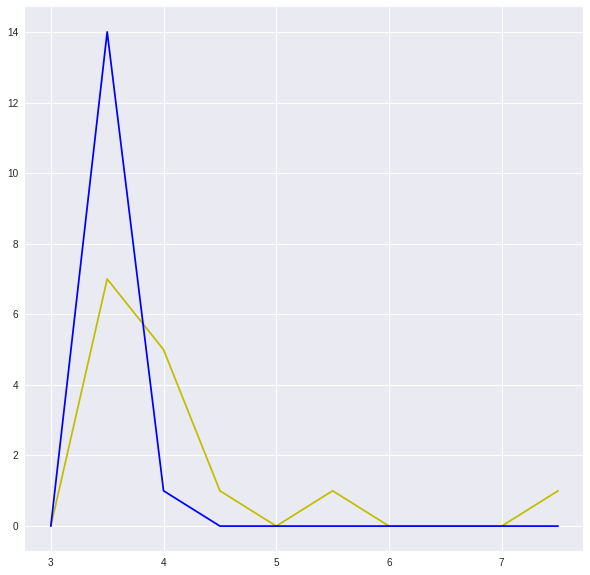

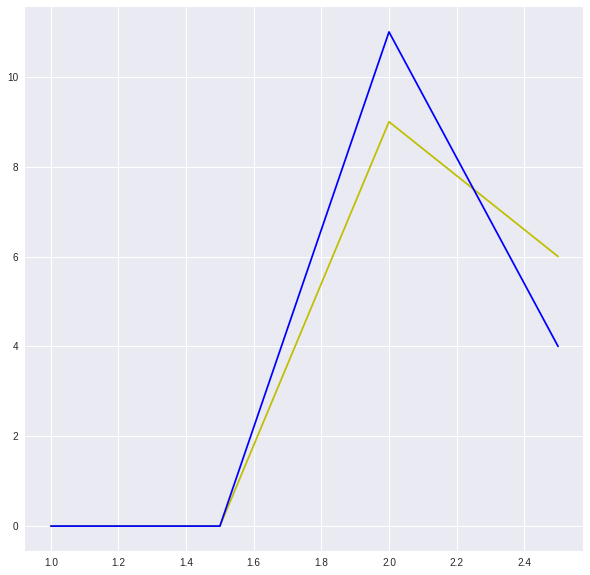

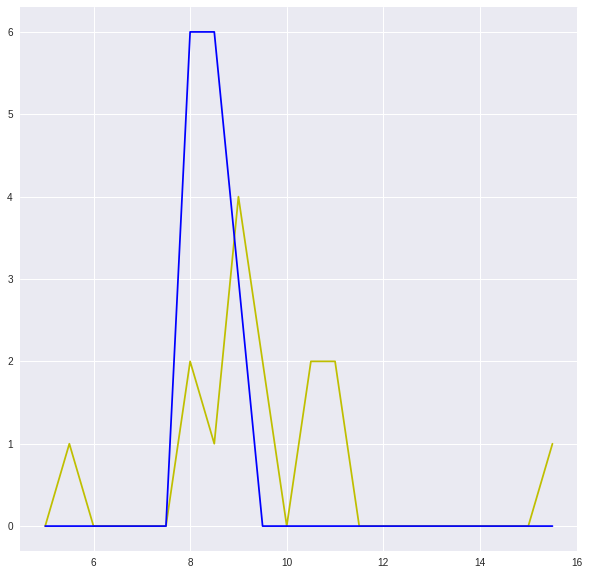

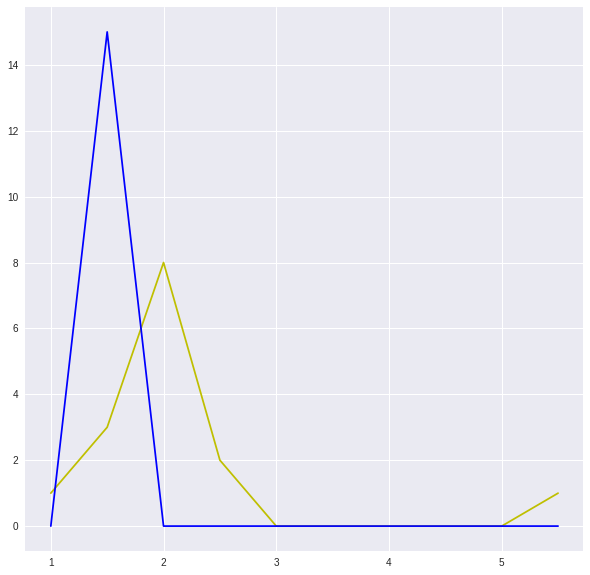

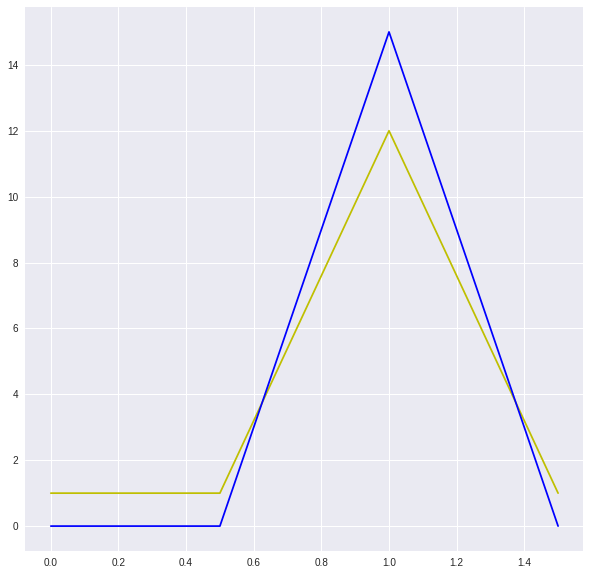

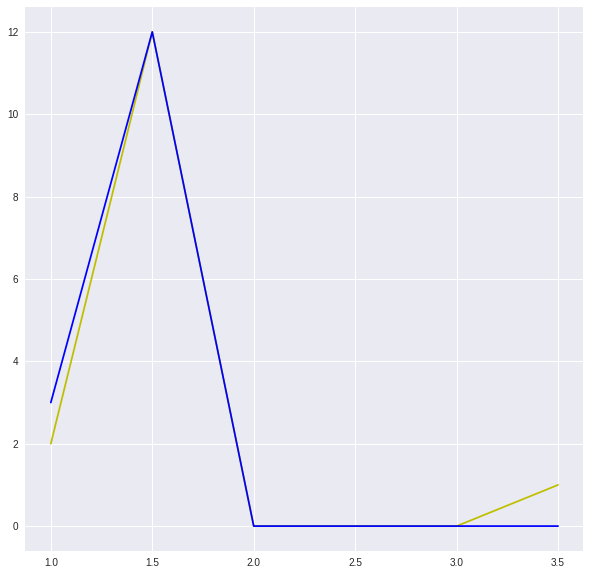

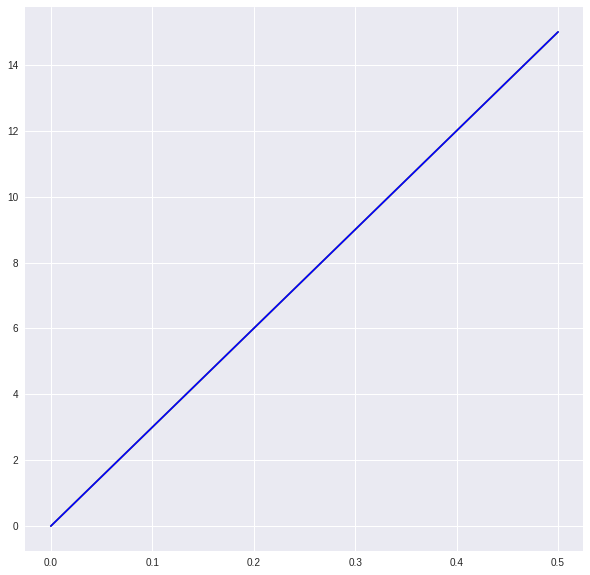

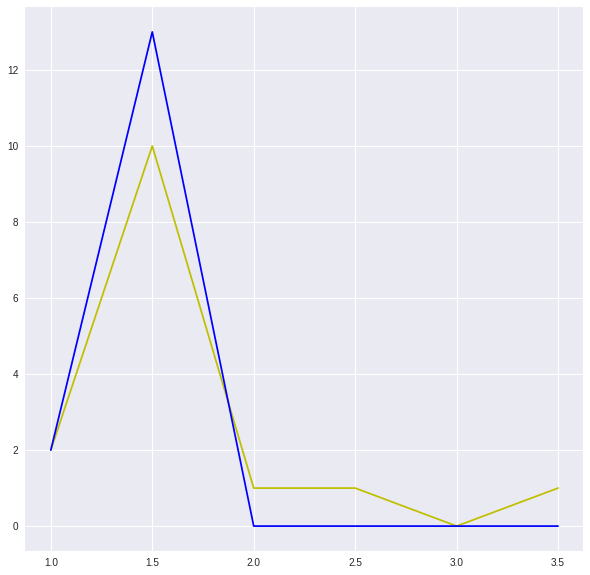

In [1348]:
plotScoresLine(resultsDictD1, 'D1')

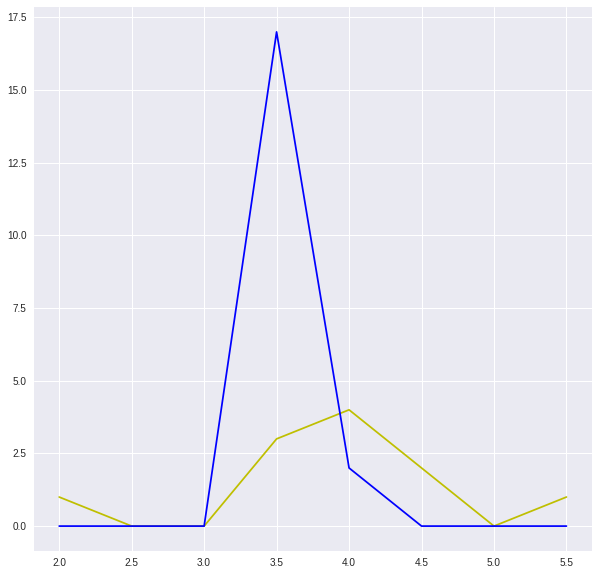

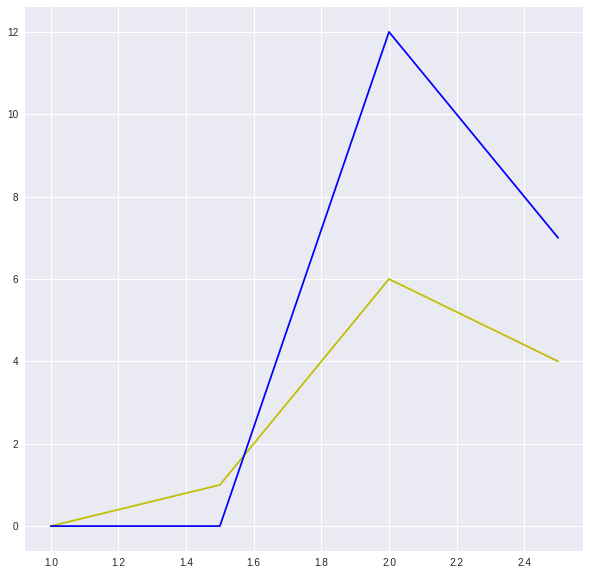

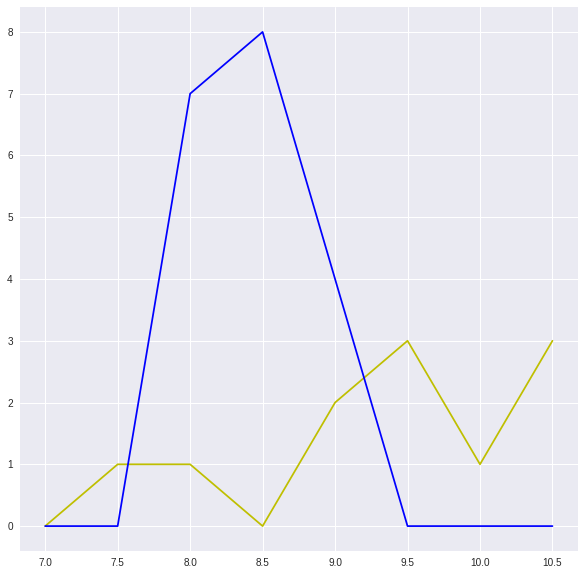

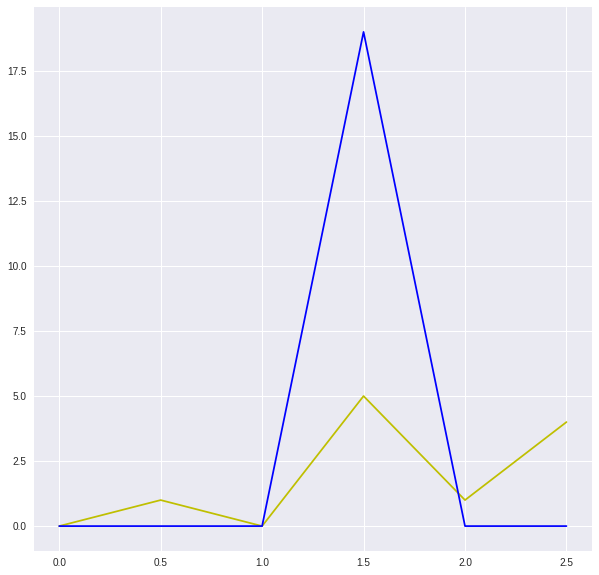

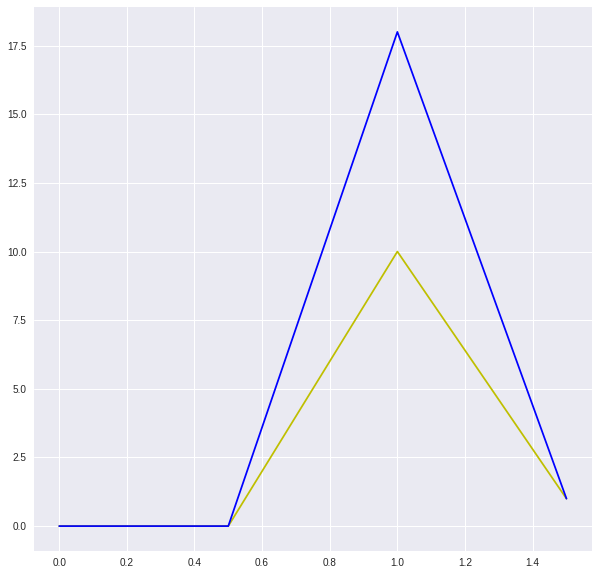

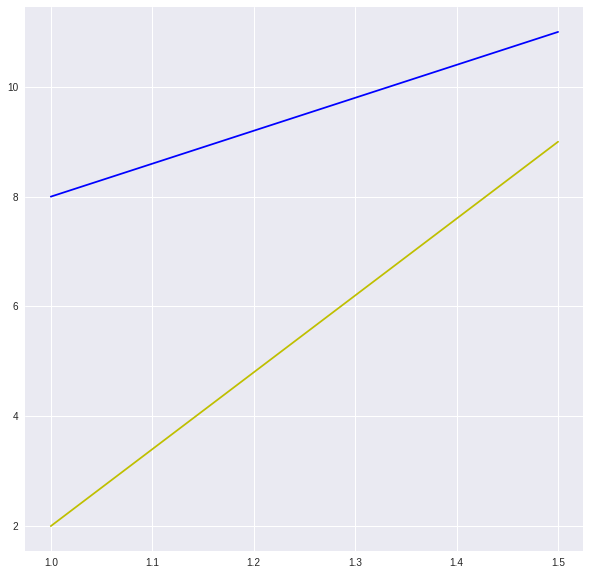

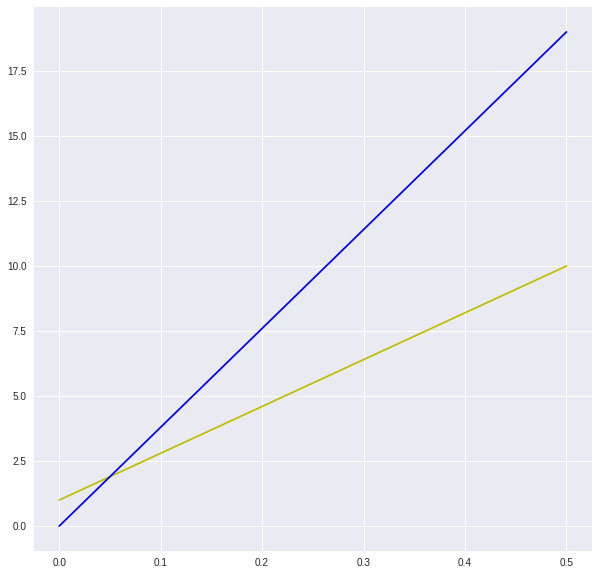

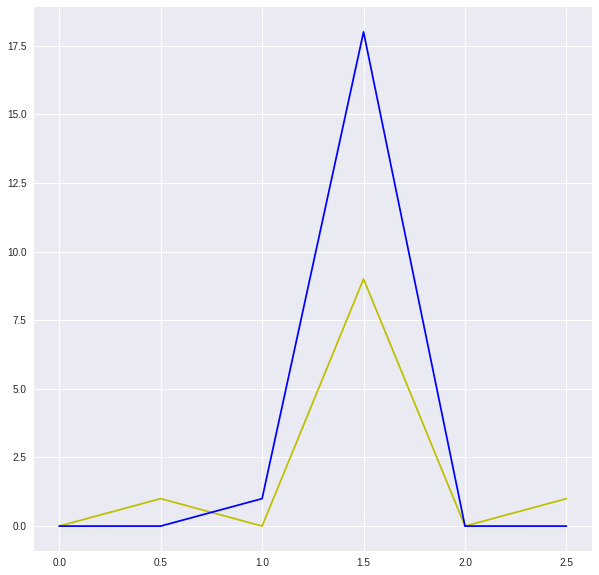

In [1349]:
plotScoresLine(resultsDictD2, 'D2')

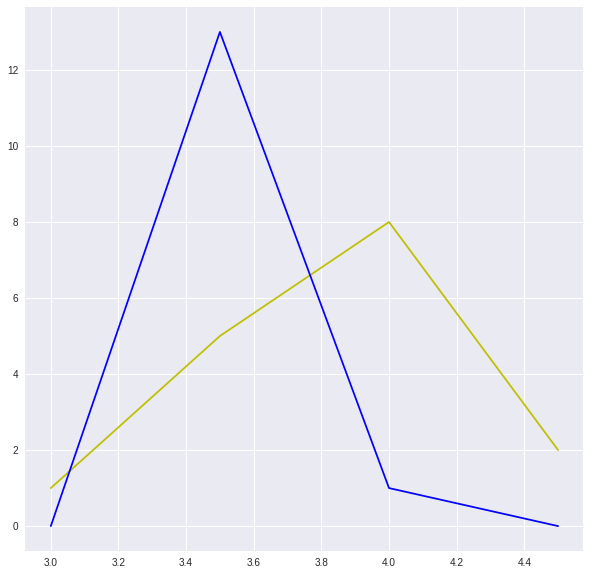

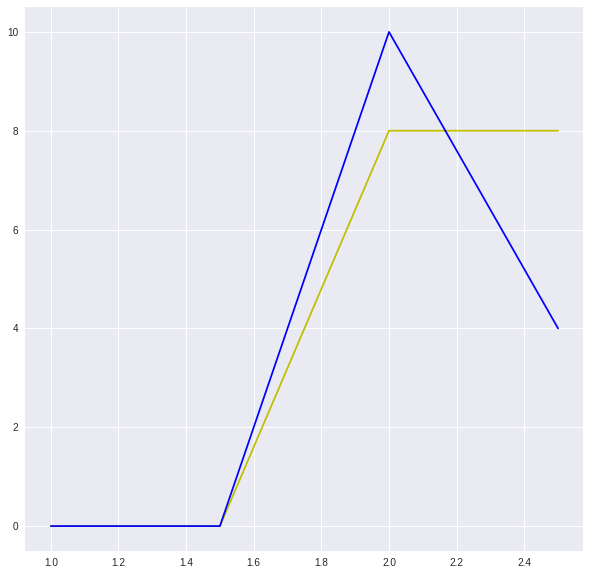

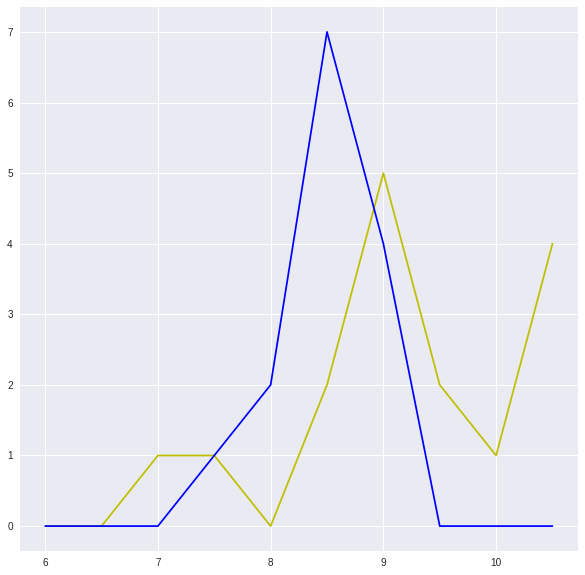

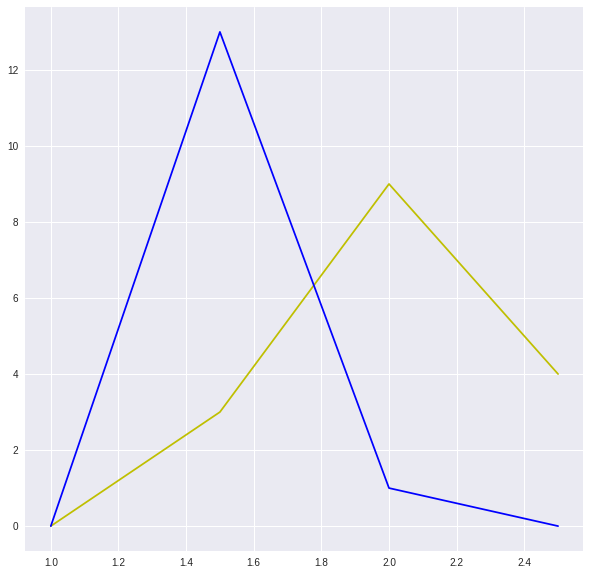

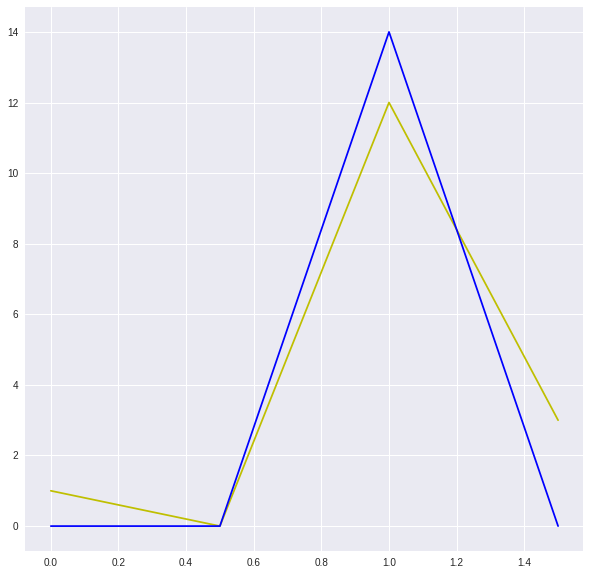

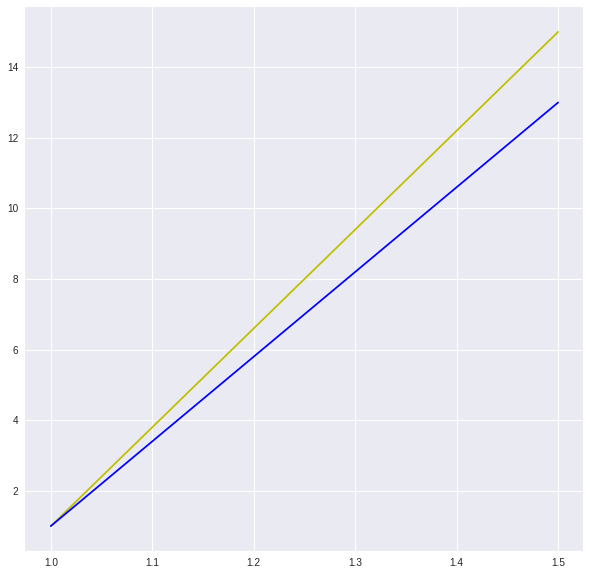

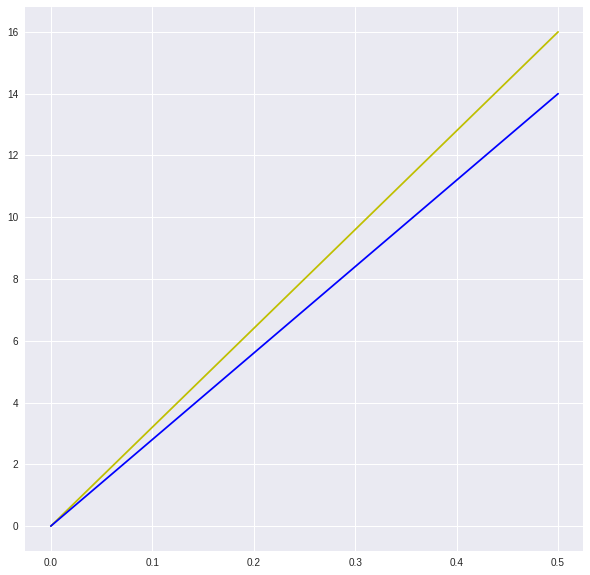

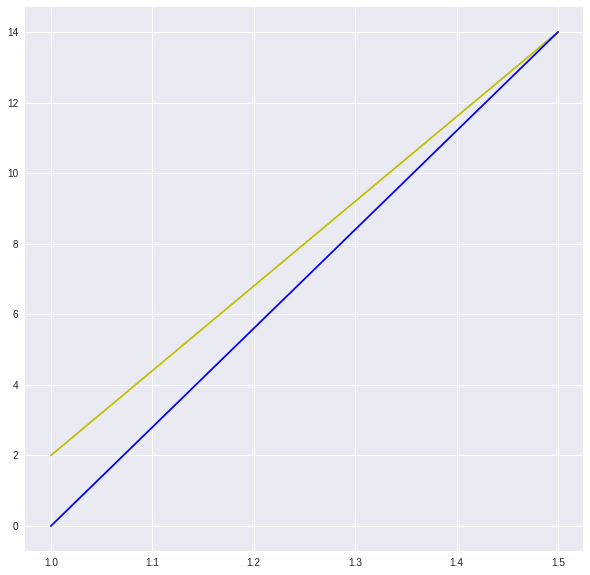

In [1350]:
plotScoresLine(resultsDictD3, 'D3')

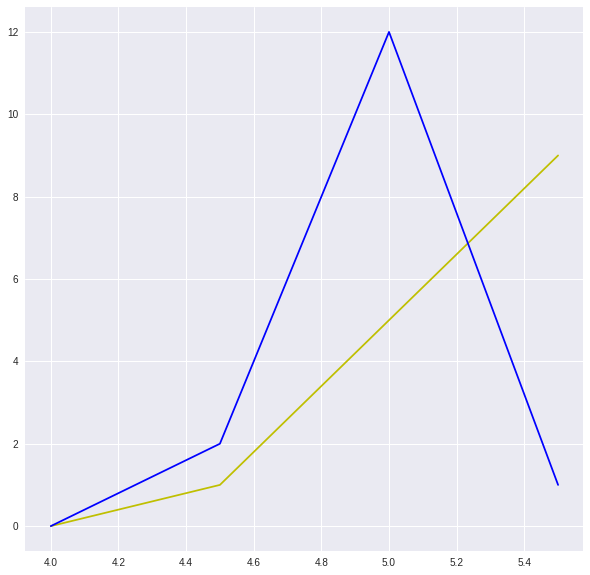

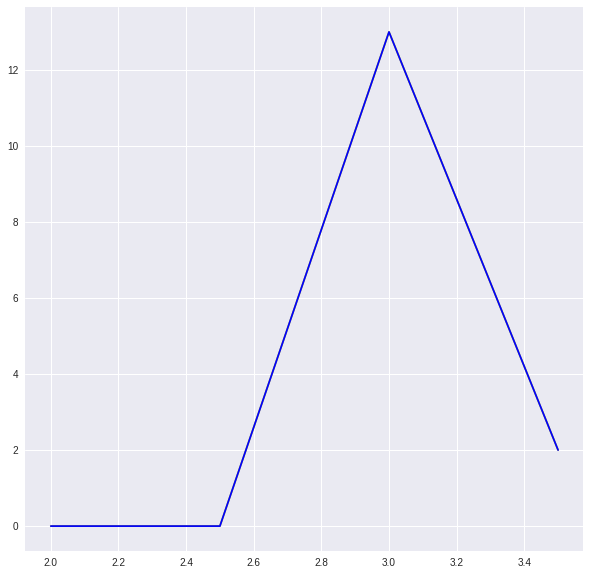

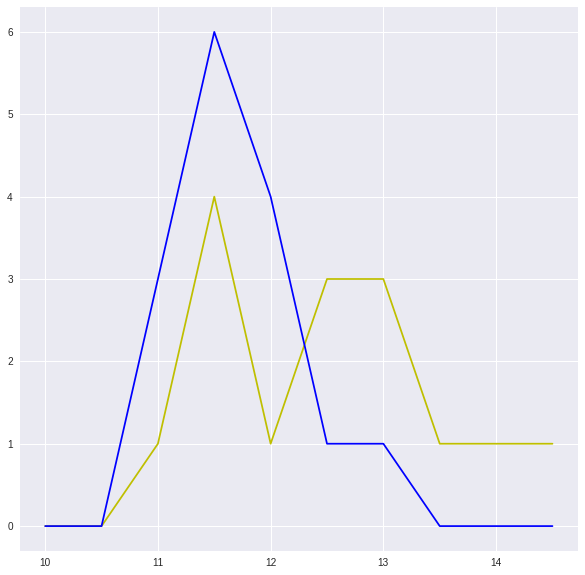

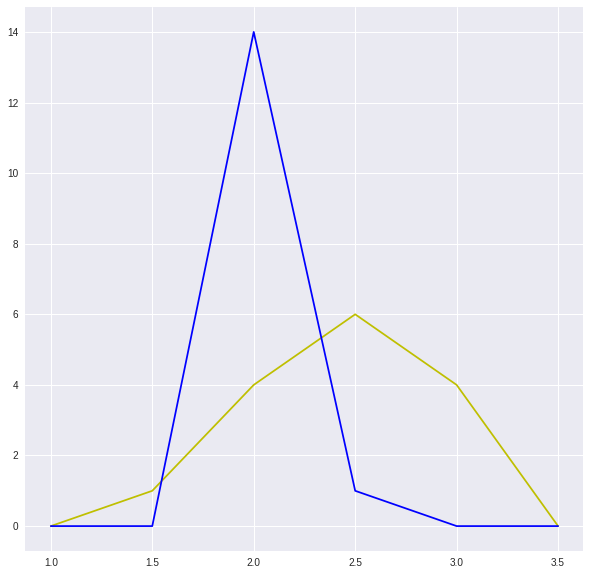

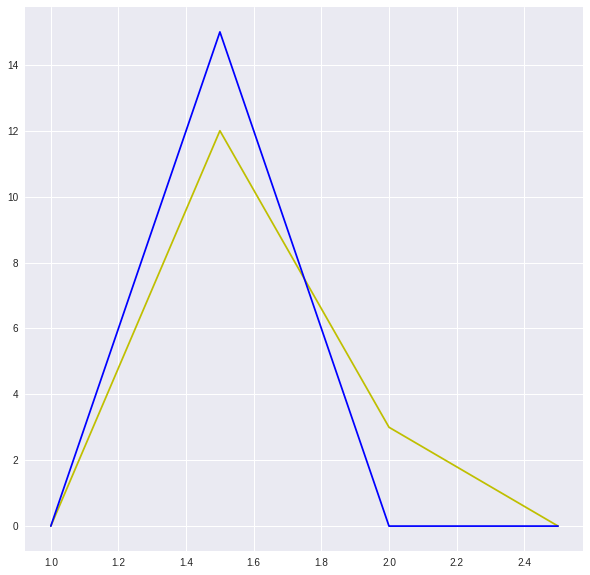

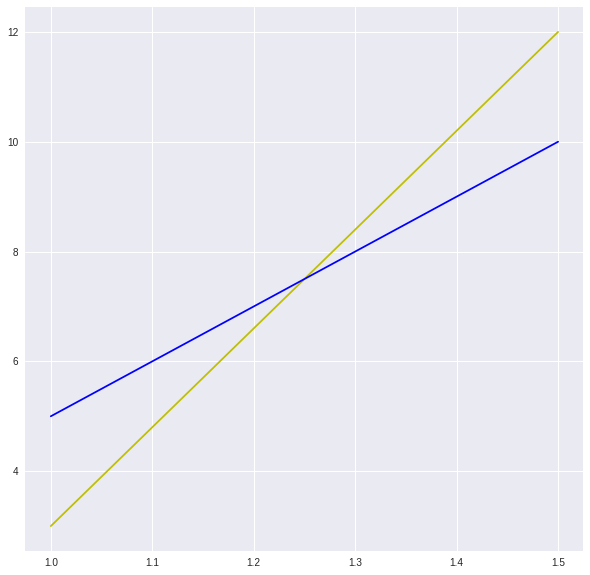

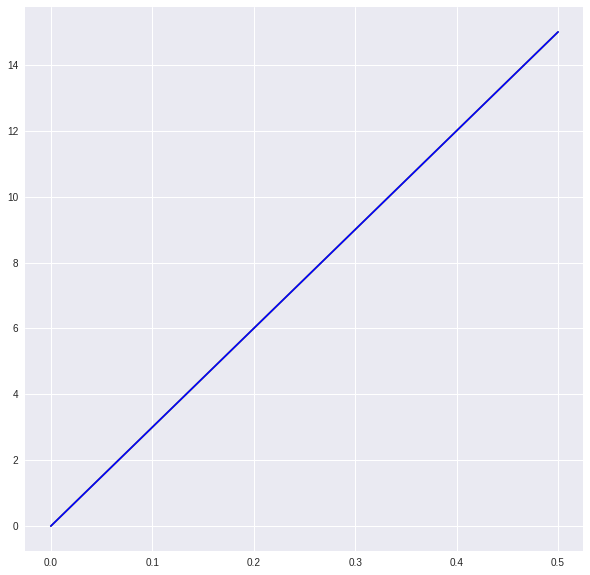

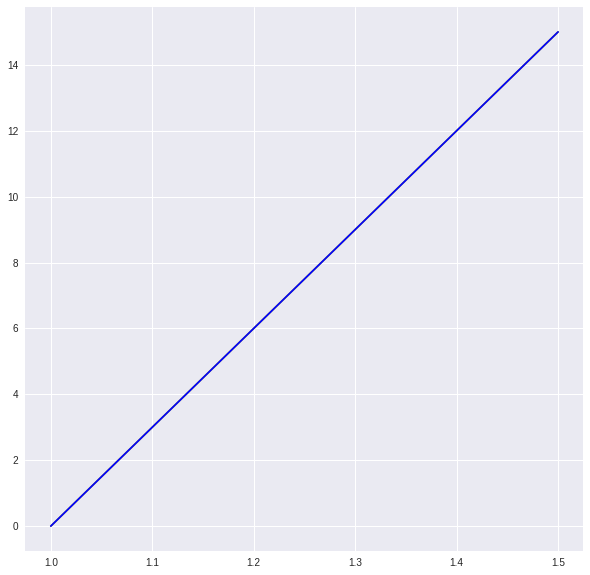

In [1351]:
plotScoresLine(resultsDictOnlyVoiceD1VSE, 'D1-VSE')

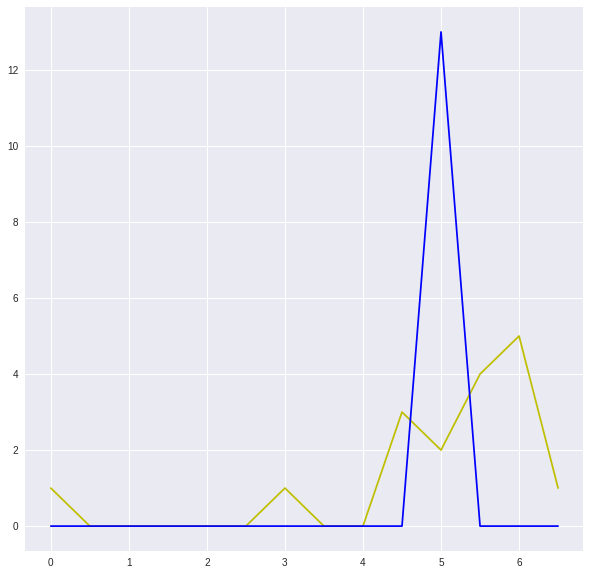

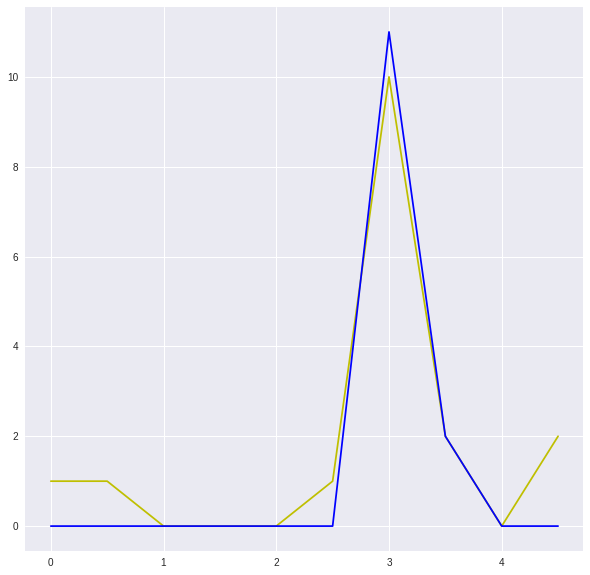

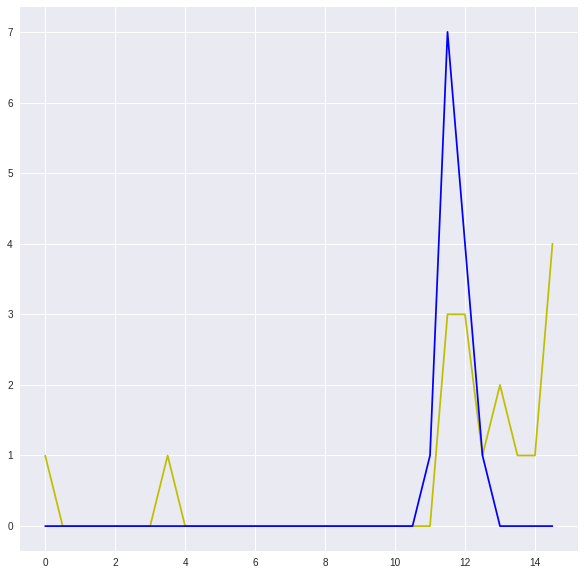

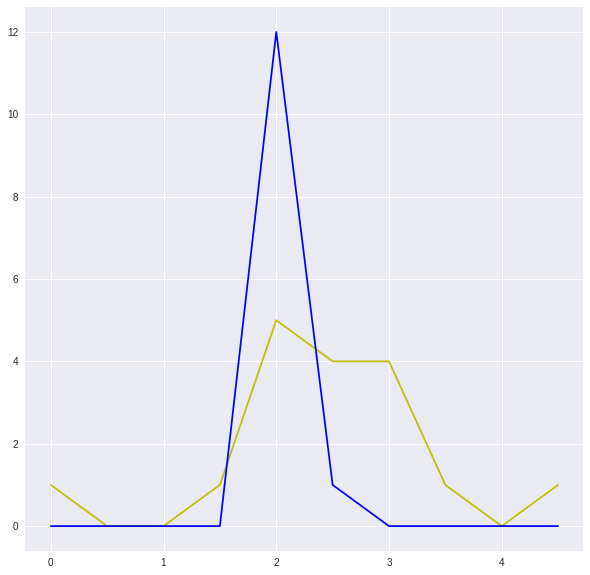

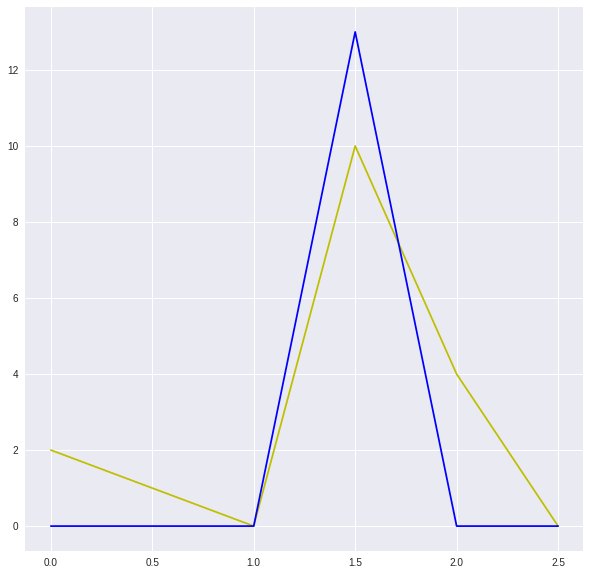

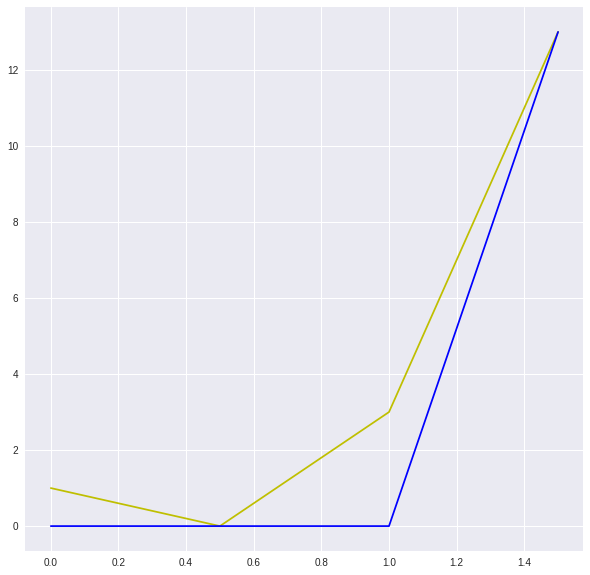

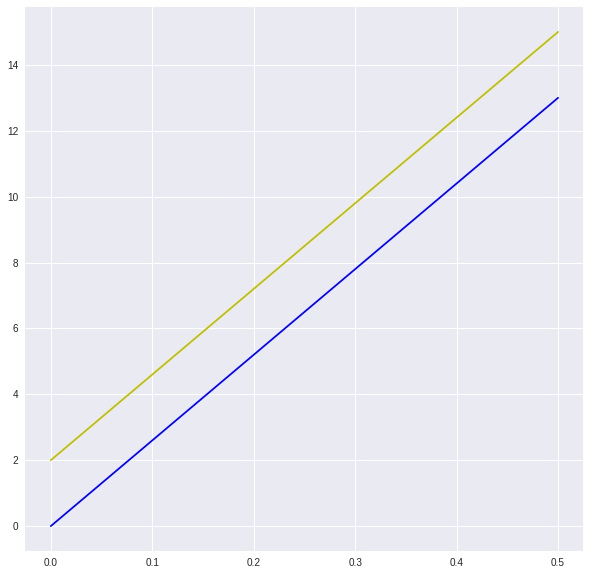

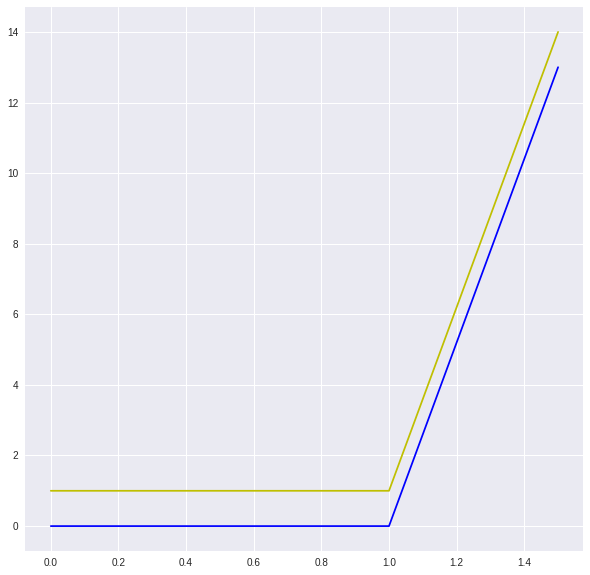

In [1352]:
plotScoresLine(resultsDictOnlyVoiceD2VSE, 'D2-VSE')

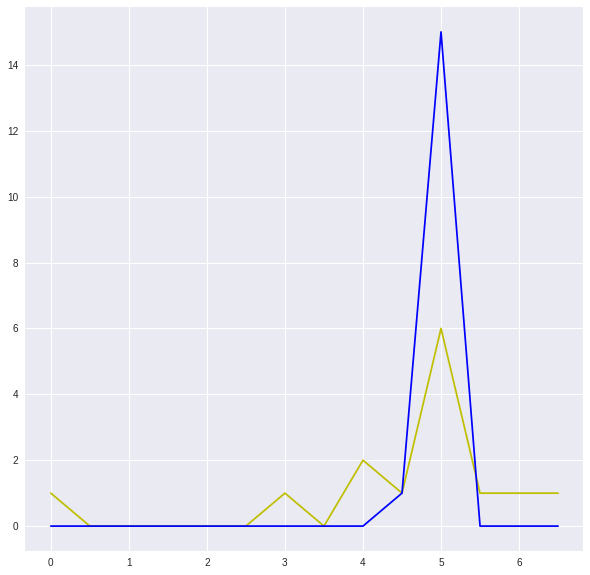

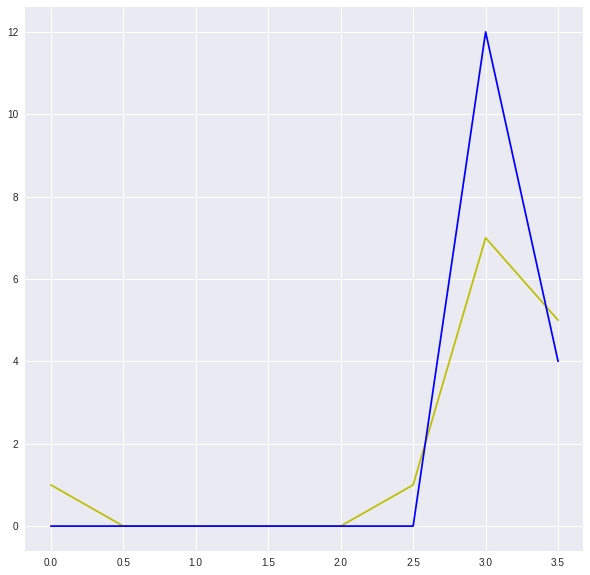

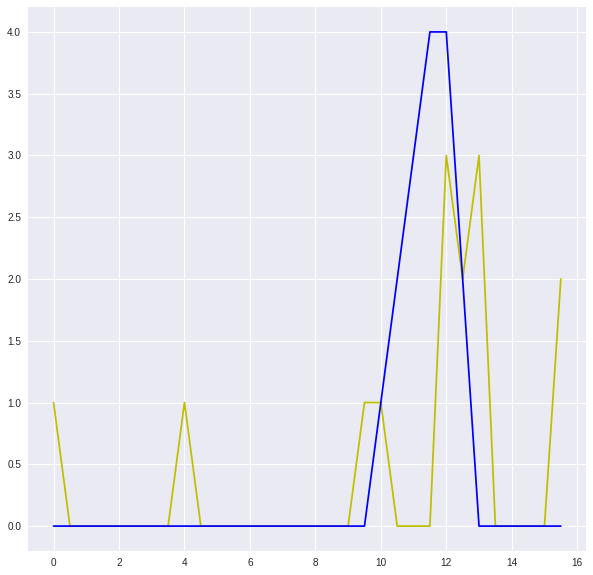

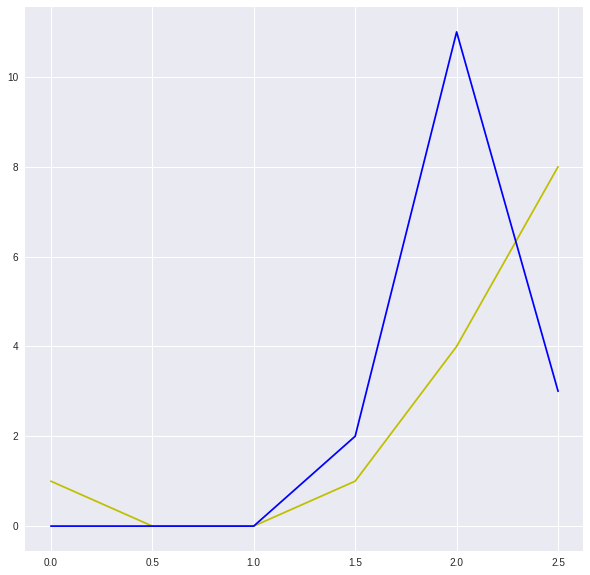

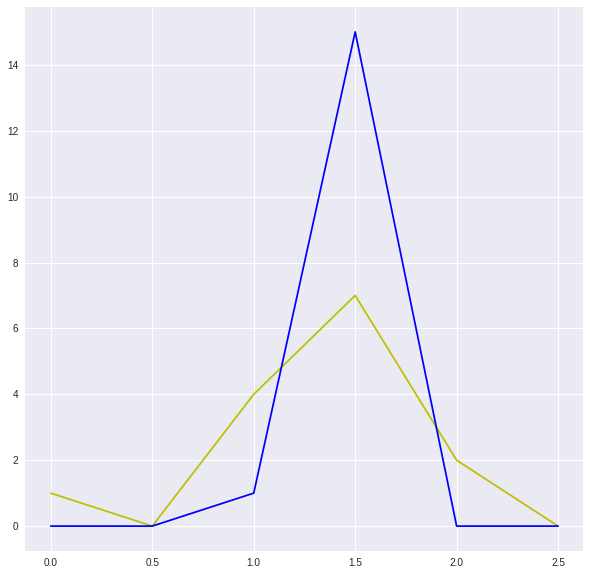

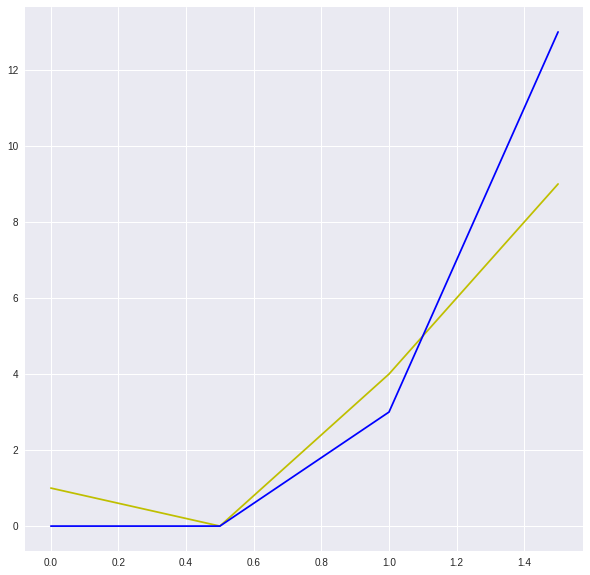

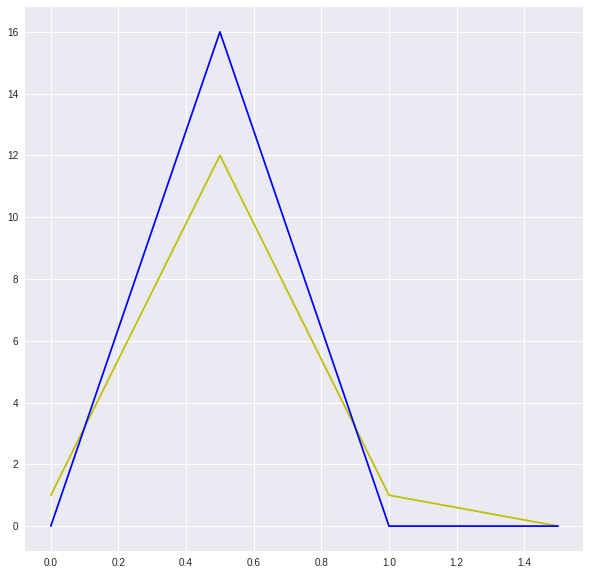

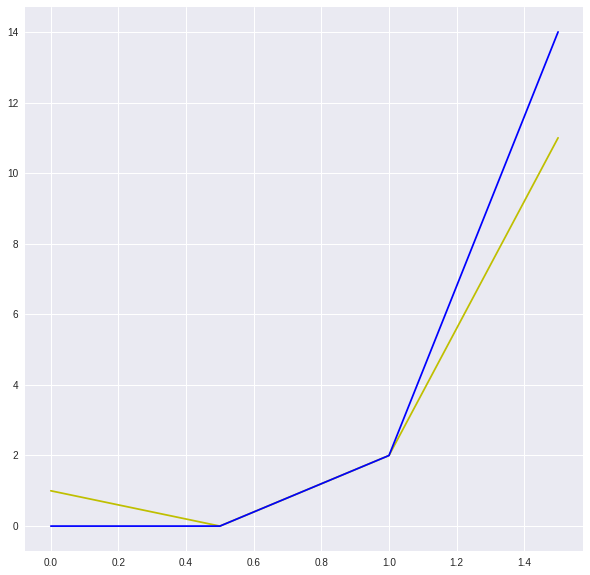

In [1353]:
plotScoresLine(resultsDictOnlyVoiceD3VSE, 'D3-VSE')

# 把最後一個音節拿掉或是分數給低一點（像是 d, t, b, p 之類的）

In [1377]:
def getTweetScoreRemoveLastPhonetic(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                if sym not in ['d', 't', 'b', 'p']:
                    score += eSPEDictV2[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV2[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictV2[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [1356]:
%%time
# Patient
groupD1RLPScores = []
for i, person in enumerate(groupD1Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    groupD1RLPScores.append(list(score))
    
groupD2RLPScores = []
for i, person in enumerate(groupD2Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    groupD2RLPScores.append(list(score))
    
groupD3RLPScores = []
for i, person in enumerate(groupD3Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    groupD3RLPScores.append(list(score))

CPU times: user 3min 4s, sys: 1.11 s, total: 3min 5s
Wall time: 3min 3s


In [1357]:
%%time
# Ordinary
baseD1RLPScores = []
for i, person in enumerate(baseD1Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    baseD1RLPScores.append(list(score))
    
baseD2RLPScores = []
for i, person in enumerate(baseD2Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    baseD2RLPScores.append(list(score))
    
baseD3RLPScores = []
for i, person in enumerate(baseD3Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhonetic(tweet)
    baseD3RLPScores.append(list(score))

CPU times: user 27.2 s, sys: 0 ns, total: 27.2 s
Wall time: 27.5 s


In [1358]:
groupD1RLPScores = standardizeFeatures(groupD1RLPScores)
groupD2RLPScores = standardizeFeatures(groupD2RLPScores)
groupD3RLPScores = standardizeFeatures(groupD3RLPScores)
baseD1RLPScores = standardizeFeatures(baseD1RLPScores)
baseD2RLPScores = standardizeFeatures(baseD2RLPScores)
baseD3RLPScores = standardizeFeatures(baseD3RLPScores)

In [1361]:
groupOnlyVoiceD1RLPScores = [ele[0:-1] for ele in groupD1RLPScores]
groupOnlyVoiceD2RLPScores = [ele[0:-1] for ele in groupD2RLPScores]
groupOnlyVoiceD3RLPScores = [ele[0:-1] for ele in groupD3RLPScores]
baseOnlyVoiceD1RLPScores = [ele[0:-1] for ele in baseD1RLPScores]
baseOnlyVoiceD2RLPScores = [ele[0:-1] for ele in baseD2RLPScores]
baseOnlyVoiceD3RLPScores = [ele[0:-1] for ele in baseD3RLPScores]

In [1366]:
classifierD1RLP = getRandomForestPrecision(baseD1RLPScores, groupD1RLPScores, 'RLP-D1')

Precision of RLP-D1
------------------------------
0	0.7666666666666667
1	0.7666666666666667
2	0.8
3	0.8
4	0.9333333333333333
5	0.7333333333333333
6	0.7
7	0.9
8	0.8333333333333334
9	0.7
------------------------------
Avg. precision: 0.7933333333333334


In [1367]:
classifierD2RLP = getRandomForestPrecision(baseD2RLPScores, groupD2RLPScores, 'RLP-D2')

Precision of RLP-D2
------------------------------
0	0.7666666666666667
1	0.8
2	0.7666666666666667
3	0.8666666666666667
4	0.7333333333333333
5	0.8
6	0.8
7	0.8333333333333334
8	0.7333333333333333
9	0.7333333333333333
------------------------------
Avg. precision: 0.7833333333333333


In [1368]:
classifierD3RLP = getRandomForestPrecision(baseD3RLPScores, groupD3RLPScores, 'RLP-D3')

Precision of RLP-D3
------------------------------
0	0.8333333333333334
1	0.8666666666666667
2	0.7666666666666667
3	0.7333333333333333
4	0.7666666666666667
5	0.8
6	0.6666666666666666
7	0.7333333333333333
8	0.8666666666666667
9	0.7
------------------------------
Avg. precision: 0.7733333333333333


In [1369]:
classifierOnlyVoiceD1RLP = getRandomForestPrecision(baseOnlyVoiceD1RLPScores, groupOnlyVoiceD1RLPScores, 'OnlyVoice-RLP-D1')

Precision of OnlyVoice-RLP-D1
------------------------------
0	0.8666666666666667
1	0.8333333333333334
2	0.8333333333333334
3	0.7333333333333333
4	0.7666666666666667
5	0.8666666666666667
6	0.8333333333333334
7	0.7
8	0.8333333333333334
9	0.7666666666666667
------------------------------
Avg. precision: 0.8033333333333333


In [1370]:
classifierOnlyVoiceD2RLP = getRandomForestPrecision(baseOnlyVoiceD2RLPScores, groupOnlyVoiceD2RLPScores, 'OnlyVoice-RLP-D2')

Precision of OnlyVoice-RLP-D2
------------------------------
0	0.7
1	0.8333333333333334
2	0.8333333333333334
3	0.6333333333333333
4	0.8
5	0.8
6	0.8
7	0.7666666666666667
8	0.6666666666666666
9	0.8
------------------------------
Avg. precision: 0.7633333333333333


In [1371]:
classifierOnlyVoiceD3RLP = getRandomForestPrecision(baseOnlyVoiceD3RLPScores, groupOnlyVoiceD3RLPScores, 'OnlyVoice-RLP-D3')

Precision of OnlyVoice-RLP-D3
------------------------------
0	0.7333333333333333
1	0.8
2	0.8
3	0.8333333333333334
4	0.8333333333333334
5	0.6666666666666666
6	0.8333333333333334
7	0.7333333333333333
8	0.7
9	0.7666666666666667
------------------------------
Avg. precision: 0.77


# 把最後一個音節非母音的都拿掉

In [1378]:
def getTweetScoreRemoveLastPhoneticV2(tweet):
    wordCount = 0
    words = tokenize(tweet)
    score = np.zeros((8,), dtype=np.int)
    for word in words:
        # 字典裡找不到這個字
        cmu, ipa = cv.convert(word)
        ipa = re.sub('[ˌˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                if sym not in ['j','w','r','l','p','b','f','v','m','t','d','θ','ð','n','s','z','ʧ','ʤ','ʃ','ʒ','k','g','ŋ','h']:
                    score += eSPEDictV2[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV2[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    score += eSPEDictV2[sym]
                    i += 1

    score = np.append(score, wordCount)
    return score

In [1379]:
%%time
# Patient
groupD1RLPV2Scores = []
for i, person in enumerate(groupD1Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    groupD1RLPV2Scores.append(list(score))
    
groupD2RLPV2Scores = []
for i, person in enumerate(groupD2Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    groupD2RLPV2Scores.append(list(score))
    
groupD3RLPV2Scores = []
for i, person in enumerate(groupD3Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    groupD3RLPV2Scores.append(list(score))

CPU times: user 3min 7s, sys: 1.22 s, total: 3min 8s
Wall time: 3min 4s


In [1380]:
%%time
# Patient
baseD1RLPV2Scores = []
for i, person in enumerate(baseD1Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    baseD1RLPV2Scores.append(list(score))
    
baseD2RLPV2Scores = []
for i, person in enumerate(baseD2Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    baseD2RLPV2Scores.append(list(score))
    
baseD3RLPV2Scores = []
for i, person in enumerate(baseD3Text):
    tweets = person.split('\n')
    score = np.zeros((9,), dtype=np.int)
    for tweet in tweets:
        score += getTweetScoreRemoveLastPhoneticV2(tweet)
    baseD3RLPV2Scores.append(list(score))

CPU times: user 27.9 s, sys: 232 ms, total: 28.1 s
Wall time: 27.3 s


In [1382]:
groupD1RLPV2Scores = standardizeFeatures(groupD1RLPV2Scores)
groupD2RLPV2Scores = standardizeFeatures(groupD2RLPV2Scores)
groupD3RLPV2Scores = standardizeFeatures(groupD3RLPV2Scores)
baseD1RLPV2Scores = standardizeFeatures(baseD1RLPV2Scores)
baseD2RLPV2Scores = standardizeFeatures(baseD2RLPV2Scores)
baseD3RLPV2Scores = standardizeFeatures(baseD3RLPV2Scores)

In [1383]:
groupOnlyVoiceD1RLPV2Scores = [ele[0:-1] for ele in groupD1RLPV2Scores]
groupOnlyVoiceD2RLPV2Scores = [ele[0:-1] for ele in groupD2RLPV2Scores]
groupOnlyVoiceD3RLPV2Scores = [ele[0:-1] for ele in groupD3RLPV2Scores]
baseOnlyVoiceD1RLPV2Scores = [ele[0:-1] for ele in baseD1RLPV2Scores]
baseOnlyVoiceD2RLPV2Scores = [ele[0:-1] for ele in baseD2RLPV2Scores]
baseOnlyVoiceD3RLPV2Scores = [ele[0:-1] for ele in baseD3RLPV2Scores]

In [1387]:
classifierD1RLPV2 = getRandomForestPrecision(baseD1RLPV2Scores, groupD1RLPV2Scores, 'RLPV2-D1')

Precision of RLPV2-D1
------------------------------
0	0.8
1	0.6666666666666666
2	0.8666666666666667
3	0.7
4	0.8
5	0.8666666666666667
6	0.9
7	0.7333333333333333
8	0.7666666666666667
9	0.8666666666666667
------------------------------
Avg. precision: 0.7966666666666666


In [1388]:
classifierD2RLPV2 = getRandomForestPrecision(baseD2RLPV2Scores, groupD2RLPV2Scores, 'RLPV2-D2')

Precision of RLPV2-D2
------------------------------
0	0.8666666666666667
1	0.9
2	0.7666666666666667
3	0.7333333333333333
4	0.7666666666666667
5	0.7666666666666667
6	0.8666666666666667
7	0.7
8	0.8333333333333334
9	0.7333333333333333
------------------------------
Avg. precision: 0.7933333333333332


In [1389]:
classifierD3RLPV2 = getRandomForestPrecision(baseD3RLPV2Scores, groupD3RLPV2Scores, 'RLPV2-D3')

Precision of RLPV2-D3
------------------------------
0	0.7333333333333333
1	1.0
2	0.9
3	0.7666666666666667
4	0.7
5	0.7666666666666667
6	0.6666666666666666
7	0.7666666666666667
8	0.7666666666666667
9	0.8
------------------------------
Avg. precision: 0.7866666666666666


In [1390]:
classifierOnlyVoiceD1RLPV2 = getRandomForestPrecision(baseOnlyVoiceD1RLPV2Scores, groupOnlyVoiceD1RLPV2Scores, 'OnlyVoice-RLPV2-D1')

Precision of OnlyVoice-RLPV2-D1
------------------------------
0	0.8666666666666667
1	0.7
2	0.8666666666666667
3	0.7666666666666667
4	0.7
5	0.7666666666666667
6	0.7
7	0.8333333333333334
8	0.9
9	0.7
------------------------------
Avg. precision: 0.78


In [1391]:
classifierOnlyVoiceD2RLPV2 = getRandomForestPrecision(baseOnlyVoiceD2RLPV2Scores, groupOnlyVoiceD2RLPV2Scores, 'OnlyVoice-RLPV2-D2')

Precision of OnlyVoice-RLPV2-D2
------------------------------
0	0.8
1	0.8333333333333334
2	0.6666666666666666
3	0.7333333333333333
4	0.8666666666666667
5	0.9
6	0.7
7	0.8333333333333334
8	0.9
9	0.8333333333333334
------------------------------
Avg. precision: 0.8066666666666666


In [1392]:
classifierOnlyVoiceD3RLPV2 = getRandomForestPrecision(baseOnlyVoiceD3RLPV2Scores, groupOnlyVoiceD3RLPV2Scores, 'OnlyVoice-RLPV2-D3')

Precision of OnlyVoice-RLPV2-D3
------------------------------
0	0.8333333333333334
1	0.7666666666666667
2	0.8333333333333334
3	0.7333333333333333
4	0.8
5	0.7333333333333333
6	0.8666666666666667
7	0.7666666666666667
8	0.8
9	0.7666666666666667
------------------------------
Avg. precision: 0.7899999999999999


# TODO: 只用類別 A, (B), C, D 分類

In [1409]:
groupD1FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD1Scores]
groupD2FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD2Scores]
groupD3FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD3Scores]
baseD1FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD1Scores]
baseD2FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD2Scores]
baseD3FCScores = [[ele[0],ele[1],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD3Scores]

In [1410]:
classifierD1FC = getRandomForestPrecision(baseD1FCScores, groupD1FCScores, 'FourClasses-D1')

Precision of FourClasses-D1
------------------------------
0	0.8
1	0.7333333333333333
2	0.8
3	0.8
4	0.7333333333333333
5	0.8333333333333334
6	0.8333333333333334
7	0.7666666666666667
8	0.7666666666666667
9	0.7
------------------------------
Avg. precision: 0.7766666666666666


In [1411]:
classifierD2FC = getRandomForestPrecision(baseD2FCScores, groupD2FCScores, 'FourClasses-D2')

Precision of FourClasses-D2
------------------------------
0	0.7666666666666667
1	0.8333333333333334
2	0.7666666666666667
3	0.7666666666666667
4	0.8333333333333334
5	0.7333333333333333
6	0.7666666666666667
7	0.8
8	0.7666666666666667
9	0.7666666666666667
------------------------------
Avg. precision: 0.78


In [1414]:
classifierD3FC = getRandomForestPrecision(baseD3FCScores, groupD3FCScores, 'FourClasses-D3')

Precision of FourClasses-D3
------------------------------
0	0.8333333333333334
1	0.7
2	0.8
3	0.7
4	0.7333333333333333
5	0.8666666666666667
6	0.8333333333333334
7	0.8
8	0.7666666666666667
9	0.7333333333333333
------------------------------
Avg. precision: 0.7766666666666666


In [1415]:
groupD1TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD1Scores]
groupD2TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD2Scores]
groupD3TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardGroupD3Scores]
baseD1TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD1Scores]
baseD2TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD2Scores]
baseD3TCScores = [[ele[0],ele[2],ele[3],ele[-1]] for ele in debugStandardBaseD3Scores]

In [1417]:
classifierD1TC = getRandomForestPrecision(baseD1TCScores, groupD1TCScores, 'ThreeClasses-D1')

Precision of ThreeClasses-D1
------------------------------
0	0.7333333333333333
1	0.8333333333333334
2	0.7
3	0.7
4	0.7666666666666667
5	0.8
6	0.8333333333333334
7	0.8333333333333334
8	0.7333333333333333
9	0.7666666666666667
------------------------------
Avg. precision: 0.7699999999999999


In [1418]:
classifierD2TC = getRandomForestPrecision(baseD2TCScores, groupD2TCScores, 'ThreeClasses-D2')

Precision of ThreeClasses-D2
------------------------------
0	0.7333333333333333
1	0.7333333333333333
2	0.7333333333333333
3	0.7333333333333333
4	0.6
5	0.8
6	0.8666666666666667
7	0.7666666666666667
8	0.6333333333333333
9	0.6333333333333333
------------------------------
Avg. precision: 0.7233333333333333


In [1419]:
classifierD3TC = getRandomForestPrecision(baseD3TCScores, groupD3TCScores, 'ThreeClasses-D3')

Precision of ThreeClasses-D3
------------------------------
0	0.9333333333333333
1	0.7666666666666667
2	0.8
3	0.6666666666666666
4	0.8
5	0.8
6	0.7333333333333333
7	0.6666666666666666
8	0.8333333333333334
9	0.8666666666666667
------------------------------
Avg. precision: 0.7866666666666667


In [1420]:
groupVoiceOnlyD1FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardGroupD1Scores]
groupVoiceOnlyD2FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardGroupD2Scores]
groupVoiceOnlyD3FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardGroupD3Scores]
baseVoiceOnlyD1FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardBaseD1Scores]
baseVoiceOnlyD2FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardBaseD2Scores]
baseVoiceOnlyD3FCScores = [[ele[0],ele[1],ele[2],ele[3]] for ele in debugStandardBaseD3Scores]

In [1421]:
classifierVoiceOnlyD1FC = getRandomForestPrecision(baseVoiceOnlyD1FCScores, groupVoiceOnlyD1FCScores, 'VoiceOnlyFC-D1')

Precision of VoiceOnlyFC-D1
------------------------------
0	0.7666666666666667
1	0.9333333333333333
2	0.8333333333333334
3	0.7333333333333333
4	0.7333333333333333
5	0.8
6	0.6333333333333333
7	0.8
8	0.6333333333333333
9	0.7666666666666667
------------------------------
Avg. precision: 0.7633333333333334


In [1422]:
classifierVoiceOnlyD2FC = getRandomForestPrecision(baseVoiceOnlyD2FCScores, groupVoiceOnlyD2FCScores, 'VoiceOnlyFC-D2')

Precision of VoiceOnlyFC-D2
------------------------------
0	0.8
1	0.7
2	0.8
3	0.7666666666666667
4	0.7666666666666667
5	0.7333333333333333
6	0.7333333333333333
7	0.6333333333333333
8	0.8666666666666667
9	0.6666666666666666
------------------------------
Avg. precision: 0.7466666666666668


In [1428]:
classifierVoiceOnlyD3FC = getRandomForestPrecision(baseVoiceOnlyD3FCScores, groupVoiceOnlyD3FCScores, 'VoiceOnlyFC-D3')

Precision of VoiceOnlyFC-D3
------------------------------
0	0.7
1	0.6
2	0.8666666666666667
3	0.6333333333333333
4	0.7333333333333333
5	0.7333333333333333
6	0.8333333333333334
7	0.6
8	0.6333333333333333
9	0.7
------------------------------
Avg. precision: 0.7033333333333333


In [1429]:
groupVoiceOnlyD1TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardGroupD1Scores]
groupVoiceOnlyD2TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardGroupD2Scores]
groupVoiceOnlyD3TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardGroupD3Scores]
baseVoiceOnlyD1TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardBaseD1Scores]
baseVoiceOnlyD2TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardBaseD2Scores]
baseVoiceOnlyD3TCScores = [[ele[0],ele[2],ele[3]] for ele in debugStandardBaseD3Scores]

In [1435]:
classifierVoiceOnlyD1TC = getRandomForestPrecision(baseVoiceOnlyD1TCScores, groupVoiceOnlyD1TCScores, 'VoiceOnlyTC-D1')

Precision of VoiceOnlyTC-D1
------------------------------
0	0.7333333333333333
1	0.8666666666666667
2	0.7666666666666667
3	0.8333333333333334
4	0.7333333333333333
5	0.7666666666666667
6	0.6333333333333333
7	0.7333333333333333
8	0.7
9	0.8333333333333334
------------------------------
Avg. precision: 0.76


In [1432]:
classifierVoiceOnlyD2TC = getRandomForestPrecision(baseVoiceOnlyD2TCScores, groupVoiceOnlyD2TCScores, 'VoiceOnlyTC-D2')

Precision of VoiceOnlyTC-D2
------------------------------
0	0.8
1	0.8333333333333334
2	0.6
3	0.7666666666666667
4	0.7666666666666667
5	0.7666666666666667
6	0.8
7	0.7333333333333333
8	0.7
9	0.8333333333333334
------------------------------
Avg. precision: 0.76


In [1434]:
classifierVoiceOnlyD3TC = getRandomForestPrecision(baseVoiceOnlyD3TCScores, groupVoiceOnlyD3TCScores, 'VoiceOnlyTC-D3')

Precision of VoiceOnlyTC-D3
------------------------------
0	0.7
1	0.7
2	0.7666666666666667
3	0.7666666666666667
4	0.8666666666666667
5	0.6333333333333333
6	0.7666666666666667
7	0.6666666666666666
8	0.6666666666666666
9	0.7
------------------------------
Avg. precision: 0.7233333333333334


# Precision

In [1559]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [1552]:
def getAveragePrecision(cls, baseData, groupData):
    LABELS = []
    PREDICTS = []
    PREDICTBIS = []
    target_names = ['class 0', 'class 1']
    
    
    
    for cl in cls:
        print(cl.name)
        testIndex = list(cl.test_index)
        LABEL_ = []
        PREDICT_ = []
        for ele in testIndex:
            if ele < 150:
                LABELS.append(0)
                PREDICTS.append(cl.classifier.predict_proba([baseData[ele]])[:,1])
                tmp = 
                PREDICTBIS.append(cl.classifier.predict([baseData[ele]])[0])
            else:
                LABELS.append(1)
                PREDICTS.append(cl.classifier.predict_proba([groupData[ele-150]])[:,1])
                PREDICTBIS.append(cl.classifier.predict([groupData[ele-150]])[0])
            
            print(classification_report(LABELS, PREDICTBIS, target_names=target_names))
    
    
#     average_precision2 = average_precision_score(LABELS, PREDICTS)
#     average_precision = average_precision_score(LABELS, PREDICTBIS)
#     recall_multiclasses = recall_score(LABELS, PREDICTBIS)
#     recall = recall_score(LABELS, PREDICTBIS, average=None)
#     f1_multiclasses = f1_score(LABELS, PREDICTBIS)
#     f1 = f1_score(LABELS, PREDICTBIS, average=None)
    
    print('LABELS: ', LABELS)
    print('PREDICTBIS: ', PREDICTBIS)
    
#     print('Avg Precision2: ', average_precision2)
#     print('Avg Precision: ', average_precision)
#     print('Recall Multicalsses: ', recall_multiclasses)
#     print('Recall: ', recall)
#     print('F1 Multicalsses: ', f1_multiclasses)
#     print('F1: ', f1)
    
#     print(classification_report(LABELS, PREDICTBIS, target_names=target_names))


In [1555]:
LABEL_TEST = [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]
PREDICT_TEST = [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]

In [1567]:
precision_score(LABEL_TEST[0:30], PREDICT_TEST[0:30])

0.66666666666666663

In [1568]:
LABEL_TEST[0:30]

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0]

In [1531]:
getAveragePrecision(classifierDebugStandardD1, debugStandardBaseD1Scores, debugStandardGroupD1Scores)

DebugStandard-D1-0
DebugStandard-D1-1
DebugStandard-D1-2
DebugStandard-D1-3
DebugStandard-D1-4
DebugStandard-D1-5
DebugStandard-D1-6
DebugStandard-D1-7
DebugStandard-D1-8
DebugStandard-D1-9
             precision    recall  f1-score   support

    class 0       0.74      0.85      0.80       150
    class 1       0.83      0.71      0.76       150

avg / total       0.79      0.78      0.78       300



In [1498]:
getAveragePrecision(classifierDebugStandardD1, debugStandardBaseD1Scores, debugStandardGroupD1Scores)

DebugStandard-D1-0
DebugStandard-D1-1
DebugStandard-D1-2
DebugStandard-D1-3
DebugStandard-D1-4
DebugStandard-D1-5
DebugStandard-D1-6
DebugStandard-D1-7
DebugStandard-D1-8
DebugStandard-D1-9
Avg Precision2:  0.864608295384
Avg Precision:  0.731875
Recall Multicalsses:  0.706666666667
Recall:  [ 0.85333333  0.70666667]
F1 Multicalsses:  0.762589928058
F1:  [ 0.79503106  0.76258993]


In [1532]:
getAveragePrecision(classifierDebugStandardD2, debugStandardBaseD2Scores, debugStandardGroupD2Scores)

DebugStandard-D2-0
DebugStandard-D2-1
DebugStandard-D2-2
DebugStandard-D2-3
DebugStandard-D2-4
DebugStandard-D2-5
DebugStandard-D2-6
DebugStandard-D2-7
DebugStandard-D2-8
DebugStandard-D2-9
             precision    recall  f1-score   support

    class 0       0.77      0.85      0.81       150
    class 1       0.83      0.75      0.79       150

avg / total       0.80      0.80      0.80       300



In [1499]:
getAveragePrecision(classifierDebugStandardD2, debugStandardBaseD2Scores, debugStandardGroupD2Scores)

DebugStandard-D2-0
DebugStandard-D2-1
DebugStandard-D2-2
DebugStandard-D2-3
DebugStandard-D2-4
DebugStandard-D2-5
DebugStandard-D2-6
DebugStandard-D2-7
DebugStandard-D2-8
DebugStandard-D2-9
Avg Precision2:  0.872644648886
Avg Precision:  0.749264705882
Recall Multicalsses:  0.753333333333
Recall:  [ 0.84666667  0.75333333]
F1 Multicalsses:  0.79020979021
F1:  [ 0.8089172   0.79020979]


In [1533]:
getAveragePrecision(classifierDebugStandardD3, debugStandardBaseD3Scores, debugStandardGroupD3Scores)

DebugStandard-D3-0
DebugStandard-D3-1
DebugStandard-D3-2
DebugStandard-D3-3
DebugStandard-D3-4
DebugStandard-D3-5
DebugStandard-D3-6
DebugStandard-D3-7
DebugStandard-D3-8
DebugStandard-D3-9
             precision    recall  f1-score   support

    class 0       0.77      0.83      0.80       150
    class 1       0.82      0.75      0.78       150

avg / total       0.79      0.79      0.79       300



In [1500]:
getAveragePrecision(classifierDebugStandardD3, debugStandardBaseD3Scores, debugStandardGroupD3Scores)

DebugStandard-D3-0
DebugStandard-D3-1
DebugStandard-D3-2
DebugStandard-D3-3
DebugStandard-D3-4
DebugStandard-D3-5
DebugStandard-D3-6
DebugStandard-D3-7
DebugStandard-D3-8
DebugStandard-D3-9
Avg Precision2:  0.853783104778
Avg Precision:  0.737080291971
Recall Multicalsses:  0.746666666667
Recall:  [ 0.83333333  0.74666667]
F1 Multicalsses:  0.780487804878
F1:  [ 0.79872204  0.7804878 ]


In [1534]:
getAveragePrecision(classifierOnlyVoiceD1, onlyVoiceBaseD1Scores, onlyVoiceGroupD1Scores)

OnlyVoice-D1-0
OnlyVoice-D1-1
OnlyVoice-D1-2
OnlyVoice-D1-3
OnlyVoice-D1-4
OnlyVoice-D1-5
OnlyVoice-D1-6
OnlyVoice-D1-7
OnlyVoice-D1-8
OnlyVoice-D1-9
             precision    recall  f1-score   support

    class 0       0.79      0.81      0.80       150
    class 1       0.81      0.79      0.80       150

avg / total       0.80      0.80      0.80       300



In [1501]:
getAveragePrecision(classifierOnlyVoiceD1, onlyVoiceBaseD1Scores, onlyVoiceGroupD1Scores)

OnlyVoice-D1-0
OnlyVoice-D1-1
OnlyVoice-D1-2
OnlyVoice-D1-3
OnlyVoice-D1-4
OnlyVoice-D1-5
OnlyVoice-D1-6
OnlyVoice-D1-7
OnlyVoice-D1-8
OnlyVoice-D1-9
Avg Precision2:  0.872649329933
Avg Precision:  0.742465753425
Recall Multicalsses:  0.786666666667
Recall:  [ 0.81333333  0.78666667]
F1 Multicalsses:  0.797297297297
F1:  [ 0.80263158  0.7972973 ]


In [1535]:
getAveragePrecision(classifierOnlyVoiceD2, onlyVoiceBaseD2Scores, onlyVoiceGroupD2Scores)

OnlyVoice-D2-0
OnlyVoice-D2-1
OnlyVoice-D2-2
OnlyVoice-D2-3
OnlyVoice-D2-4
OnlyVoice-D2-5
OnlyVoice-D2-6
OnlyVoice-D2-7
OnlyVoice-D2-8
OnlyVoice-D2-9
             precision    recall  f1-score   support

    class 0       0.81      0.74      0.77       150
    class 1       0.76      0.83      0.79       150

avg / total       0.79      0.78      0.78       300



In [1502]:
getAveragePrecision(classifierOnlyVoiceD2, onlyVoiceBaseD2Scores, onlyVoiceGroupD2Scores)

OnlyVoice-D2-0
OnlyVoice-D2-1
OnlyVoice-D2-2
OnlyVoice-D2-3
OnlyVoice-D2-4
OnlyVoice-D2-5
OnlyVoice-D2-6
OnlyVoice-D2-7
OnlyVoice-D2-8
OnlyVoice-D2-9
Avg Precision2:  0.854407842256
Avg Precision:  0.71554192229
Recall Multicalsses:  0.826666666667
Recall:  [ 0.74        0.82666667]
F1 Multicalsses:  0.792332268371
F1:  [ 0.77351916  0.79233227]


In [1536]:
getAveragePrecision(classifierOnlyVoiceD3, onlyVoiceBaseD3Scores, onlyVoiceGroupD3Scores)

OnlyVoice-D3-0
OnlyVoice-D3-1
OnlyVoice-D3-2
OnlyVoice-D3-3
OnlyVoice-D3-4
OnlyVoice-D3-5
OnlyVoice-D3-6
OnlyVoice-D3-7
OnlyVoice-D3-8
OnlyVoice-D3-9
             precision    recall  f1-score   support

    class 0       0.76      0.77      0.77       150
    class 1       0.77      0.76      0.77       150

avg / total       0.77      0.77      0.77       300



In [1503]:
getAveragePrecision(classifierOnlyVoiceD3, onlyVoiceBaseD3Scores, onlyVoiceGroupD3Scores)

OnlyVoice-D3-0
OnlyVoice-D3-1
OnlyVoice-D3-2
OnlyVoice-D3-3
OnlyVoice-D3-4
OnlyVoice-D3-5
OnlyVoice-D3-6
OnlyVoice-D3-7
OnlyVoice-D3-8
OnlyVoice-D3-9
Avg Precision2:  0.817376112332
Avg Precision:  0.705405405405
Recall Multicalsses:  0.76
Recall:  [ 0.77333333  0.76      ]
F1 Multicalsses:  0.765100671141
F1:  [ 0.76821192  0.76510067]


In [1537]:
getAveragePrecision(classifierD1RLP, baseD1RLPScores, groupD1RLPScores)

RLP-D1-0
RLP-D1-1
RLP-D1-2
RLP-D1-3
RLP-D1-4
RLP-D1-5
RLP-D1-6
RLP-D1-7
RLP-D1-8
RLP-D1-9
             precision    recall  f1-score   support

    class 0       0.78      0.81      0.80       150
    class 1       0.81      0.77      0.79       150

avg / total       0.79      0.79      0.79       300



In [1504]:
getAveragePrecision(classifierD1RLP, baseD1RLPScores, groupD1RLPScores)

RLP-D1-0
RLP-D1-1
RLP-D1-2
RLP-D1-3
RLP-D1-4
RLP-D1-5
RLP-D1-6
RLP-D1-7
RLP-D1-8
RLP-D1-9
Avg Precision2:  0.882574401591
Avg Precision:  0.736296296296
Recall Multicalsses:  0.773333333333
Recall:  [ 0.81333333  0.77333333]
F1 Multicalsses:  0.789115646259
F1:  [ 0.79738562  0.78911565]


In [1538]:
getAveragePrecision(classifierD2RLP, baseD2RLPScores, groupD2RLPScores)

RLP-D2-0
RLP-D2-1
RLP-D2-2
RLP-D2-3
RLP-D2-4
RLP-D2-5
RLP-D2-6
RLP-D2-7
RLP-D2-8
RLP-D2-9
             precision    recall  f1-score   support

    class 0       0.74      0.88      0.80       150
    class 1       0.85      0.69      0.76       150

avg / total       0.79      0.78      0.78       300



In [1505]:
getAveragePrecision(classifierD2RLP, baseD2RLPScores, groupD2RLPScores)

RLP-D2-0
RLP-D2-1
RLP-D2-2
RLP-D2-3
RLP-D2-4
RLP-D2-5
RLP-D2-6
RLP-D2-7
RLP-D2-8
RLP-D2-9
Avg Precision2:  0.866277338129
Avg Precision:  0.741184573003
Recall Multicalsses:  0.686666666667
Recall:  [ 0.88        0.68666667]
F1 Multicalsses:  0.760147601476
F1:  [ 0.80243161  0.7601476 ]


In [1539]:
getAveragePrecision(classifierD3RLP, baseD3RLPScores, groupD3RLPScores)

RLP-D3-0
RLP-D3-1
RLP-D3-2
RLP-D3-3
RLP-D3-4
RLP-D3-5
RLP-D3-6
RLP-D3-7
RLP-D3-8
RLP-D3-9
             precision    recall  f1-score   support

    class 0       0.75      0.82      0.78       150
    class 1       0.80      0.73      0.76       150

avg / total       0.78      0.77      0.77       300



In [1506]:
getAveragePrecision(classifierD3RLP, baseD3RLPScores, groupD3RLPScores)

RLP-D3-0
RLP-D3-1
RLP-D3-2
RLP-D3-3
RLP-D3-4
RLP-D3-5
RLP-D3-6
RLP-D3-7
RLP-D3-8
RLP-D3-9
Avg Precision2:  0.820218056976
Avg Precision:  0.719068627451
Recall Multicalsses:  0.726666666667
Recall:  [ 0.82        0.72666667]
F1 Multicalsses:  0.762237762238
F1:  [ 0.78343949  0.76223776]


In [1540]:
getAveragePrecision(classifierOnlyVoiceD1RLP, baseOnlyVoiceD1RLPScores, groupOnlyVoiceD1RLPScores)

OnlyVoice-RLP-D1-0
OnlyVoice-RLP-D1-1
OnlyVoice-RLP-D1-2
OnlyVoice-RLP-D1-3
OnlyVoice-RLP-D1-4
OnlyVoice-RLP-D1-5
OnlyVoice-RLP-D1-6
OnlyVoice-RLP-D1-7
OnlyVoice-RLP-D1-8
OnlyVoice-RLP-D1-9
             precision    recall  f1-score   support

    class 0       0.81      0.80      0.80       150
    class 1       0.80      0.81      0.80       150

avg / total       0.80      0.80      0.80       300



In [1507]:
getAveragePrecision(classifierOnlyVoiceD1RLP, baseOnlyVoiceD1RLPScores, groupOnlyVoiceD1RLPScores)

OnlyVoice-RLP-D1-0
OnlyVoice-RLP-D1-1
OnlyVoice-RLP-D1-2
OnlyVoice-RLP-D1-3
OnlyVoice-RLP-D1-4
OnlyVoice-RLP-D1-5
OnlyVoice-RLP-D1-6
OnlyVoice-RLP-D1-7
OnlyVoice-RLP-D1-8
OnlyVoice-RLP-D1-9
Avg Precision2:  0.872872880296
Avg Precision:  0.743068432671
Recall Multicalsses:  0.806666666667
Recall:  [ 0.8         0.80666667]
F1 Multicalsses:  0.803986710963
F1:  [ 0.80267559  0.80398671]


In [1541]:
getAveragePrecision(classifierOnlyVoiceD2RLP, baseOnlyVoiceD2RLPScores, groupOnlyVoiceD2RLPScores)

OnlyVoice-RLP-D2-0
OnlyVoice-RLP-D2-1
OnlyVoice-RLP-D2-2
OnlyVoice-RLP-D2-3
OnlyVoice-RLP-D2-4
OnlyVoice-RLP-D2-5
OnlyVoice-RLP-D2-6
OnlyVoice-RLP-D2-7
OnlyVoice-RLP-D2-8
OnlyVoice-RLP-D2-9
             precision    recall  f1-score   support

    class 0       0.79      0.71      0.75       150
    class 1       0.74      0.81      0.77       150

avg / total       0.77      0.76      0.76       300



In [1509]:
getAveragePrecision(classifierOnlyVoiceD2RLP, baseOnlyVoiceD2RLPScores, groupOnlyVoiceD2RLPScores)

OnlyVoice-RLP-D2-0
OnlyVoice-RLP-D2-1
OnlyVoice-RLP-D2-2
OnlyVoice-RLP-D2-3
OnlyVoice-RLP-D2-4
OnlyVoice-RLP-D2-5
OnlyVoice-RLP-D2-6
OnlyVoice-RLP-D2-7
OnlyVoice-RLP-D2-8
OnlyVoice-RLP-D2-9
Avg Precision2:  0.817957988765
Avg Precision:  0.694707070707
Recall Multicalsses:  0.813333333333
Recall:  [ 0.71333333  0.81333333]
F1 Multicalsses:  0.774603174603
F1:  [ 0.75087719  0.77460317]


In [1542]:
getAveragePrecision(classifierOnlyVoiceD3RLP, baseOnlyVoiceD3RLPScores, groupOnlyVoiceD3RLPScores)

OnlyVoice-RLP-D3-0
OnlyVoice-RLP-D3-1
OnlyVoice-RLP-D3-2
OnlyVoice-RLP-D3-3
OnlyVoice-RLP-D3-4
OnlyVoice-RLP-D3-5
OnlyVoice-RLP-D3-6
OnlyVoice-RLP-D3-7
OnlyVoice-RLP-D3-8
OnlyVoice-RLP-D3-9
             precision    recall  f1-score   support

    class 0       0.79      0.74      0.76       150
    class 1       0.75      0.80      0.78       150

avg / total       0.77      0.77      0.77       300



In [1510]:
getAveragePrecision(classifierOnlyVoiceD3RLP, baseOnlyVoiceD3RLPScores, groupOnlyVoiceD3RLPScores)

OnlyVoice-RLP-D3-0
OnlyVoice-RLP-D3-1
OnlyVoice-RLP-D3-2
OnlyVoice-RLP-D3-3
OnlyVoice-RLP-D3-4
OnlyVoice-RLP-D3-5
OnlyVoice-RLP-D3-6
OnlyVoice-RLP-D3-7
OnlyVoice-RLP-D3-8
OnlyVoice-RLP-D3-9
Avg Precision2:  0.844967826588
Avg Precision:  0.703773584906
Recall Multicalsses:  0.8
Recall:  [ 0.74  0.8 ]
F1 Multicalsses:  0.776699029126
F1:  [ 0.7628866   0.77669903]


In [1543]:
getAveragePrecision(classifierD1RLPV2, baseD1RLPV2Scores, groupD1RLPV2Scores)

RLPV2-D1-0
RLPV2-D1-1
RLPV2-D1-2
RLPV2-D1-3
RLPV2-D1-4
RLPV2-D1-5
RLPV2-D1-6
RLPV2-D1-7
RLPV2-D1-8
RLPV2-D1-9
             precision    recall  f1-score   support

    class 0       0.78      0.82      0.80       150
    class 1       0.81      0.77      0.79       150

avg / total       0.80      0.80      0.80       300



In [1511]:
getAveragePrecision(classifierD1RLPV2, baseD1RLPV2Scores, groupD1RLPV2Scores)

RLPV2-D1-0
RLPV2-D1-1
RLPV2-D1-2
RLPV2-D1-3
RLPV2-D1-4
RLPV2-D1-5
RLPV2-D1-6
RLPV2-D1-7
RLPV2-D1-8
RLPV2-D1-9
Avg Precision2:  0.885469453922
Avg Precision:  0.740652680653
Recall Multicalsses:  0.773333333333
Recall:  [ 0.82        0.77333333]
F1 Multicalsses:  0.79180887372
F1:  [ 0.80130293  0.79180887]


In [1544]:
getAveragePrecision(classifierD2RLPV2, baseD2RLPV2Scores, groupD2RLPV2Scores)

RLPV2-D2-0
RLPV2-D2-1
RLPV2-D2-2
RLPV2-D2-3
RLPV2-D2-4
RLPV2-D2-5
RLPV2-D2-6
RLPV2-D2-7
RLPV2-D2-8
RLPV2-D2-9
             precision    recall  f1-score   support

    class 0       0.78      0.82      0.80       150
    class 1       0.81      0.77      0.79       150

avg / total       0.79      0.79      0.79       300



In [1512]:
getAveragePrecision(classifierD2RLPV2, baseD2RLPV2Scores, groupD2RLPV2Scores)

RLPV2-D2-0
RLPV2-D2-1
RLPV2-D2-2
RLPV2-D2-3
RLPV2-D2-4
RLPV2-D2-5
RLPV2-D2-6
RLPV2-D2-7
RLPV2-D2-8
RLPV2-D2-9
Avg Precision2:  0.867727213005
Avg Precision:  0.737558685446
Recall Multicalsses:  0.766666666667
Recall:  [ 0.82        0.76666667]
F1 Multicalsses:  0.787671232877
F1:  [ 0.7987013   0.78767123]


In [1545]:
getAveragePrecision(classifierD3RLPV2, baseD3RLPV2Scores, groupD3RLPV2Scores)

RLPV2-D3-0
RLPV2-D3-1
RLPV2-D3-2
RLPV2-D3-3
RLPV2-D3-4
RLPV2-D3-5
RLPV2-D3-6
RLPV2-D3-7
RLPV2-D3-8
RLPV2-D3-9
             precision    recall  f1-score   support

    class 0       0.76      0.84      0.80       150
    class 1       0.82      0.73      0.77       150

avg / total       0.79      0.79      0.79       300



In [1513]:
getAveragePrecision(classifierD3RLPV2, baseD3RLPV2Scores, groupD3RLPV2Scores)

RLPV2-D3-0
RLPV2-D3-1
RLPV2-D3-2
RLPV2-D3-3
RLPV2-D3-4
RLPV2-D3-5
RLPV2-D3-6
RLPV2-D3-7
RLPV2-D3-8
RLPV2-D3-9
Avg Precision2:  0.856551171416
Avg Precision:  0.735323383085
Recall Multicalsses:  0.733333333333
Recall:  [ 0.84        0.73333333]
F1 Multicalsses:  0.774647887324
F1:  [ 0.79746835  0.77464789]


In [1546]:
getAveragePrecision(classifierOnlyVoiceD1RLPV2, baseOnlyVoiceD1RLPV2Scores, groupOnlyVoiceD1RLPV2Scores)

OnlyVoice-RLPV2-D1-0
OnlyVoice-RLPV2-D1-1
OnlyVoice-RLPV2-D1-2
OnlyVoice-RLPV2-D1-3
OnlyVoice-RLPV2-D1-4
OnlyVoice-RLPV2-D1-5
OnlyVoice-RLPV2-D1-6
OnlyVoice-RLPV2-D1-7
OnlyVoice-RLPV2-D1-8
OnlyVoice-RLPV2-D1-9
             precision    recall  f1-score   support

    class 0       0.77      0.79      0.78       150
    class 1       0.79      0.77      0.78       150

avg / total       0.78      0.78      0.78       300



In [1514]:
getAveragePrecision(classifierOnlyVoiceD1RLPV2, baseOnlyVoiceD1RLPV2Scores, groupOnlyVoiceD1RLPV2Scores)

OnlyVoice-RLPV2-D1-0
OnlyVoice-RLPV2-D1-1
OnlyVoice-RLPV2-D1-2
OnlyVoice-RLPV2-D1-3
OnlyVoice-RLPV2-D1-4
OnlyVoice-RLPV2-D1-5
OnlyVoice-RLPV2-D1-6
OnlyVoice-RLPV2-D1-7
OnlyVoice-RLPV2-D1-8
OnlyVoice-RLPV2-D1-9
Avg Precision2:  0.834243277452
Avg Precision:  0.720547945205
Recall Multicalsses:  0.766666666667
Recall:  [ 0.79333333  0.76666667]
F1 Multicalsses:  0.777027027027
F1:  [ 0.78289474  0.77702703]


In [1547]:
getAveragePrecision(classifierOnlyVoiceD2RLPV2, baseOnlyVoiceD2RLPV2Scores, groupOnlyVoiceD2RLPV2Scores)

OnlyVoice-RLPV2-D2-0
OnlyVoice-RLPV2-D2-1
OnlyVoice-RLPV2-D2-2
OnlyVoice-RLPV2-D2-3
OnlyVoice-RLPV2-D2-4
OnlyVoice-RLPV2-D2-5
OnlyVoice-RLPV2-D2-6
OnlyVoice-RLPV2-D2-7
OnlyVoice-RLPV2-D2-8
OnlyVoice-RLPV2-D2-9
             precision    recall  f1-score   support

    class 0       0.79      0.84      0.81       150
    class 1       0.83      0.77      0.80       150

avg / total       0.81      0.81      0.81       300



In [1515]:
getAveragePrecision(classifierOnlyVoiceD2RLPV2, baseOnlyVoiceD2RLPV2Scores, groupOnlyVoiceD2RLPV2Scores)

OnlyVoice-RLPV2-D2-0
OnlyVoice-RLPV2-D2-1
OnlyVoice-RLPV2-D2-2
OnlyVoice-RLPV2-D2-3
OnlyVoice-RLPV2-D2-4
OnlyVoice-RLPV2-D2-5
OnlyVoice-RLPV2-D2-6
OnlyVoice-RLPV2-D2-7
OnlyVoice-RLPV2-D2-8
OnlyVoice-RLPV2-D2-9
Avg Precision2:  0.863842234131
Avg Precision:  0.754095238095
Recall Multicalsses:  0.773333333333
Recall:  [ 0.84        0.77333333]
F1 Multicalsses:  0.8
F1:  [ 0.81290323  0.8       ]


In [1548]:
getAveragePrecision(classifierOnlyVoiceD3RLPV2, baseOnlyVoiceD3RLPV2Scores, groupOnlyVoiceD3RLPV2Scores)

OnlyVoice-RLPV2-D3-0
OnlyVoice-RLPV2-D3-1
OnlyVoice-RLPV2-D3-2
OnlyVoice-RLPV2-D3-3
OnlyVoice-RLPV2-D3-4
OnlyVoice-RLPV2-D3-5
OnlyVoice-RLPV2-D3-6
OnlyVoice-RLPV2-D3-7
OnlyVoice-RLPV2-D3-8
OnlyVoice-RLPV2-D3-9
             precision    recall  f1-score   support

    class 0       0.78      0.81      0.79       150
    class 1       0.80      0.77      0.79       150

avg / total       0.79      0.79      0.79       300



In [1516]:
getAveragePrecision(classifierOnlyVoiceD3RLPV2, baseOnlyVoiceD3RLPV2Scores, groupOnlyVoiceD3RLPV2Scores)

OnlyVoice-RLPV2-D3-0
OnlyVoice-RLPV2-D3-1
OnlyVoice-RLPV2-D3-2
OnlyVoice-RLPV2-D3-3
OnlyVoice-RLPV2-D3-4
OnlyVoice-RLPV2-D3-5
OnlyVoice-RLPV2-D3-6
OnlyVoice-RLPV2-D3-7
OnlyVoice-RLPV2-D3-8
OnlyVoice-RLPV2-D3-9
Avg Precision2:  0.816843586595
Avg Precision:  0.732
Recall Multicalsses:  0.773333333333
Recall:  [ 0.80666667  0.77333333]
F1 Multicalsses:  0.786440677966
F1:  [ 0.79344262  0.78644068]


# Dataset

In [1521]:
def getGroupTweetsLen(group):
    length = 0
    for user in group:
        length += len(user.split('\n'))
    
    print(length)
#     return length

In [1524]:
getGroupTweetsLen(groupD1Text)
getGroupTweetsLen(baseD1Text)
getGroupTweetsLen(groupD2Text)
getGroupTweetsLen(baseD2Text)
getGroupTweetsLen(groupD3Text)
getGroupTweetsLen(baseD3Text)

143855
22763
149359
16171
183820
20095


# 50 次

In [1700]:
def getRandomForestPerformance(baseFeatures, groupFeatures, storageName, fold=50):
    
    X = np.array(baseFeatures + groupFeatures)
    Y = np.array([0] * len(baseFeatures) + [1]*len(groupFeatures), dtype=int)
    sss = StratifiedShuffleSplit(Y, fold, random_state=randint(0,65536))
    classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
    target_names = ['class 0', 'class 1']
    TOTAL_LABELS = []
    TOTAL_PREDICTS = []
    
    filename = '../Results/' + storageName
    i = 0
    with open(filename, 'w') as w:
        for train_index, test_index in sss:
            i += 1
            _PREDICTS = []  # Y_test: _LABELS
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X_train, Y_train)
            _PREDICTS = classifier.predict(X_test)
            
            TOTAL_LABELS.extend(Y_test)
            TOTAL_PREDICTS.extend(_PREDICTS)
            
            accuracy = round(accuracy_score(Y_test, _PREDICTS), 2)
            crp = classification_report(Y_test, _PREDICTS, target_names=target_names)
            crp_pure = [ele for ele in crp.split('\n')[3].split(' ') if ele != '']
            w.write('***{}***\n{}\n{}\n{}\n{}\t{}\t{}\t{}\n'.format(i, test_index, Y_test, _PREDICTS, accuracy, crp_pure[2], crp_pure[3], crp_pure[4]))
    
    print(classification_report(TOTAL_LABELS, TOTAL_PREDICTS, target_names=target_names))
    print('Avg. accuracy: ', round(accuracy_score(TOTAL_LABELS, TOTAL_PREDICTS), 2))

In [1701]:
%%time
getRandomForestPerformance(debugStandardBaseD1Scores, debugStandardGroupD1Scores, 'debugStandardD1-50')

             precision    recall  f1-score   support

    class 0       0.78      0.84      0.81       750
    class 1       0.83      0.77      0.80       750

avg / total       0.80      0.80      0.80      1500

Avg. accuracy:  0.8
CPU times: user 14.5 s, sys: 836 ms, total: 15.4 s
Wall time: 18.4 s


In [1702]:
%%time
getRandomForestPerformance(debugStandardBaseD2Scores, debugStandardGroupD2Scores, 'debugStandardD2-50')

             precision    recall  f1-score   support

    class 0       0.79      0.81      0.80       750
    class 1       0.80      0.79      0.79       750

avg / total       0.80      0.80      0.80      1500

Avg. accuracy:  0.8
CPU times: user 12.2 s, sys: 724 ms, total: 12.9 s
Wall time: 17 s


In [1703]:
%%time
getRandomForestPerformance(debugStandardBaseD3Scores, debugStandardGroupD3Scores, 'debugStandardD3-50')

             precision    recall  f1-score   support

    class 0       0.80      0.84      0.82       750
    class 1       0.83      0.79      0.81       750

avg / total       0.82      0.82      0.82      1500

Avg. accuracy:  0.82
CPU times: user 13.5 s, sys: 796 ms, total: 14.3 s
Wall time: 18 s


In [1714]:
%%time
getRandomForestPerformance(onlyVoiceBaseD1Scores, onlyVoiceGroupD1Scores, 'OnlyVoiceD1-50')

             precision    recall  f1-score   support

    class 0       0.76      0.80      0.78       750
    class 1       0.79      0.75      0.77       750

avg / total       0.78      0.78      0.78      1500

Avg. accuracy:  0.78
CPU times: user 13.6 s, sys: 700 ms, total: 14.3 s
Wall time: 18.1 s


In [1715]:
%%time
getRandomForestPerformance(onlyVoiceBaseD2Scores, onlyVoiceGroupD2Scores, 'OnlyVoiceD2-50')

             precision    recall  f1-score   support

    class 0       0.77      0.76      0.77       750
    class 1       0.76      0.78      0.77       750

avg / total       0.77      0.77      0.77      1500

Avg. accuracy:  0.77
CPU times: user 13.6 s, sys: 800 ms, total: 14.4 s
Wall time: 18.1 s


In [1726]:
%%time
getRandomForestPerformance(onlyVoiceBaseD3Scores, onlyVoiceGroupD3Scores, 'OnlyVoiceD3-50')

             precision    recall  f1-score   support

    class 0       0.79      0.80      0.79       750
    class 1       0.80      0.79      0.79       750

avg / total       0.79      0.79      0.79      1500

Avg. accuracy:  0.79
CPU times: user 13.3 s, sys: 868 ms, total: 14.1 s
Wall time: 17.9 s
